# This notebook uses custom functions to segment time series into epochs, based on 5 time marker classes applied with Mind Monitor during improvised experiments. Basic models are then applied using scikit-learn (decision tree techniques and support vector classifiers). Feature importances are analyzed with respect to models trained on various combinations of epoch classes.

* General findings: Models easily distinguish open-eyes brain activity from closed-eyes brain activity with very high accuracy. In various modeling experiments, these baselines are also compared to mental action imagery, physical button pressing, and body scanning (attention to somatosensation). While all classes can be distinguished from each other to some extent, some of the separability results from movement artifacts (indicated by gyroscope and accelerometer), muscle artifacts, or overfitting to confounding variables during data collection (such as 60Hz frequency, which is probably electrical noise). 

* Near future goals:
    * Try Recurrent Neural Networks, and maybe Convolutional Neural Networks
    * Deploy models to real-time data streams (using MongoDB framework)
    * Repeat some data collection to better determine whether class differences are driven by real brain activity or movement/muscle artifacts.


# <a name="TOC"> Table of Contents </a>

# [Part 1 - Preprocessing](#part1)
* Load csv files exported from Mind Monitor.
* Extract timestamps of time markers.
* Window data into epochs (2-seconds, with 1.5-seconds of overlap)
* Aggregate over entire epoch for classic ML models, or downsample to 10HZ for RNN.
* Save resulting data dictionaries to pickle files.

# [Part 2 - Modeling](#part2)

* Load from pickle files.
* Proceed to 9 modeling experiments with various combinations of 5 classes:
    * Marker 1 (M1): Open-eyes baseline
    * M2: Mental action imagery
    * M3: Physical repeated button pressing
    * M4: Attention to Somatosensation (bodily sensations)
    * M5: Closed-eyes (this is well-known to modulate alpha rhythms)
* Conduct custom train-test split to preserve class balance and avoid shuffling (important for time series data).
* Test the following models from scikit-learn, with and without PCA:
    * Support Vector Classifier
    * Linear Discriminant Analysis (this was ineffective)
    * Random Forest Classifier
    * AdaBoost Classifier
    * Gradient Boosting Classifier
    * Decision Tree Classifier
* Examine feature importances of tree models. Infer validity or non-validity of predictive accuracy.

8 modeling experiments:

[Experiment 1](#exp1)

[Experiment 2](#exp2)

[Experiment 3](#exp3)

[Experiment 4](#exp4)

[Experiment 5](#exp5)

[Experiment 6](#exp6)

[Experiment 7](#exp7)

[Experiment 8](#exp8)


# <a name="part1"> Part 1 - Preprocessing</a>

[back to TOC](#TOC)

In [6]:
from time import time

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd

import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from glob import glob
from tqdm import tqdm

import pickle

In [2]:
file_list = glob('csv_data_files/experiments/*')
file_list

['csv_data_files/experiments\\museMonitor_2021-06-26-sitting.csv',
 'csv_data_files/experiments\\museMonitor_2021-06-26-sitting_forward.csv',
 'csv_data_files/experiments\\museMonitor_2021-06-26-standing.csv']

In [3]:
# Helper functions

def infer_task_boundaries(data):
    """
    Output a dictionary where each key is a marker number, 
    and each value is a list of nested 2-tuples with start and end (index, TimeStamp/Element series)
    """
    task_list_dict = {'/Marker/1':[], '/Marker/2':[], '/Marker/3':[], '/Marker/4':[], '/Marker/5':[], 'Between_Tasks':[]}
    
    marker_rows = [row for row in data[['TimeStamp','Elements']].loc[~data.Elements.isnull()].iterrows() if 'Marker' in row[1].Elements]

    for i in range(1,len(marker_rows)):
        temp_tuple = (marker_rows[i-1] , marker_rows[i])
        s = marker_rows[i-1][1].Elements
        e = marker_rows[i][1].Elements
        if s==e:
            task_list_dict[s].append(temp_tuple)
        else:
            task_list_dict['Between_Tasks'].append(temp_tuple)        
    
    def correct_more_than_2_linked(marker='/Marker/3'):
        """
        This has two purposes:
        If a task is to repeatedly press marker button (like task 3), this will join conjoined segments into 1 start-end segment.
        Similarly, if a marker button was accidentally pressed more than twice, this will merge into 1 start-end segment. 
        """
        # Then correct '/Marker/3'
        temp_list_M = []
        Start_ = None
        last_end = None
        interval_threshold = pd.to_timedelta('0 days 00:00:05') 
        for k in range(len(task_list_dict[marker])):
            if Start_ is None:
                Start_ = task_list_dict[marker][k][0][1].TimeStamp
                Start__tuple = task_list_dict[marker][k][0]
            try:
                if task_list_dict[marker][k][1] == task_list_dict[marker][k+1][0]:
                    continue
                else:
                    temp_list_M.append((Start__tuple, task_list_dict[marker][k][1]))
                    Start_ = None
            except:
                #print('/Marker/3 fix completed') # this should only print once if uncommented
                temp_list_M.append((Start__tuple, task_list_dict[marker][k][1]))
                Start_ = None
        return temp_list_M
    
    task_list_dict['/Marker/1'] = correct_more_than_2_linked(marker='/Marker/1')
    task_list_dict['/Marker/2'] = correct_more_than_2_linked(marker='/Marker/2')
    task_list_dict['/Marker/3'] = correct_more_than_2_linked(marker='/Marker/3')
    task_list_dict['/Marker/4'] = correct_more_than_2_linked(marker='/Marker/4')
    task_list_dict['/Marker/5'] = correct_more_than_2_linked(marker='/Marker/5')
    
    return task_list_dict



def give_all_epochs(data, task_bounds, 
                     window_length=pd.to_timedelta('0 days 00:00:2'),
                    overlap_length=pd.to_timedelta('0 days 00:00:00.5')):
    """Create epoch windows of equal length with overlap"""
    data.index = data.TimeStamp
    epoch_list_dict = {'/Marker/1':[], '/Marker/2':[], '/Marker/3':[], '/Marker/4':[], '/Marker/5':[], 'Between_Tasks':[]}
    
    for marker_type in task_bounds.keys():
        for boundaries in task_bounds[marker_type]:
            segment_duration = boundaries[1][1].TimeStamp - boundaries[0][1].TimeStamp
            num_windows = int(1 + np.floor((segment_duration - window_length) / overlap_length))
            
            for n in range(num_windows):
                epoch_start = boundaries[0][1].TimeStamp + (overlap_length * n)
                epoch_end = (boundaries[0][1].TimeStamp + window_length) + (overlap_length * n)
                epoch_list_dict[marker_type].append((epoch_start, epoch_end))
                
    return epoch_list_dict



# Complex Morlet wavelets
def apply_wavelets(data, wavelet_width, freqs, n_wavelet_cycles, extract_list=['power'], plot_things=False, verbose=False):
    # Ensure n_wavelet_cycles is coherent with freqs (Either int/float or sequence with length matching len(freqs))
    if type(n_wavelet_cycles)==int or type(n_wavelet_cycles)==float:
        n_wavelet_cycles = [n_wavelet_cycles] * len(freqs)
    else:
        assert len(n_wavelet_cycles) == len(freqs), 'Error: If n_wavelet_cycles is a sequence, it must match length of freqs.'
    
    std_for_gaussian = lambda n, f: n/(2*np.pi*f)
    cmw = lambda t, f, s: (1/np.sqrt(s*np.sqrt(np.pi))) * np.exp(-t**2/(2*s**2)) * np.exp(1j*2*np.pi*f*t)
    
    outer_list = []
    
    for freq, n_cycles in zip(freqs, n_wavelet_cycles): # iterate over each peak frequency
        inner_dict = dict()
        windowLengthSeconds = wavelet_width
        t = np.linspace(-windowLengthSeconds/2, windowLengthSeconds/2, int(windowLengthSeconds*256)+1)  # 256 Hz sampling rate
        complex_morlet_wavelet = cmw(t, freq, std_for_gaussian(n=n_cycles, f=freq))
        
        if plot_things==True:
            visualize_wavelet(freq, n_wavelet_cycles=n_cycles, windowLengthSeconds=windowLengthSeconds, fs=256)
        
        for i in range(4):   # iterate over each channel
            complex_convolved = np.convolve(complex_morlet_wavelet, data[:,i], mode='same')
            
            inner_dict['bandpass_'+str(i)] = np.real(complex_convolved)  
            inner_dict['amplitude_'+str(i)] = np.abs(complex_convolved)
            inner_dict['power_'+str(i)] = np.abs(complex_convolved**2)
            inner_dict['phase_'+str(i)] = np.angle(complex_convolved)

        outer_list.append(inner_dict)

        if verbose==True: 
            print(inner_dict.keys())

    new_df=pd.DataFrame({extraction+str(np.round(freq,1))+'HzCh'+str(i) : outer_item[extraction+'_'+str(i)] for extraction in extract_list for i in range(4) for freq, outer_item in zip(freqs, outer_list)})
    return new_df  

<ipython-input-4-97b69462121c>:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  parser = lambda x: pd.datetime.strptime(x, "%Y-%m-%d %H:%M:%S.%f")
<ipython-input-4-97b69462121c>:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  parser = lambda x: pd.datetime.strptime(x, "%Y-%m-%d %H:%M:%S.%f")
c:\users\waltp\appdata\local\pypoetry\cache\virtualenvs\bci-n7qz1uqi-py3.9\lib\site-packages\IPython\core\interactiveshell.py:3169: DtypeWarning: Columns (40) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-4-97b69462121c>:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  parser = lambda x: pd.dat

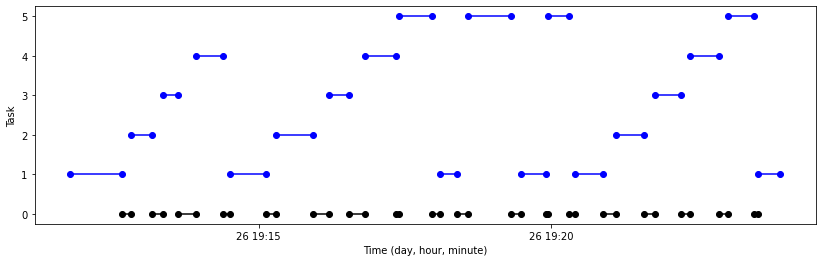

/Marker/1 contains 347 epochs
/Marker/2 contains 168 epochs
/Marker/3 contains 116 epochs
/Marker/4 contains 169 epochs
/Marker/5 contains 237 epochs
Between_Tasks contains 291 epochs


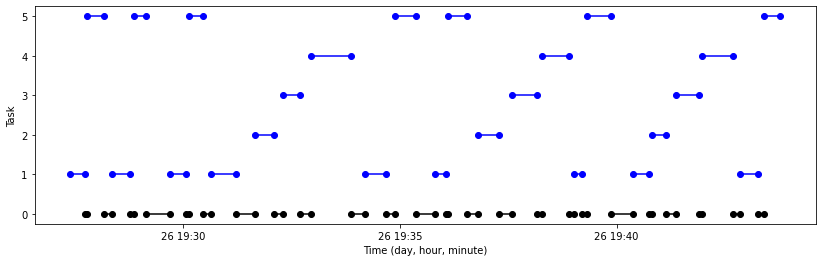

/Marker/1 contains 383 epochs
/Marker/2 contains 136 epochs
/Marker/3 contains 170 epochs
/Marker/4 contains 265 epochs
/Marker/5 contains 316 epochs
Between_Tasks contains 523 epochs


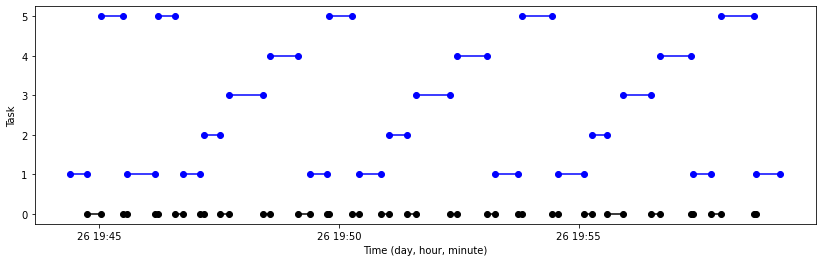

/Marker/1 contains 448 epochs
/Marker/2 contains 112 epochs
/Marker/3 contains 230 epochs
/Marker/4 contains 212 epochs
/Marker/5 contains 294 epochs
Between_Tasks contains 321 epochs


In [4]:
parser = lambda x: pd.datetime.strptime(x, "%Y-%m-%d %H:%M:%S.%f")

df0 = pd.read_csv(file_list[0], parse_dates=[0], date_parser=parser)
temp_timeaxis = pd.date_range(df0.TimeStamp.iloc[0], df0.TimeStamp.iloc[-1], len(df0)) 
df0['TimeStamp'] = temp_timeaxis
task_bounds_df0 = infer_task_boundaries(df0)
all_epochs_df0 = give_all_epochs(df0, task_bounds_df0)
df0 = df0.drop(['Elements'], axis=1).dropna()

df1 = pd.read_csv(file_list[1], parse_dates=[0], date_parser=parser)
temp_timeaxis_df1 = pd.date_range(df1.TimeStamp.iloc[0], df1.TimeStamp.iloc[-1], len(df1)) 
df1['TimeStamp'] = temp_timeaxis_df1
task_bounds_df1 = infer_task_boundaries(df1)
all_epochs_df1 = give_all_epochs(df1, task_bounds_df1)
df1 = df1.drop(['Elements'], axis=1).dropna()

df2 = pd.read_csv(file_list[2], parse_dates=[0], date_parser=parser)
temp_timeaxis_df2 = pd.date_range(df2.TimeStamp.iloc[0], df2.TimeStamp.iloc[-1], len(df2)) 
df2['TimeStamp'] = temp_timeaxis_df2
task_bounds_df2 = infer_task_boundaries(df2)
all_epochs_df2 = give_all_epochs(df2, task_bounds_df2)
df2 = df2.drop(['Elements'], axis=1).dropna()


# Wavelet transforms and aggregation should be done before concatenation
df = pd.concat([df0, df1, df2])


for data, task_bounds, all_epochs in zip([df0, df1, df2], 
                                         [task_bounds_df0 , task_bounds_df1 , task_bounds_df2], 
                                         [all_epochs_df0 , all_epochs_df1 , all_epochs_df2]):

    plt.figure(figsize=[14,4])

    for tpl in task_bounds['/Marker/1']:
        plt.plot([tpl[0][1].TimeStamp, tpl[1][1].TimeStamp], [1,1], color='b', marker='o')
    for tpl in task_bounds['/Marker/2']:
        plt.plot([tpl[0][1].TimeStamp, tpl[1][1].TimeStamp], [2,2], color='b', marker='o')
    for tpl in task_bounds['/Marker/3']:
        plt.plot([tpl[0][1].TimeStamp, tpl[1][1].TimeStamp], [3,3], color='b', marker='o')
    for tpl in task_bounds['/Marker/4']:
        plt.plot([tpl[0][1].TimeStamp, tpl[1][1].TimeStamp], [4,4], color='b', marker='o')
    for tpl in task_bounds['/Marker/5']:
        plt.plot([tpl[0][1].TimeStamp, tpl[1][1].TimeStamp], [5,5], color='b', marker='o')
    for tpl in task_bounds['Between_Tasks']:
        plt.plot([tpl[0][1].TimeStamp, tpl[1][1].TimeStamp], [0,0], color='k', marker='o')

    plt.xlabel('Time (day, hour, minute)')
    plt.ylabel('Task')

    plt.show()

    for key, values in all_epochs.items():
        print(key, 'contains', len(values), 'epochs')

In [10]:
df0.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 189564 entries, 2021-06-26 19:11:41.903000 to 2021-06-26 19:24:02.344000
Data columns (total 40 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   TimeStamp        189564 non-null  datetime64[ns]
 1   Delta_TP9        189564 non-null  float64       
 2   Delta_AF7        189564 non-null  float64       
 3   Delta_AF8        189564 non-null  float64       
 4   Delta_TP10       189564 non-null  float64       
 5   Theta_TP9        189564 non-null  float64       
 6   Theta_AF7        189564 non-null  float64       
 7   Theta_AF8        189564 non-null  float64       
 8   Theta_TP10       189564 non-null  float64       
 9   Alpha_TP9        189564 non-null  float64       
 10  Alpha_AF7        189564 non-null  float64       
 11  Alpha_AF8        189564 non-null  float64       
 12  Alpha_TP10       189564 non-null  float64       
 13  Beta_TP9         189564 no

In [5]:
def transform_epochs(dataframe, epoch_dict, agg_funcs=['mean','var'], downsample_or_agg_all='agg_all',
                     wavelet_width=0.5, wavelet_freqs=np.linspace(4, 80, 39), 
                     wavelet_extract_list=['power', 'amplitude', 'phase']):
    """Transform data within epochs
    epoch_dict contains lists of 2-tuples with start and end timestamps (of type Timedelta)
    downsample_string should match 
    """
    new_epoch_dict = {'/Marker/1':[], '/Marker/2':[], '/Marker/3':[], '/Marker/4':[], '/Marker/5':[], 'Between_Tasks':[]}
    wavelet_width_timedelta = pd.to_timedelta('00:00:'+str(wavelet_width))
    for marker_type in epoch_dict.keys():
        for epoch in tqdm(epoch_dict[marker_type]):
            start_timestamp = epoch[0]
            end_timestamp = epoch[1]
            
            start_for_wavelets = epoch[0] - (wavelet_width_timedelta/2)
            end_for_wavelets = epoch[1] + (wavelet_width_timedelta/2)
            
            raw_channels = ['RAW_TP9', 'RAW_AF7', 'RAW_AF8', 'RAW_TP10']
            convolve_segment = dataframe.loc[start_for_wavelets:end_for_wavelets, raw_channels]

            wavelet_output = apply_wavelets(data=convolve_segment.values, wavelet_width=wavelet_width, freqs=wavelet_freqs, 
                           n_wavelet_cycles=wavelet_freqs, extract_list=wavelet_extract_list)
            assert len(wavelet_output) == len(convolve_segment.index)
            wavelet_output.index = convolve_segment.index
            
            if 'phase' in wavelet_extract_list:

                # Extract phase differences between channels
                phase_diff_dict = dict()

                def smallestSignedAngleBetween(x, y):
                    """
                    based on function from https://stackoverflow.com/a/1878936
                    """
                    A = (x - y) % (2*np.pi)
                    B = (y - x) % (2*np.pi)
                    return [-a if a < b else b for a,b in zip(A,B)]

                for float_for_string in wavelet_freqs:
                    float_string = str(float_for_string)   #example: 'phase6.0HzCh0'

                    for ch_pair in [(0,1),(0,2),(0,3),(1,2),(1,3),(2,3)]:

                        name_string_A = 'phase'+float_string+'HzCh'+str(ch_pair[0])
                        name_string_B = 'phase'+float_string+'HzCh'+str(ch_pair[1])

                        phase_diff_name = 'phaseDifference_'+name_string_A+'_'+name_string_B

                        phase_diff = smallestSignedAngleBetween(x=wavelet_output[name_string_A], y=wavelet_output[name_string_B])

                        phase_diff_dict[phase_diff_name] = phase_diff

                        #print(phase_diff_name+': ', phase_diff_dict[phase_diff_name][0])
                        #print('\n')

                phase_diff_df = pd.DataFrame(phase_diff_dict, index=convolve_segment.index)

                all_features_single_epoch = pd.concat([dataframe.loc[start_for_wavelets:end_for_wavelets, :], 
                                                       wavelet_output, phase_diff_df], axis=1)

                # aggregation framework
                if downsample_or_agg_all=='agg_all':
                    agg_all_df = all_features_single_epoch.loc[start_timestamp:end_timestamp, :].agg(agg_funcs)
                    new_epoch_dict[marker_type].append((epoch, agg_all_df))
                    
                else:
                    downsample_string = downsample_or_agg_all # example:'100ms'
                    agg_all_df = all_features_single_epoch.loc[start_timestamp:end_timestamp, :].resample(downsample_string).agg(agg_funcs)
                    #print(len(agg_all_df))
                    new_epoch_dict[marker_type].append((epoch, agg_all_df))
                    
    return new_epoch_dict


In [12]:
new_epoch_dict = transform_epochs(dataframe=df0, epoch_dict=all_epochs_df0, agg_funcs=['mean','var'], 
                                  downsample_or_agg_all='agg_all',
                     wavelet_width=0.5, wavelet_freqs=np.linspace(4, 80, 39), 
                     wavelet_extract_list=['power', 'amplitude', 'phase'])

100%|████████████████████████████████████████████████████████████████████████████████| 291/291 [04:10<00:00,  1.16it/s]


In [14]:
import pickle

f = open("new_epoch_dict_df0.pickle", "wb")
pickle.dump(new_epoch_dict, f)
f.close()

# <a name="part2"> Part 2 - Modeling with scikit-learn </a >

[back to top](#TOC)


In [18]:
fileList_fullyAggregatedData = ['new_epoch_dict_df0.pickle', 
                                'new_epoch_dict_df1.pickle', 
                                'new_epoch_dict_df2.pickle']

# Load processed datasets of fully aggregated data
outer_dataset_holder = []

for file_num, pkl_file in enumerate(fileList_fullyAggregatedData):
  f = open(pkl_file, 'rb')
  data_dict = pickle.load(f)  
  # data will be in dictionary with 6 keys: {'/Marker/1':[...], '/Marker/2':[...], '/Marker/3':[...], '/Marker/4':[...], '/Marker/5':[...], 'Between_Tasks':[...]}
  # each value will be a pandas DataFrame with 2 rows, one for mean and one for var, and many columns.
  # 1) We want those 2 rows combined into 1 row. 
  # 2) Then add a target column that contains the marker type as an integer.
  # 3) All rows from all classes should be combined into a single dataframe. ---END OF THIS CELL---
  # Eventually, these should be combined and then converted into a numpy array while saving column names
  # features and target should then be separated
  # Finally, train_test splits can be made. Because adjacent epochs are not fully independent of each other, train_test splits should not be shuffled. (Use kwarg: shuffle=False)

  # Iterate over all epochs with each marker type.
  # Step 1. We want those 2 rows combined into 1 row. 
  # Step 2. Then add a target column that contains the marker type as an integer.

  # but first, obtain new column names
  old_index_agg_names = list(data_dict['/Marker/1'][0][1].index)
  old_column_names = list(data_dict['/Marker/1'][0][1].columns)
  new_column_names = [old_index_name+'_'+old_col_name for old_index_name in old_index_agg_names for old_col_name in old_column_names[1:]]  # ignore first column name because we want to drop timestamp

  row_holder = []

  for m, marker_type in enumerate(data_dict.keys()):
    for e, epoch_data in tqdm(enumerate(data_dict[marker_type])): # this is a list of dataframes
      epoch_data = epoch_data[1]
      epoch_data = epoch_data.drop(['TimeStamp'], axis=1)
      
      try:
        epoch_data = epoch_data.drop(['Elements'], axis=1)
      except:
        pass

      #new_epoch_data = pd.concat([epoch_data.iloc[[0], :], epoch_data.iloc[[1],:]], axis=1, ignore_index=True) # combine 2 rows into 1 row 
      new_epoch_data = np.hstack([epoch_data.iloc[[0], :].values, epoch_data.iloc[[1], :].values])
      new_epoch_data = pd.DataFrame(new_epoch_data, columns=new_column_names)

      #display(new_epoch_data.columns)  # DEBUGGING
      #print(set(new_epoch_data.columns) - set(new_column_names))  # DEBUGGING
      #mystery_columns_old = epoch_data.columns
      
      #new_epoch_data.columns = new_column_names

      try:
        new_epoch_data['TARGET'] = int(marker_type[-1])
      except:
        new_epoch_data['TARGET'] = 6
      new_epoch_data['ORIGINAL_ROW_NUM'] = e
      new_epoch_data['ORIGINAL_FILE_NUM'] = file_num

      # Confirm it worked by printing something on first iteration
      if e==0:
        if m==0:
          display(epoch_data)
          display(new_epoch_data)

      row_holder.append(new_epoch_data.copy())

  outer_dataset_holder.append(pd.concat(row_holder, axis=0))

# Step 3. All rows from all classes should be combined into a single dataframe.

df = pd.concat(outer_dataset_holder, axis=0)

0it [00:00, ?it/s]

Delta_TP9  Delta_AF7  Delta_AF8  Delta_TP10  Theta_TP9  Theta_AF7  \
mean   1.281114   0.781813   0.023883    0.835872   0.966218   0.310075   
var    0.016652   0.015491   0.083705    0.003625   0.003725   0.007193   

      Theta_AF8  Theta_TP10  Alpha_TP9  Alpha_AF7  ...  \
mean  -0.194602    0.438965   1.072347   0.776055  ...   
var    0.003670    0.001593   0.005977   0.002392  ...   

      phaseDifference_phase78.0HzCh0_phase78.0HzCh3  \
mean                                      -0.000654   
var                                        0.011730   

      phaseDifference_phase78.0HzCh1_phase78.0HzCh2  \
mean                                       0.000213   
var                                        0.037044   

      phaseDifference_phase78.0HzCh1_phase78.0HzCh3  \
mean                                      -0.000732   
var                                        0.034886   

      phaseDifference_phase78.0HzCh2_phase78.0HzCh3  \
mean                                      -0.000945   
var                                        0.022188   

      phaseDifference_phase80.0HzCh0_phase80.0HzCh1  \
mean                                      -0.000419   
var                                        0.032742   

      phaseDifference_phase80.0HzCh0_phase80.0HzCh2  \
mean                                      -0.000209   
var                                        0.030273   

      phaseDifference_phase80.0HzCh0_phase80.0HzCh3  \
mean                                      -0.000603   
var                                        0.036879   

      phaseDifference_phase80.0HzCh1_phase80.0HzCh2  \
mean                                       0.000210   
var                                        0.022927   

      phaseDifference_phase80.0HzCh1_phase80.0HzCh3  \
mean                                      -0.000184   
var                                        0.043265   

      phaseDifference_phase80.0HzCh2_phase80.0HzCh3  
mean                                      -0.000394  
var                                        0.031844  

[2 rows x 741 columns]

mean_Delta_TP9  mean_Delta_AF7  mean_Delta_AF8  mean_Delta_TP10  \
0        1.281114        0.781813        0.023883         0.835872   

   mean_Theta_TP9  mean_Theta_AF7  mean_Theta_AF8  mean_Theta_TP10  \
0        0.966218        0.310075       -0.194602         0.438965   

   mean_Alpha_TP9  mean_Alpha_AF7  ...  \
0        1.072347        0.776055  ...   

   var_phaseDifference_phase78.0HzCh2_phase78.0HzCh3  \
0                                           0.022188   

   var_phaseDifference_phase80.0HzCh0_phase80.0HzCh1  \
0                                           0.032742   

   var_phaseDifference_phase80.0HzCh0_phase80.0HzCh2  \
0                                           0.030273   

   var_phaseDifference_phase80.0HzCh0_phase80.0HzCh3  \
0                                           0.036879   

   var_phaseDifference_phase80.0HzCh1_phase80.0HzCh2  \
0                                           0.022927   

   var_phaseDifference_phase80.0HzCh1_phase80.0HzCh3  \
0                                           0.043265   

   var_phaseDifference_phase80.0HzCh2_phase80.0HzCh3  TARGET  \
0                                           0.031844       1   

   ORIGINAL_ROW_NUM  ORIGINAL_FILE_NUM  
0                 0                  0  

[1 rows x 1485 columns]

347it [00:02, 149.91it/s]
168it [00:00, 174.54it/s]
116it [00:00, 233.05it/s]
169it [00:00, 173.87it/s]
237it [00:01, 152.52it/s]
291it [00:01, 167.33it/s]
0it [00:00, ?it/s]

Delta_TP9  Delta_AF7  Delta_AF8  Delta_TP10  Theta_TP9  Theta_AF7  \
mean   1.372830    0.89116  -0.408845    1.169684   1.186342   0.504798   
var    0.015542    0.00867   0.002718    0.019503   0.025957   0.003025   

      Theta_AF8  Theta_TP10  Alpha_TP9  Alpha_AF7  ...  \
mean  -0.201440    0.876195   1.136663   1.031986  ...   
var    0.003865    0.017806   0.012724   0.028262  ...   

      phaseDifference_phase78.0HzCh0_phase78.0HzCh3  \
mean                                       0.000654   
var                                        0.069048   

      phaseDifference_phase78.0HzCh1_phase78.0HzCh2  \
mean                                      -0.001191   
var                                        0.039635   

      phaseDifference_phase78.0HzCh1_phase78.0HzCh3  \
mean                                       0.000122   
var                                        0.033917   

      phaseDifference_phase78.0HzCh2_phase78.0HzCh3  \
mean                                       0.001313   
var                                        0.016357   

      phaseDifference_phase80.0HzCh0_phase80.0HzCh1  \
mean                                       0.000302   
var                                        0.031000   

      phaseDifference_phase80.0HzCh0_phase80.0HzCh2  \
mean                                      -0.001417   
var                                        0.042749   

      phaseDifference_phase80.0HzCh0_phase80.0HzCh3  \
mean                                       0.000386   
var                                        0.045191   

      phaseDifference_phase80.0HzCh1_phase80.0HzCh2  \
mean                                      -0.001719   
var                                        0.023543   

      phaseDifference_phase80.0HzCh1_phase80.0HzCh3  \
mean                                       0.000084   
var                                        0.037068   

      phaseDifference_phase80.0HzCh2_phase80.0HzCh3  
mean                                       0.001803  
var                                        0.028520  

[2 rows x 741 columns]

mean_Delta_TP9  mean_Delta_AF7  mean_Delta_AF8  mean_Delta_TP10  \
0         1.37283         0.89116       -0.408845         1.169684   

   mean_Theta_TP9  mean_Theta_AF7  mean_Theta_AF8  mean_Theta_TP10  \
0        1.186342        0.504798        -0.20144         0.876195   

   mean_Alpha_TP9  mean_Alpha_AF7  ...  \
0        1.136663        1.031986  ...   

   var_phaseDifference_phase78.0HzCh2_phase78.0HzCh3  \
0                                           0.016357   

   var_phaseDifference_phase80.0HzCh0_phase80.0HzCh1  \
0                                              0.031   

   var_phaseDifference_phase80.0HzCh0_phase80.0HzCh2  \
0                                           0.042749   

   var_phaseDifference_phase80.0HzCh0_phase80.0HzCh3  \
0                                           0.045191   

   var_phaseDifference_phase80.0HzCh1_phase80.0HzCh2  \
0                                           0.023543   

   var_phaseDifference_phase80.0HzCh1_phase80.0HzCh3  \
0                                           0.037068   

   var_phaseDifference_phase80.0HzCh2_phase80.0HzCh3  TARGET  \
0                                            0.02852       1   

   ORIGINAL_ROW_NUM  ORIGINAL_FILE_NUM  
0                 0                  1  

[1 rows x 1485 columns]

383it [00:02, 178.36it/s]
136it [00:00, 165.81it/s]
170it [00:00, 215.81it/s]
265it [00:01, 169.67it/s]
316it [00:01, 187.68it/s]
523it [00:02, 193.43it/s]
0it [00:00, ?it/s]

Delta_TP9  Delta_AF7  Delta_AF8  Delta_TP10  Theta_TP9  Theta_AF7  \
mean   0.675369   0.326756  -0.271158    0.912659   0.495652   0.159894   
var    0.010527   0.001852   0.005216    0.001607   0.005722   0.002058   

      Theta_AF8  Theta_TP10  Alpha_TP9  Alpha_AF7  ...  \
mean  -0.446737    0.718576   0.834745   0.588240  ...   
var    0.029644    0.021608   0.037818   0.000768  ...   

      phaseDifference_phase78.0HzCh0_phase78.0HzCh3  \
mean                                      -0.000438   
var                                        0.030412   

      phaseDifference_phase78.0HzCh1_phase78.0HzCh2  \
mean                                      -0.000364   
var                                        0.084877   

      phaseDifference_phase78.0HzCh1_phase78.0HzCh3  \
mean                                       0.000118   
var                                        0.071837   

      phaseDifference_phase78.0HzCh2_phase78.0HzCh3  \
mean                                       0.000482   
var                                        0.029149   

      phaseDifference_phase80.0HzCh0_phase80.0HzCh1  \
mean                                      -0.000485   
var                                        0.050055   

      phaseDifference_phase80.0HzCh0_phase80.0HzCh2  \
mean                                      -0.000671   
var                                        0.039667   

      phaseDifference_phase80.0HzCh0_phase80.0HzCh3  \
mean                                       0.000100   
var                                        0.017209   

      phaseDifference_phase80.0HzCh1_phase80.0HzCh2  \
mean                                      -0.000186   
var                                        0.046779   

      phaseDifference_phase80.0HzCh1_phase80.0HzCh3  \
mean                                       0.000585   
var                                        0.036076   

      phaseDifference_phase80.0HzCh2_phase80.0HzCh3  
mean                                       0.000771  
var                                        0.015383  

[2 rows x 741 columns]

mean_Delta_TP9  mean_Delta_AF7  mean_Delta_AF8  mean_Delta_TP10  \
0        0.675369        0.326756       -0.271158         0.912659   

   mean_Theta_TP9  mean_Theta_AF7  mean_Theta_AF8  mean_Theta_TP10  \
0        0.495652        0.159894       -0.446737         0.718576   

   mean_Alpha_TP9  mean_Alpha_AF7  ...  \
0        0.834745         0.58824  ...   

   var_phaseDifference_phase78.0HzCh2_phase78.0HzCh3  \
0                                           0.029149   

   var_phaseDifference_phase80.0HzCh0_phase80.0HzCh1  \
0                                           0.050055   

   var_phaseDifference_phase80.0HzCh0_phase80.0HzCh2  \
0                                           0.039667   

   var_phaseDifference_phase80.0HzCh0_phase80.0HzCh3  \
0                                           0.017209   

   var_phaseDifference_phase80.0HzCh1_phase80.0HzCh2  \
0                                           0.046779   

   var_phaseDifference_phase80.0HzCh1_phase80.0HzCh3  \
0                                           0.036076   

   var_phaseDifference_phase80.0HzCh2_phase80.0HzCh3  TARGET  \
0                                           0.015383       1   

   ORIGINAL_ROW_NUM  ORIGINAL_FILE_NUM  
0                 0                  2  

[1 rows x 1485 columns]

448it [00:02, 189.41it/s]
112it [00:00, 163.99it/s]
230it [00:01, 167.87it/s]
212it [00:00, 236.96it/s]
294it [00:01, 169.49it/s]
321it [00:01, 193.74it/s]


In [19]:
df.shape

(4738, 1485)

In [20]:
# Verify the previous cell worked as intended.
print(df.info())
display(df.head())
display(df.tail())
print(df.TARGET.value_counts())
print('\n')
display(df[['TARGET', 'ORIGINAL_FILE_NUM']]. value_counts())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4738 entries, 0 to 0
Columns: 1485 entries, mean_Delta_TP9 to ORIGINAL_FILE_NUM
dtypes: float64(1482), int64(3)
memory usage: 53.7 MB
None


mean_Delta_TP9  mean_Delta_AF7  mean_Delta_AF8  mean_Delta_TP10  \
0        1.281114        0.781813        0.023883         0.835872   
0        1.244420        0.671776       -0.187324         0.851379   
0        1.290094        0.542345       -0.304561         0.826370   
0        1.331733        0.452397       -0.336660         0.814572   
0        1.333602        0.449530       -0.305736         0.826526   

   mean_Theta_TP9  mean_Theta_AF7  mean_Theta_AF8  mean_Theta_TP10  \
0        0.966218        0.310075       -0.194602         0.438965   
0        0.952180        0.239248       -0.223508         0.441364   
0        0.971706        0.216423       -0.241165         0.473454   
0        0.985945        0.251962       -0.250252         0.566070   
0        0.920860        0.333499       -0.252523         0.653662   

   mean_Alpha_TP9  mean_Alpha_AF7  ...  \
0        1.072347        0.776055  ...   
0        1.127428        0.749797  ...   
0        1.121910        0.756467  ...   
0        1.103558        0.801988  ...   
0        1.018876        0.850999  ...   

   var_phaseDifference_phase78.0HzCh2_phase78.0HzCh3  \
0                                           0.022188   
0                                           0.020243   
0                                           0.018590   
0                                           0.020623   
0                                           0.023472   

   var_phaseDifference_phase80.0HzCh0_phase80.0HzCh1  \
0                                           0.032742   
0                                           0.024925   
0                                           0.021632   
0                                           0.019970   
0                                           0.022868   

   var_phaseDifference_phase80.0HzCh0_phase80.0HzCh2  \
0                                           0.030273   
0                                           0.023177   
0                                           0.018301   
0                                           0.017374   
0                                           0.015392   

   var_phaseDifference_phase80.0HzCh0_phase80.0HzCh3  \
0                                           0.036879   
0                                           0.021686   
0                                           0.020463   
0                                           0.018093   
0                                           0.016395   

   var_phaseDifference_phase80.0HzCh1_phase80.0HzCh2  \
0                                           0.022927   
0                                           0.022421   
0                                           0.009737   
0                                           0.013567   
0                                           0.021534   

   var_phaseDifference_phase80.0HzCh1_phase80.0HzCh3  \
0                                           0.043265   
0                                           0.033435   
0                                           0.018866   
0                                           0.010891   
0                                           0.012438   

   var_phaseDifference_phase80.0HzCh2_phase80.0HzCh3  TARGET  \
0                                           0.031844       1   
0                                           0.029385       1   
0                                           0.019396       1   
0                                           0.013818       1   
0                                           0.013295       1   

   ORIGINAL_ROW_NUM  ORIGINAL_FILE_NUM  
0                 0                  0  
0                 1                  0  
0                 2                  0  
0                 3                  0  
0                 4                  0  

[5 rows x 1485 columns]

mean_Delta_TP9  mean_Delta_AF7  mean_Delta_AF8  mean_Delta_TP10  \
0        0.483026        0.914450        0.743641         1.071847   
0        0.483026        0.937956        0.830558         1.093985   
0        0.483026        0.887931        0.835202         1.128184   
0        0.483026        0.787457        0.761057         1.146172   
0        0.640561        0.358279        0.371188         0.513195   

   mean_Theta_TP9  mean_Theta_AF7  mean_Theta_AF8  mean_Theta_TP10  \
0        0.152806        0.524960        0.617830         0.820664   
0        0.152806        0.514129        0.656212         0.829916   
0        0.152806        0.434022        0.590853         0.842321   
0        0.152806        0.316860        0.468989         0.854113   
0        0.393952        0.173320       -0.038740         0.023034   

   mean_Alpha_TP9  mean_Alpha_AF7  ...  \
0        0.600545        0.492908  ...   
0        0.600545        0.491669  ...   
0        0.600545        0.507852  ...   
0        0.600545        0.496041  ...   
0        0.946156        0.481466  ...   

   var_phaseDifference_phase78.0HzCh2_phase78.0HzCh3  \
0                                           0.019240   
0                                           0.019008   
0                                           0.018723   
0                                           0.011942   
0                                           0.015531   

   var_phaseDifference_phase80.0HzCh0_phase80.0HzCh1  \
0                                           0.020308   
0                                           0.033340   
0                                           0.032149   
0                                           0.024663   
0                                           0.032703   

   var_phaseDifference_phase80.0HzCh0_phase80.0HzCh2  \
0                                           0.046429   
0                                           0.053430   
0                                           0.052349   
0                                           0.040471   
0                                           0.026886   

   var_phaseDifference_phase80.0HzCh0_phase80.0HzCh3  \
0                                           0.027150   
0                                           0.025431   
0                                           0.024310   
0                                           0.021069   
0                                           0.018465   

   var_phaseDifference_phase80.0HzCh1_phase80.0HzCh2  \
0                                           0.022719   
0                                           0.018427   
0                                           0.018259   
0                                           0.020180   
0                                           0.022115   

   var_phaseDifference_phase80.0HzCh1_phase80.0HzCh3  \
0                                           0.031630   
0                                           0.021093   
0                                           0.013831   
0                                           0.008235   
0                                           0.015800   

   var_phaseDifference_phase80.0HzCh2_phase80.0HzCh3  TARGET  \
0                                           0.030380       6   
0                                           0.024998       6   
0                                           0.025520       6   
0                                           0.019173       6   
0                                           0.008974       6   

   ORIGINAL_ROW_NUM  ORIGINAL_FILE_NUM  
0               316                  2  
0               317                  2  
0               318                  2  
0               319                  2  
0               320                  2  

[5 rows x 1485 columns]

1    1178
6    1135
5     847
4     646
3     516
2     416
Name: TARGET, dtype: int64




TARGET  ORIGINAL_FILE_NUM
6       1                    523
1       2                    448
        1                    383
        0                    347
6       2                    321
5       1                    316
        2                    294
6       0                    291
4       1                    265
5       0                    237
3       2                    230
4       2                    212
3       1                    170
4       0                    169
2       0                    168
        1                    136
3       0                    116
2       2                    112
dtype: int64

In [24]:
# Verify the previous cell worked as intended.
df.reset_index(drop=True, inplace=True)
print(df.info())
display(df.head())
display(df.tail())
print(df.TARGET.value_counts())
print('\n')
display(df[['TARGET', 'ORIGINAL_FILE_NUM']]. value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4738 entries, 0 to 4737
Columns: 1485 entries, mean_Delta_TP9 to ORIGINAL_FILE_NUM
dtypes: float64(1482), int64(3)
memory usage: 53.7 MB
None


mean_Delta_TP9  mean_Delta_AF7  mean_Delta_AF8  mean_Delta_TP10  \
0        1.281114        0.781813        0.023883         0.835872   
1        1.244420        0.671776       -0.187324         0.851379   
2        1.290094        0.542345       -0.304561         0.826370   
3        1.331733        0.452397       -0.336660         0.814572   
4        1.333602        0.449530       -0.305736         0.826526   

   mean_Theta_TP9  mean_Theta_AF7  mean_Theta_AF8  mean_Theta_TP10  \
0        0.966218        0.310075       -0.194602         0.438965   
1        0.952180        0.239248       -0.223508         0.441364   
2        0.971706        0.216423       -0.241165         0.473454   
3        0.985945        0.251962       -0.250252         0.566070   
4        0.920860        0.333499       -0.252523         0.653662   

   mean_Alpha_TP9  mean_Alpha_AF7  ...  \
0        1.072347        0.776055  ...   
1        1.127428        0.749797  ...   
2        1.121910        0.756467  ...   
3        1.103558        0.801988  ...   
4        1.018876        0.850999  ...   

   var_phaseDifference_phase78.0HzCh2_phase78.0HzCh3  \
0                                           0.022188   
1                                           0.020243   
2                                           0.018590   
3                                           0.020623   
4                                           0.023472   

   var_phaseDifference_phase80.0HzCh0_phase80.0HzCh1  \
0                                           0.032742   
1                                           0.024925   
2                                           0.021632   
3                                           0.019970   
4                                           0.022868   

   var_phaseDifference_phase80.0HzCh0_phase80.0HzCh2  \
0                                           0.030273   
1                                           0.023177   
2                                           0.018301   
3                                           0.017374   
4                                           0.015392   

   var_phaseDifference_phase80.0HzCh0_phase80.0HzCh3  \
0                                           0.036879   
1                                           0.021686   
2                                           0.020463   
3                                           0.018093   
4                                           0.016395   

   var_phaseDifference_phase80.0HzCh1_phase80.0HzCh2  \
0                                           0.022927   
1                                           0.022421   
2                                           0.009737   
3                                           0.013567   
4                                           0.021534   

   var_phaseDifference_phase80.0HzCh1_phase80.0HzCh3  \
0                                           0.043265   
1                                           0.033435   
2                                           0.018866   
3                                           0.010891   
4                                           0.012438   

   var_phaseDifference_phase80.0HzCh2_phase80.0HzCh3  TARGET  \
0                                           0.031844       1   
1                                           0.029385       1   
2                                           0.019396       1   
3                                           0.013818       1   
4                                           0.013295       1   

   ORIGINAL_ROW_NUM  ORIGINAL_FILE_NUM  
0                 0                  0  
1                 1                  0  
2                 2                  0  
3                 3                  0  
4                 4                  0  

[5 rows x 1485 columns]

mean_Delta_TP9  mean_Delta_AF7  mean_Delta_AF8  mean_Delta_TP10  \
4733        0.483026        0.914450        0.743641         1.071847   
4734        0.483026        0.937956        0.830558         1.093985   
4735        0.483026        0.887931        0.835202         1.128184   
4736        0.483026        0.787457        0.761057         1.146172   
4737        0.640561        0.358279        0.371188         0.513195   

      mean_Theta_TP9  mean_Theta_AF7  mean_Theta_AF8  mean_Theta_TP10  \
4733        0.152806        0.524960        0.617830         0.820664   
4734        0.152806        0.514129        0.656212         0.829916   
4735        0.152806        0.434022        0.590853         0.842321   
4736        0.152806        0.316860        0.468989         0.854113   
4737        0.393952        0.173320       -0.038740         0.023034   

      mean_Alpha_TP9  mean_Alpha_AF7  ...  \
4733        0.600545        0.492908  ...   
4734        0.600545        0.491669  ...   
4735        0.600545        0.507852  ...   
4736        0.600545        0.496041  ...   
4737        0.946156        0.481466  ...   

      var_phaseDifference_phase78.0HzCh2_phase78.0HzCh3  \
4733                                           0.019240   
4734                                           0.019008   
4735                                           0.018723   
4736                                           0.011942   
4737                                           0.015531   

      var_phaseDifference_phase80.0HzCh0_phase80.0HzCh1  \
4733                                           0.020308   
4734                                           0.033340   
4735                                           0.032149   
4736                                           0.024663   
4737                                           0.032703   

      var_phaseDifference_phase80.0HzCh0_phase80.0HzCh2  \
4733                                           0.046429   
4734                                           0.053430   
4735                                           0.052349   
4736                                           0.040471   
4737                                           0.026886   

      var_phaseDifference_phase80.0HzCh0_phase80.0HzCh3  \
4733                                           0.027150   
4734                                           0.025431   
4735                                           0.024310   
4736                                           0.021069   
4737                                           0.018465   

      var_phaseDifference_phase80.0HzCh1_phase80.0HzCh2  \
4733                                           0.022719   
4734                                           0.018427   
4735                                           0.018259   
4736                                           0.020180   
4737                                           0.022115   

      var_phaseDifference_phase80.0HzCh1_phase80.0HzCh3  \
4733                                           0.031630   
4734                                           0.021093   
4735                                           0.013831   
4736                                           0.008235   
4737                                           0.015800   

      var_phaseDifference_phase80.0HzCh2_phase80.0HzCh3  TARGET  \
4733                                           0.030380       6   
4734                                           0.024998       6   
4735                                           0.025520       6   
4736                                           0.019173       6   
4737                                           0.008974       6   

      ORIGINAL_ROW_NUM  ORIGINAL_FILE_NUM  
4733               316                  2  
4734               317                  2  
4735               318                  2  
4736               319                  2  
4737               320                  2  

[5 rows x 1485 columns]

1    1178
6    1135
5     847
4     646
3     516
2     416
Name: TARGET, dtype: int64




TARGET  ORIGINAL_FILE_NUM
6       1                    523
1       2                    448
        1                    383
        0                    347
6       2                    321
5       1                    316
        2                    294
6       0                    291
4       1                    265
5       0                    237
3       2                    230
4       2                    212
3       1                    170
4       0                    169
2       0                    168
        1                    136
3       0                    116
2       2                    112
dtype: int64

In [25]:
for col in df.columns:
    if df[col].isnull().sum() > 0:
        print(df[col].isnull().sum())

# <a name="exp1"> Experiment 1: M1 (eyes open; class 0) vs M5 (eyes closed; class 1)  </a >

[back to top](#TOC)

In [26]:
# Let's start with M1 vs. M5
M1_session0 = df.loc[df.TARGET==1].loc[df.ORIGINAL_FILE_NUM==0]
M1_session1 = df.loc[df.TARGET==1].loc[df.ORIGINAL_FILE_NUM==1]
M1_session2 = df.loc[df.TARGET==1].loc[df.ORIGINAL_FILE_NUM==2]

M5_session0 = df.loc[df.TARGET==5].loc[df.ORIGINAL_FILE_NUM==0]
M5_session1 = df.loc[df.TARGET==5].loc[df.ORIGINAL_FILE_NUM==1]
M5_session2 = df.loc[df.TARGET==5].loc[df.ORIGINAL_FILE_NUM==2]
print(len(M1_session0),
      len(M1_session1),
      len(M1_session2),
      len(M5_session0),
      len(M5_session1),
      len(M5_session2))

M1_train_list = [M1_session0.iloc[:200], M1_session1.iloc[:200], M1_session2.iloc[:200]]
M5_train_list = [M5_session0.iloc[:200], M5_session1.iloc[:200], M5_session2.iloc[:200]]

347 383 448 237 316 294


In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
from tqdm import tqdm  # monitor iteration cycles. Important for iterative processes that take a long time to finish all iterations.

import pickle

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, roc_auc_score

In [30]:
# Use 200 from each of the above. Note that leaves holdout data for later testing.
# This experiment is eyes open baseline (M1) versus eyes closed baseline (M5)

outer1, outer2, outer3, outer4 = [],[],[],[]

for dataset in [M1_session0.iloc[:200], M1_session1.iloc[:200], M1_session2.iloc[:200], M5_session0.iloc[:200], M5_session1.iloc[:200], M5_session2.iloc[:200]]:
  y = np.array(dataset['TARGET']).reshape(-1, 1)
  X = np.array(dataset.drop(['TARGET','ORIGINAL_ROW_NUM','ORIGINAL_FILE_NUM'], axis=1))

  print('y.shape',y.shape)

  X_train_subset, X_test_subset, y_train_subset, y_test_subset = train_test_split(X, y, test_size=0.2, shuffle=False)

  outer1.append(X_train_subset)
  outer2.append(X_test_subset)
  outer3.append(y_train_subset)
  outer4.append(y_test_subset)

X_train = np.vstack(outer1)
X_test = np.vstack(outer2)
y_train = np.vstack(outer3).ravel()
y_test = np.vstack(outer4).ravel()

print('X_train.shape', X_train.shape)
print('X_test.shape', X_test.shape)
print('y_train.shape',y_train.shape)
print('y_test.shape',y_test.shape)

y.shape (200, 1)
y.shape (200, 1)
y.shape (200, 1)
y.shape (200, 1)
y.shape (200, 1)
y.shape (200, 1)
X_train.shape (960, 1482)
X_test.shape (240, 1482)
y_train.shape (960,)
y_test.shape (240,)


In [31]:
# Now make the pipeline
from sklearn.decomposition import PCA
#from sklearn.preprocessing import StandardScaler
#from sklearn.svm import SVC
#from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
#from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
#from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier

pipeline_1a_steps = [
    ('scaler',StandardScaler()),
    ('est',SVC())
]

pipeline_1b_steps = [
    ('scaler',StandardScaler()),
    ('pca',PCA()),
    ('est',SVC())
]

pipeline_2a_steps = [
    ('scaler',StandardScaler()),
    ('est',LinearDiscriminantAnalysis())
]

pipeline_2b_steps = [
    ('scaler',StandardScaler()),
    ('pca',PCA()),
    ('est',LinearDiscriminantAnalysis())
]

pipeline_3a_steps = [
    ('scaler',StandardScaler()),
    ('est',RandomForestClassifier())
]

pipeline_3b_steps = [
    ('scaler',StandardScaler()),
    ('pca',PCA()),
    ('est',RandomForestClassifier())
]

pipeline_4a_steps = [
    ('scaler',StandardScaler()),
    ('est',AdaBoostClassifier())
]

pipeline_4b_steps = [
    ('scaler',StandardScaler()),
    ('pca',PCA()),
    ('est',AdaBoostClassifier())
]

pipeline_5a_steps = [
    ('scaler',StandardScaler()),
    ('est',GradientBoostingClassifier())
]

pipeline_5b_steps = [
    ('scaler',StandardScaler()),
    ('pca',PCA()),
    ('est',GradientBoostingClassifier())
]

pipeline_6a_steps = [
                    ('scaler',StandardScaler()),
                    ('est',DecisionTreeClassifier())
]

pipeline_6b_steps = [
                    ('scaler',StandardScaler()),
                     ('pca',PCA()),
                    ('est',DecisionTreeClassifier())
]

SVC_no_PCA
for TRAINING DATA
ROC_AUC Score: 1.0
Accuracy Score: 1.0


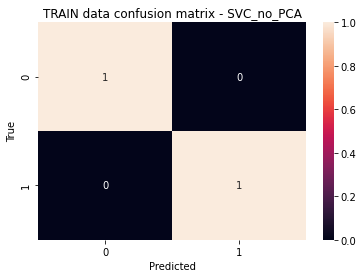

SVC_no_PCA
for TESTING DATA
ROC_AUC Score: 0.9958333333333333
Accuracy Score: 0.9958333333333333


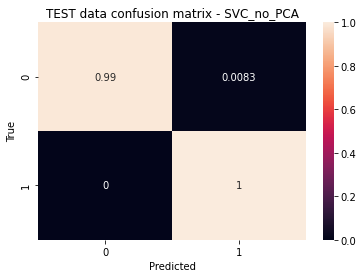

SVC_with_PCA
for TRAINING DATA
ROC_AUC Score: 1.0
Accuracy Score: 1.0


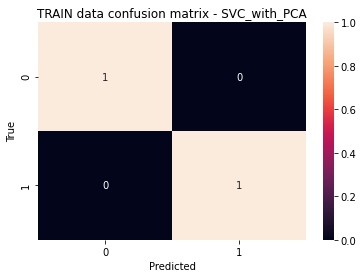

SVC_with_PCA
for TESTING DATA
ROC_AUC Score: 0.9958333333333333
Accuracy Score: 0.9958333333333333


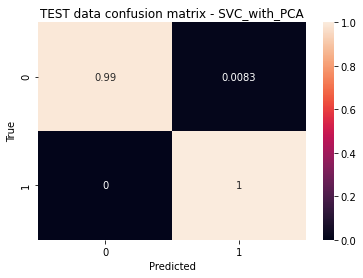

LDA_no_PCA
for TRAINING DATA
ROC_AUC Score: 1.0
Accuracy Score: 1.0


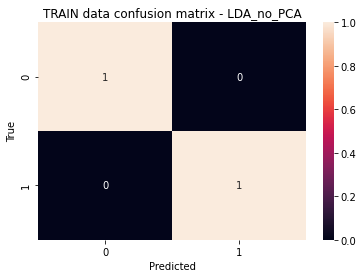

LDA_no_PCA
for TESTING DATA
ROC_AUC Score: 0.9291666666666666
Accuracy Score: 0.9291666666666667


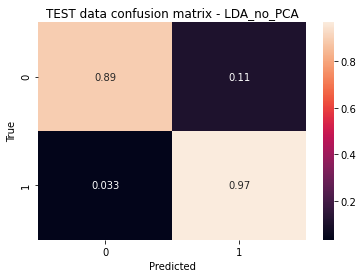

LDA_with_PCA
for TRAINING DATA
ROC_AUC Score: 0.5000000000000001
Accuracy Score: 0.5


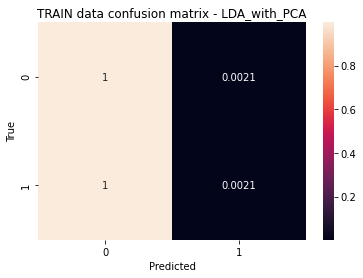

LDA_with_PCA
for TESTING DATA
ROC_AUC Score: 0.5375
Accuracy Score: 0.5375


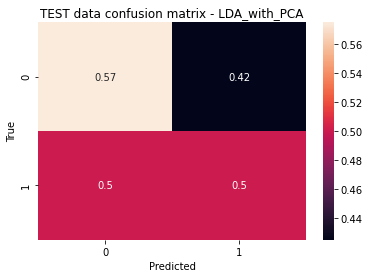

RandomForest_no_PCA
for TRAINING DATA
ROC_AUC Score: 1.0
Accuracy Score: 1.0


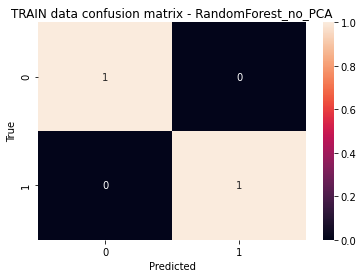

RandomForest_no_PCA
for TESTING DATA
ROC_AUC Score: 1.0
Accuracy Score: 1.0


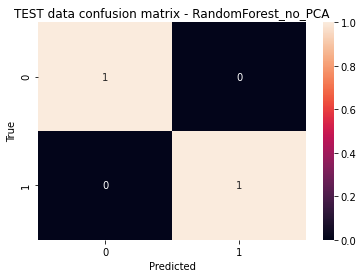

RandomForest_with_PCA
for TRAINING DATA
ROC_AUC Score: 1.0
Accuracy Score: 1.0


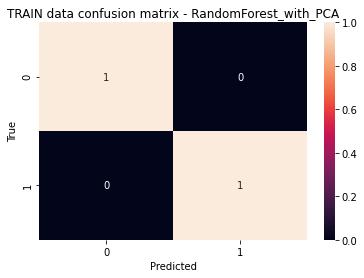

RandomForest_with_PCA
for TESTING DATA
ROC_AUC Score: 0.8
Accuracy Score: 0.8


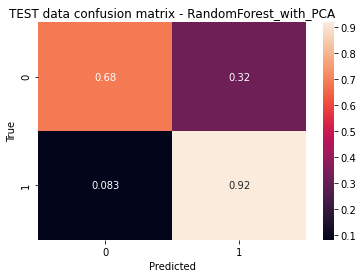

AdaBoost_no_PCA
for TRAINING DATA
ROC_AUC Score: 1.0
Accuracy Score: 1.0


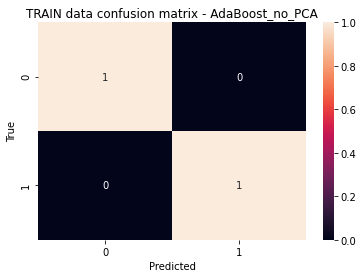

AdaBoost_no_PCA
for TESTING DATA
ROC_AUC Score: 0.9625
Accuracy Score: 0.9625


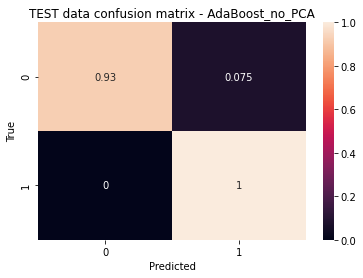

AdaBoost_with_PCA
for TRAINING DATA
ROC_AUC Score: 1.0
Accuracy Score: 1.0


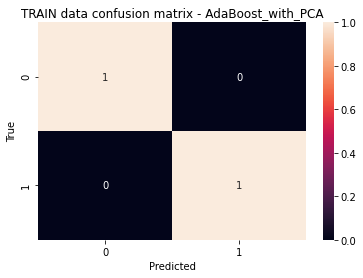

AdaBoost_with_PCA
for TESTING DATA
ROC_AUC Score: 0.9625000000000001
Accuracy Score: 0.9625


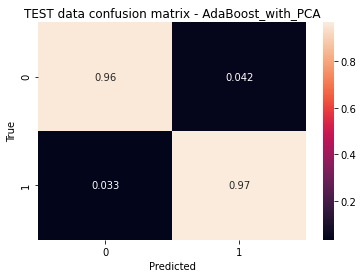

GradientBoosting_no_PCA
for TRAINING DATA
ROC_AUC Score: 1.0
Accuracy Score: 1.0


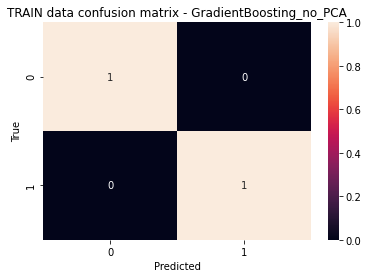

GradientBoosting_no_PCA
for TESTING DATA
ROC_AUC Score: 0.9291666666666666
Accuracy Score: 0.9291666666666667


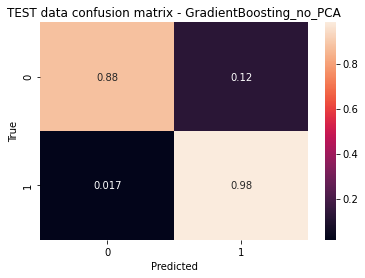

GradientBoosting_with_PCA
for TRAINING DATA
ROC_AUC Score: 1.0
Accuracy Score: 1.0


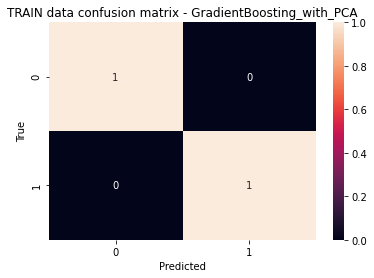

GradientBoosting_with_PCA
for TESTING DATA
ROC_AUC Score: 0.9750000000000001
Accuracy Score: 0.975


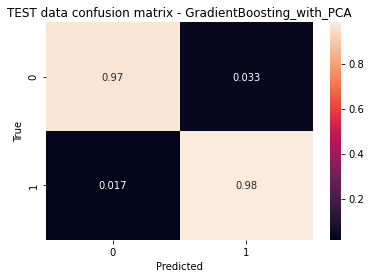

DecisionTree_no_PCA
for TRAINING DATA
ROC_AUC Score: 1.0
Accuracy Score: 1.0


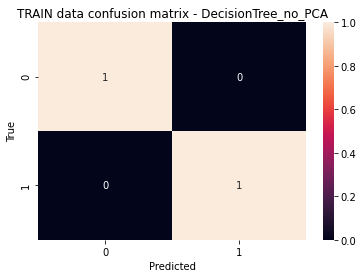

DecisionTree_no_PCA
for TESTING DATA
ROC_AUC Score: 0.9333333333333333
Accuracy Score: 0.9333333333333333


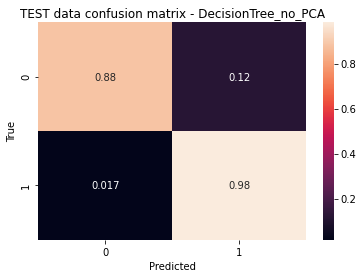

DecisionTree_with_PCA
for TRAINING DATA
ROC_AUC Score: 1.0
Accuracy Score: 1.0


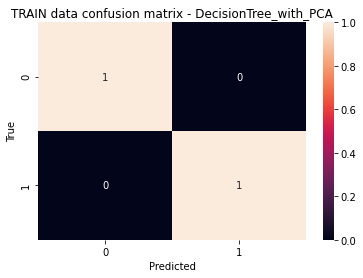

DecisionTree_with_PCA
for TESTING DATA
ROC_AUC Score: 0.6083333333333333
Accuracy Score: 0.6083333333333334


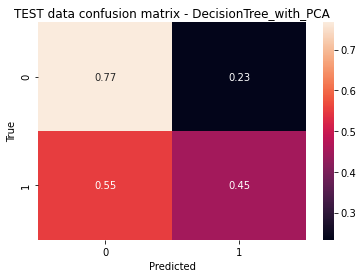

pipeline_name  \
0                  SVC_no_PCA   
1                SVC_with_PCA   
2                  LDA_no_PCA   
3                LDA_with_PCA   
4         RandomForest_no_PCA   
5       RandomForest_with_PCA   
6             AdaBoost_no_PCA   
7           AdaBoost_with_PCA   
8     GradientBoosting_no_PCA   
9   GradientBoosting_with_PCA   
10        DecisionTree_no_PCA   
11      DecisionTree_with_PCA   

                                          named_steps  train_ROC_score  \
0          {'scaler': StandardScaler(), 'est': SVC()}              1.0   
1   {'scaler': StandardScaler(), 'pca': PCA(), 'es...              1.0   
2   {'scaler': StandardScaler(), 'est': LinearDisc...              1.0   
3   {'scaler': StandardScaler(), 'pca': PCA(), 'es...              0.5   
4   {'scaler': StandardScaler(), 'est': RandomFore...              1.0   
5   {'scaler': StandardScaler(), 'pca': PCA(), 'es...              1.0   
6   {'scaler': StandardScaler(), 'est': AdaBoostCl...              1.0   
7   {'scaler': StandardScaler(), 'pca': PCA(), 'es...              1.0   
8   {'scaler': StandardScaler(), 'est': GradientBo...              1.0   
9   {'scaler': StandardScaler(), 'pca': PCA(), 'es...              1.0   
10  {'scaler': StandardScaler(), 'est': DecisionTr...              1.0   
11  {'scaler': StandardScaler(), 'pca': PCA(), 'es...              1.0   

    train_acc_score                             train_confusion_matrix  \
0               1.0                           [[1.0, 0.0], [0.0, 1.0]]   
1               1.0                           [[1.0, 0.0], [0.0, 1.0]]   
2               1.0                           [[1.0, 0.0], [0.0, 1.0]]   
3               0.5  [[0.9979166666666667, 0.0020833333333333333], ...   
4               1.0                           [[1.0, 0.0], [0.0, 1.0]]   
5               1.0                           [[1.0, 0.0], [0.0, 1.0]]   
6               1.0                           [[1.0, 0.0], [0.0, 1.0]]   
7               1.0                           [[1.0, 0.0], [0.0, 1.0]]   
8               1.0                           [[1.0, 0.0], [0.0, 1.0]]   
9               1.0                           [[1.0, 0.0], [0.0, 1.0]]   
10              1.0                           [[1.0, 0.0], [0.0, 1.0]]   
11              1.0                           [[1.0, 0.0], [0.0, 1.0]]   

    test_ROC_score  test_acc_score  \
0         0.995833        0.995833   
1         0.995833        0.995833   
2         0.929167        0.929167   
3         0.537500        0.537500   
4         1.000000        1.000000   
5         0.800000        0.800000   
6         0.962500        0.962500   
7         0.962500        0.962500   
8         0.929167        0.929167   
9         0.975000        0.975000   
10        0.933333        0.933333   
11        0.608333        0.608333   

                                test_confusion_matrix  
0   [[0.9916666666666667, 0.008333333333333333], [...  
1   [[0.9916666666666667, 0.008333333333333333], [...  
2   [[0.8916666666666667, 0.10833333333333334], [0...  
3                        [[0.575, 0.425], [0.5, 0.5]]  
4                            [[1.0, 0.0], [0.0, 1.0]]  
5   [[0.6833333333333333, 0.31666666666666665], [0...  
6                        [[0.925, 0.075], [0.0, 1.0]]  
7   [[0.9583333333333334, 0.041666666666666664], [...  
8   [[0.875, 0.125], [0.016666666666666666, 0.9833...  
9   [[0.9666666666666667, 0.03333333333333333], [0...  
10  [[0.8833333333333333, 0.11666666666666667], [0...  
11  [[0.7666666666666667, 0.23333333333333334], [0...

In [33]:
model_metrics = []

for pipe_steps, name in zip([pipeline_1a_steps, pipeline_1b_steps, pipeline_2a_steps, pipeline_2b_steps, 
                         pipeline_3a_steps, pipeline_3b_steps, pipeline_4a_steps, pipeline_4b_steps,
                         pipeline_5a_steps, pipeline_5b_steps, pipeline_6a_steps, pipeline_6b_steps],
                         ["SVC_no_PCA","SVC_with_PCA","LDA_no_PCA","LDA_with_PCA",
                          "RandomForest_no_PCA","RandomForest_with_PCA","AdaBoost_no_PCA","AdaBoost_with_PCA",
                          "GradientBoosting_no_PCA","GradientBoosting_with_PCA","DecisionTree_no_PCA","DecisionTree_with_PCA"]):
  
  pipe = Pipeline(pipe_steps)
  pipe.fit(X_train, y_train)
  train_predictions = pipe.predict(X_train)
  test_preds = pipe.predict(X_test)

  model_metrics_dict = {'pipeline_name': name, 'named_steps': str(pipe.named_steps)}

  print(name)
  print("for TRAINING DATA")

  model_metrics_dict['train_ROC_score'] = roc_auc_score(y_train, train_predictions)
  model_metrics_dict['train_acc_score'] = balanced_accuracy_score(y_train, train_predictions)
  model_metrics_dict['train_confusion_matrix'] = confusion_matrix(y_train, train_predictions, normalize='true')

  print("ROC_AUC Score:", model_metrics_dict['train_ROC_score'])
  print("Accuracy Score:", model_metrics_dict['train_acc_score'])
  sns.heatmap(model_metrics_dict['train_confusion_matrix'], annot=True)
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.title('TRAIN data confusion matrix - '+name)
  plt.show()

  print(name)
  print("for TESTING DATA")

  model_metrics_dict['test_ROC_score'] = roc_auc_score(y_test, test_preds)
  model_metrics_dict['test_acc_score'] = balanced_accuracy_score(y_test, test_preds)
  model_metrics_dict['test_confusion_matrix'] = confusion_matrix(y_test, test_preds, normalize='true')
  
  print("ROC_AUC Score:", model_metrics_dict['test_ROC_score'] )
  print("Accuracy Score:", model_metrics_dict['test_acc_score'])
  sns.heatmap(model_metrics_dict['test_confusion_matrix'], annot=True)
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.title('TEST data confusion matrix - '+name)
  plt.show()

  model_metrics.append(model_metrics_dict)


model_metrics_df = pd.DataFrame( {'pipeline_name': [metrics['pipeline_name'] for metrics in model_metrics],
                                  'named_steps': [metrics['named_steps'] for metrics in model_metrics],
                                  'train_ROC_score': [metrics['train_ROC_score'] for metrics in model_metrics],
                                  'train_acc_score': [metrics['train_acc_score'] for metrics in model_metrics],
                                  'train_confusion_matrix': [metrics['train_confusion_matrix'] for metrics in model_metrics],
                                  'test_ROC_score': [metrics['test_ROC_score'] for metrics in model_metrics],
                                  'test_acc_score': [metrics['test_acc_score'] for metrics in model_metrics],
                                  'test_confusion_matrix': [metrics['test_confusion_matrix'] for metrics in model_metrics]} )

display(model_metrics_df)

model_metrics_df.to_csv('model_metrics\\M1vM5_experiment_agg_notOptimized_200samplesPerSession.csv')

RandomForest_no_PCA
for TRAINING DATA
ROC_AUC Score: 1.0
Accuracy Score: 1.0


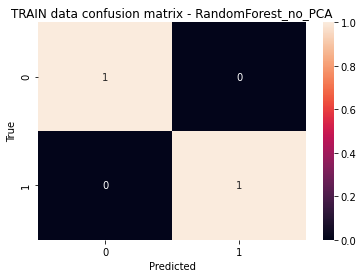

RandomForest_no_PCA
for TESTING DATA
ROC_AUC Score: 0.9958333333333333
Accuracy Score: 0.9958333333333333


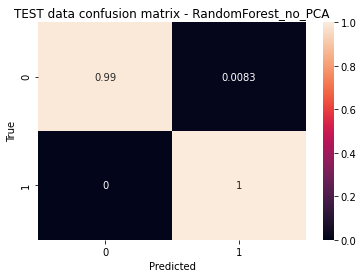

mean_power76.0HzCh1                                   0.037261
mean_amplitude58.0HzCh1                               0.036103
var_amplitude78.0HzCh1                                0.034273
mean_power10.0HzCh3                                   0.028574
var_phaseDifference_phase42.0HzCh1_phase42.0HzCh3     0.027517
                                                        ...   
mean_phaseDifference_phase28.0HzCh0_phase28.0HzCh2    0.000000
mean_phaseDifference_phase28.0HzCh0_phase28.0HzCh1    0.000000
mean_phaseDifference_phase26.0HzCh2_phase26.0HzCh3    0.000000
mean_phaseDifference_phase26.0HzCh1_phase26.0HzCh3    0.000000
var_phaseDifference_phase80.0HzCh2_phase80.0HzCh3     0.000000
Length: 1482, dtype: float64
mean_power76.0HzCh1                                  0.037261
mean_amplitude58.0HzCh1                              0.036103
var_amplitude78.0HzCh1                               0.034273
mean_power10.0HzCh3                                  0.028574
var_phaseDifference_phase42.0H

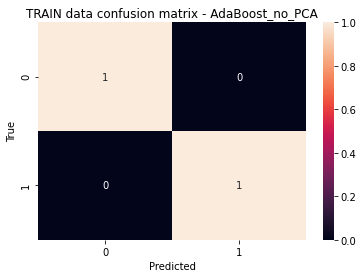

AdaBoost_no_PCA
for TESTING DATA
ROC_AUC Score: 0.9625
Accuracy Score: 0.9625


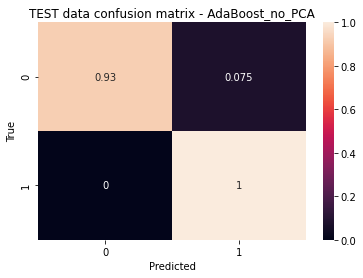

mean_Alpha_TP10                                      0.10
mean_amplitude72.0HzCh1                              0.04
var_power10.0HzCh3                                   0.04
mean_Delta_AF8                                       0.04
mean_power70.0HzCh1                                  0.04
                                                     ... 
mean_phaseDifference_phase4.0HzCh0_phase4.0HzCh1     0.00
mean_phase80.0HzCh3                                  0.00
mean_phase78.0HzCh3                                  0.00
mean_phase76.0HzCh3                                  0.00
var_phaseDifference_phase80.0HzCh2_phase80.0HzCh3    0.00
Length: 1482, dtype: float64
mean_Alpha_TP10                                      0.10
mean_amplitude72.0HzCh1                              0.04
var_power10.0HzCh3                                   0.04
mean_Delta_AF8                                       0.04
mean_power70.0HzCh1                                  0.04
mean_power80.0HzCh1                        

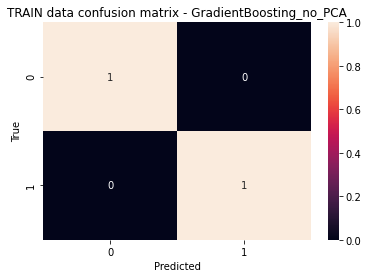

GradientBoosting_no_PCA
for TESTING DATA
ROC_AUC Score: 0.9291666666666666
Accuracy Score: 0.9291666666666667


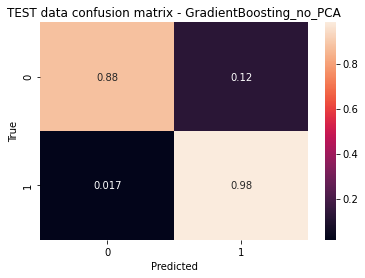

mean_power70.0HzCh1                                   9.146086e-01
mean_Alpha_TP10                                       4.527634e-02
mean_power74.0HzCh1                                   1.319184e-02
var_amplitude74.0HzCh1                                5.784964e-03
mean_amplitude74.0HzCh1                               5.783374e-03
                                                          ...     
var_power78.0HzCh1                                   -3.821343e-19
var_power8.0HzCh2                                    -6.238891e-19
mean_phaseDifference_phase18.0HzCh2_phase18.0HzCh3   -1.301562e-18
mean_phase80.0HzCh1                                  -1.519385e-18
var_phase66.0HzCh1                                   -3.097932e-18
Length: 1482, dtype: float64
mean_power70.0HzCh1                                   0.914609
mean_Alpha_TP10                                       0.045276
mean_power74.0HzCh1                                   0.013192
var_amplitude74.0HzCh1                       

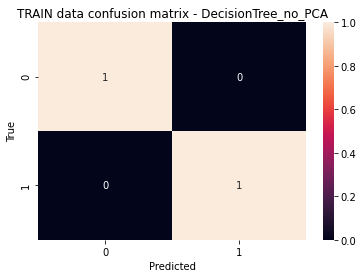

DecisionTree_no_PCA
for TESTING DATA
ROC_AUC Score: 0.9375
Accuracy Score: 0.9375


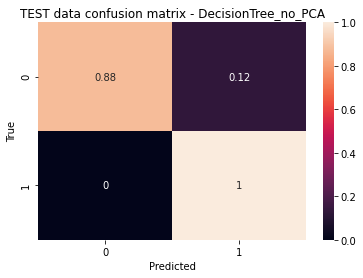

mean_power70.0HzCh1                                  0.914609
mean_Alpha_TP10                                      0.045276
mean_amplitude74.0HzCh1                              0.028735
var_power44.0HzCh2                                   0.007222
var_phaseDifference_phase80.0HzCh1_phase80.0HzCh2    0.004158
                                                       ...   
mean_phase56.0HzCh3                                  0.000000
mean_phase54.0HzCh3                                  0.000000
mean_phase52.0HzCh3                                  0.000000
mean_phase50.0HzCh3                                  0.000000
var_phaseDifference_phase80.0HzCh2_phase80.0HzCh3    0.000000
Length: 1482, dtype: float64
mean_power70.0HzCh1                                  0.914609
mean_Alpha_TP10                                      0.045276
mean_amplitude74.0HzCh1                              0.028735
var_power44.0HzCh2                                   0.007222
var_phaseDifference_phase80.0HzCh1_phase8

In [35]:
for pipe_steps, name in zip([
                         pipeline_3a_steps, pipeline_4a_steps, pipeline_5a_steps, pipeline_6a_steps],
                         [
                          "RandomForest_no_PCA", "AdaBoost_no_PCA", "GradientBoosting_no_PCA", "DecisionTree_no_PCA"]):
  
  pipe = Pipeline(pipe_steps)
  pipe.fit(X_train, y_train)
  train_predictions = pipe.predict(X_train)
  test_preds = pipe.predict(X_test)

  model_metrics_dict = {'pipeline_name': name, 'named_steps': str(pipe.named_steps)}

  print(name)
  print("for TRAINING DATA")

  model_metrics_dict['train_ROC_score'] = roc_auc_score(y_train, train_predictions)
  model_metrics_dict['train_acc_score'] = balanced_accuracy_score(y_train, train_predictions)
  model_metrics_dict['train_confusion_matrix'] = confusion_matrix(y_train, train_predictions, normalize='true')

  print("ROC_AUC Score:", model_metrics_dict['train_ROC_score'])
  print("Accuracy Score:", model_metrics_dict['train_acc_score'])
  sns.heatmap(model_metrics_dict['train_confusion_matrix'], annot=True)
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.title('TRAIN data confusion matrix - '+name)
  plt.show()

  print(name)
  print("for TESTING DATA")

  model_metrics_dict['test_ROC_score'] = roc_auc_score(y_test, test_preds)
  model_metrics_dict['test_acc_score'] = balanced_accuracy_score(y_test, test_preds)
  model_metrics_dict['test_confusion_matrix'] = confusion_matrix(y_test, test_preds, normalize='true')
  
  print("ROC_AUC Score:", model_metrics_dict['test_ROC_score'] )
  print("Accuracy Score:", model_metrics_dict['test_acc_score'])
  sns.heatmap(model_metrics_dict['test_confusion_matrix'], annot=True)
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.title('TEST data confusion matrix - '+name)
  plt.show()

  feat_import = pd.Series(pipe.named_steps.est.feature_importances_, index= dataset.drop(['TARGET','ORIGINAL_ROW_NUM','ORIGINAL_FILE_NUM'], axis=1).columns)

  #plt.bar(dataset.drop(['index','TARGET','ORIGINAL_ROW_NUM','ORIGINAL_FILE_NUM'], axis=1).columns, pipe.named_steps.est.feature_importances_)
  #plt.show()

  print(feat_import.sort_values(ascending=False))

  print(feat_import.sort_values(ascending=False)[:30])

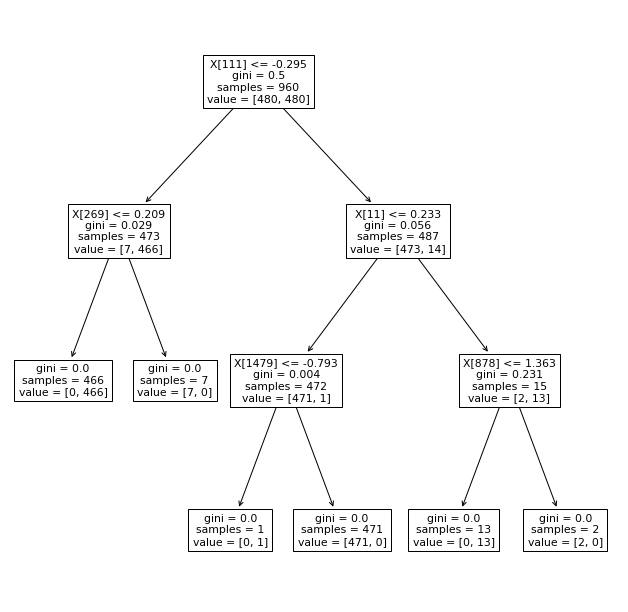

In [38]:
from sklearn.tree import plot_tree

plt.figure(figsize=(11,11))
plot_tree(pipe.named_steps.est)
plt.show()

In [41]:
temp = index= dataset.drop(['TARGET','ORIGINAL_ROW_NUM','ORIGINAL_FILE_NUM'], axis=1).columns

print('X[111]:', temp[111])

print('X[269]:', temp[269])
print('X[11]:', temp[11])

print('X[1479]:', temp[1479])
print('X[878]:', temp[878])


X[111]: mean_power70.0HzCh1
X[269]: mean_amplitude74.0HzCh1
X[11]: mean_Alpha_TP10
X[1479]: var_phaseDifference_phase80.0HzCh1_phase80.0HzCh2
X[878]: var_power44.0HzCh2


### Experiment 1 results:
* The effect appears to be real and meaningful. I say this because the feature importance information consistently points to gamma frequencies in Ch1 (AF7; left frontal) and alpha frequencies in Ch3 (TP10; right temporal).
    * Reduction in alpha frequency with eyes closed is well-known.
    * I easily noticed the gamma effect during recording (I was watching the spectrogram in Mind Monitor)

* This classifier should be considered to be reliable and generally accurate.

# <a name="exp2">  Experiment 2 - M1 (baseline) vs M2 (mental action)  </a >

[back to top](#TOC)

In [42]:
 # M1 vs. M2
M1_session0 = df.loc[df.TARGET==1].loc[df.ORIGINAL_FILE_NUM==0]
M1_session1 = df.loc[df.TARGET==1].loc[df.ORIGINAL_FILE_NUM==1]
M1_session2 = df.loc[df.TARGET==1].loc[df.ORIGINAL_FILE_NUM==2]

M2_session0 = df.loc[df.TARGET==2].loc[df.ORIGINAL_FILE_NUM==0]
M2_session1 = df.loc[df.TARGET==2].loc[df.ORIGINAL_FILE_NUM==1]
M2_session2 = df.loc[df.TARGET==2].loc[df.ORIGINAL_FILE_NUM==2]
print(len(M1_session0),
      len(M1_session1),
      len(M1_session2),
      len(M2_session0),
      len(M2_session1),
      len(M2_session2))

347 383 448 168 136 112


In [44]:
outer1, outer2, outer3, outer4 = [],[],[],[]

for dataset in [M1_session0.iloc[:100], M1_session1.iloc[:100], M1_session2.iloc[:100], M2_session0.iloc[:100], M2_session1.iloc[:100], M2_session2.iloc[:100]]:
  y = np.array(dataset['TARGET']).reshape(-1, 1)
  X = np.array(dataset.drop(['TARGET','ORIGINAL_ROW_NUM','ORIGINAL_FILE_NUM'], axis=1))

  print('y.shape',y.shape)

  X_train_subset, X_test_subset, y_train_subset, y_test_subset = train_test_split(X, y, test_size=0.2, shuffle=False)

  outer1.append(X_train_subset)
  outer2.append(X_test_subset)
  outer3.append(y_train_subset)
  outer4.append(y_test_subset)

X_train = np.vstack(outer1)
X_test = np.vstack(outer2)
y_train = np.vstack(outer3).ravel()
y_test = np.vstack(outer4).ravel()

print('X_train.shape', X_train.shape)
print('X_test.shape', X_test.shape)
print('y_train.shape',y_train.shape)
print('y_test.shape',y_test.shape)

y.shape (100, 1)
y.shape (100, 1)
y.shape (100, 1)
y.shape (100, 1)
y.shape (100, 1)
y.shape (100, 1)
X_train.shape (480, 1482)
X_test.shape (120, 1482)
y_train.shape (480,)
y_test.shape (120,)


unique target values: [1 2]
SVC_no_PCA
for TRAINING DATA
ROC_AUC Score: 1.0
Accuracy Score: 1.0


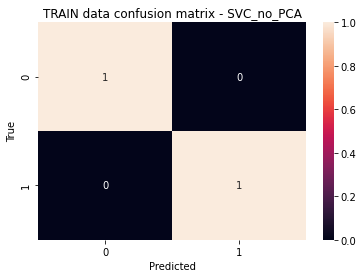

SVC_no_PCA
for TESTING DATA
ROC_AUC Score: 0.7000000000000001
Accuracy Score: 0.7


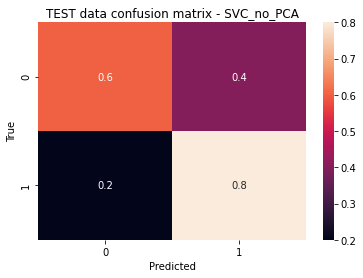

SVC_with_PCA
for TRAINING DATA
ROC_AUC Score: 1.0
Accuracy Score: 1.0


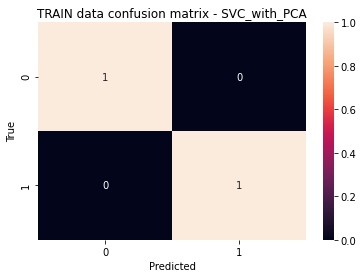

SVC_with_PCA
for TESTING DATA
ROC_AUC Score: 0.7416666666666666
Accuracy Score: 0.7416666666666667


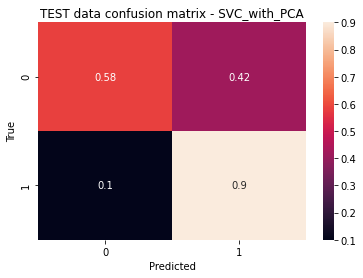

LDA_no_PCA
for TRAINING DATA
ROC_AUC Score: 1.0
Accuracy Score: 1.0


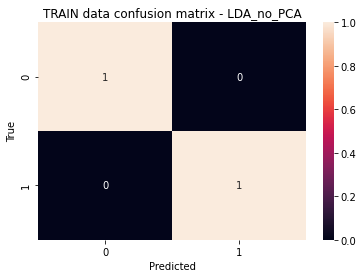

LDA_no_PCA
for TESTING DATA
ROC_AUC Score: 0.6166666666666667
Accuracy Score: 0.6166666666666667


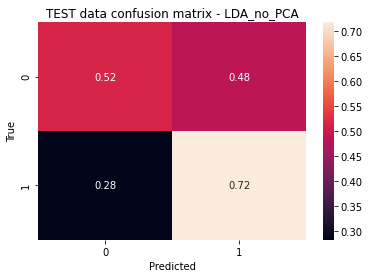

LDA_with_PCA
for TRAINING DATA
ROC_AUC Score: 0.5
Accuracy Score: 0.5


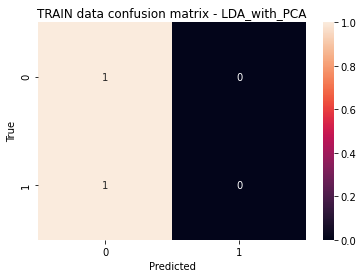

LDA_with_PCA
for TESTING DATA
ROC_AUC Score: 0.3916666666666666
Accuracy Score: 0.39166666666666666


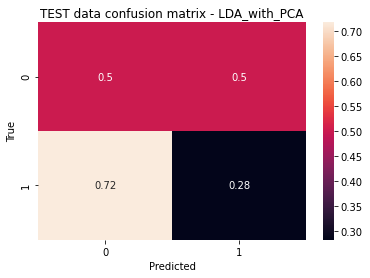

RandomForest_no_PCA
for TRAINING DATA
ROC_AUC Score: 1.0
Accuracy Score: 1.0


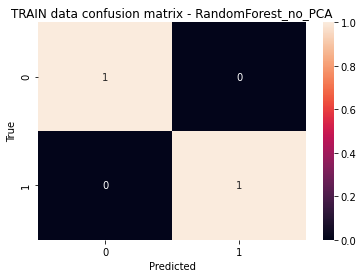

RandomForest_no_PCA
for TESTING DATA
ROC_AUC Score: 0.875
Accuracy Score: 0.875


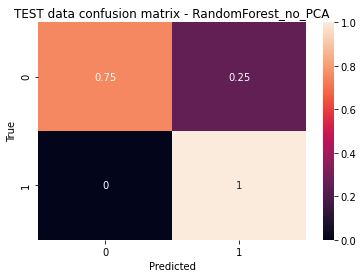

RandomForest_with_PCA
for TRAINING DATA
ROC_AUC Score: 1.0
Accuracy Score: 1.0


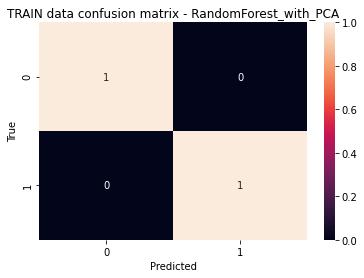

RandomForest_with_PCA
for TESTING DATA
ROC_AUC Score: 0.5583333333333333
Accuracy Score: 0.5583333333333333


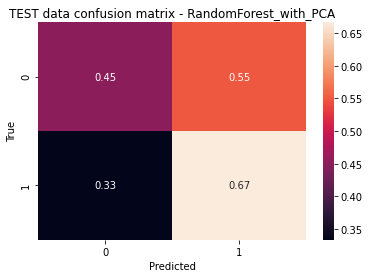

AdaBoost_no_PCA
for TRAINING DATA
ROC_AUC Score: 1.0
Accuracy Score: 1.0


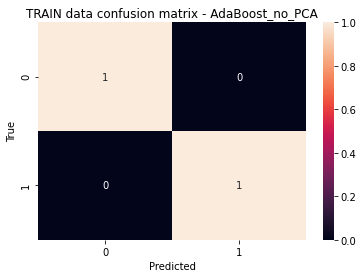

AdaBoost_no_PCA
for TESTING DATA
ROC_AUC Score: 0.8416666666666667
Accuracy Score: 0.8416666666666667


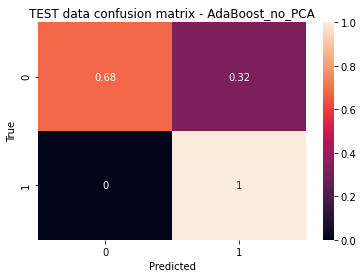

AdaBoost_with_PCA
for TRAINING DATA
ROC_AUC Score: 1.0
Accuracy Score: 1.0


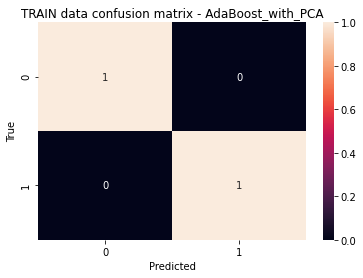

AdaBoost_with_PCA
for TESTING DATA
ROC_AUC Score: 0.625
Accuracy Score: 0.625


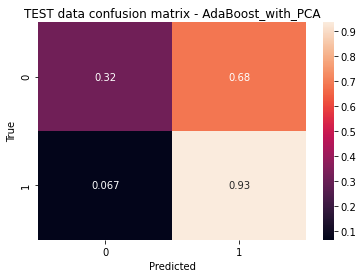

GradientBoosting_no_PCA
for TRAINING DATA
ROC_AUC Score: 1.0
Accuracy Score: 1.0


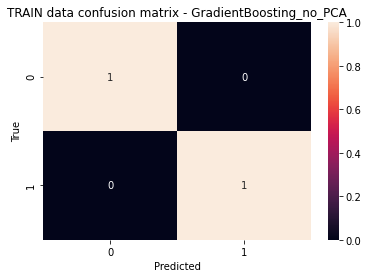

GradientBoosting_no_PCA
for TESTING DATA
ROC_AUC Score: 0.8333333333333334
Accuracy Score: 0.8333333333333333


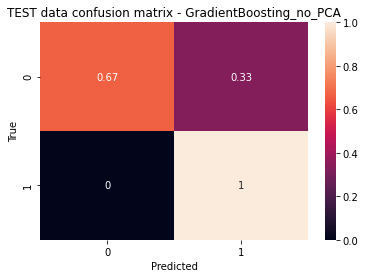

GradientBoosting_with_PCA
for TRAINING DATA
ROC_AUC Score: 1.0
Accuracy Score: 1.0


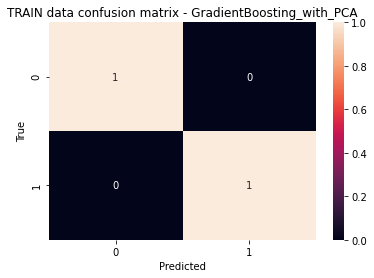

GradientBoosting_with_PCA
for TESTING DATA
ROC_AUC Score: 0.6833333333333332
Accuracy Score: 0.6833333333333333


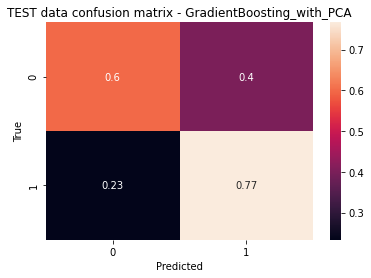

DecisionTree_no_PCA
for TRAINING DATA
ROC_AUC Score: 1.0
Accuracy Score: 1.0


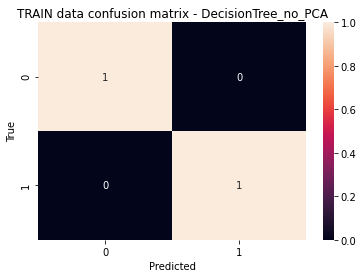

DecisionTree_no_PCA
for TESTING DATA
ROC_AUC Score: 0.7
Accuracy Score: 0.7


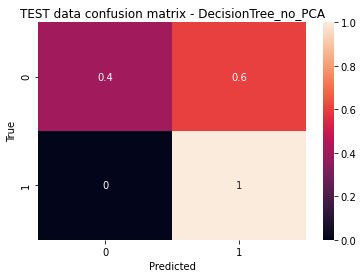

DecisionTree_with_PCA
for TRAINING DATA
ROC_AUC Score: 1.0
Accuracy Score: 1.0


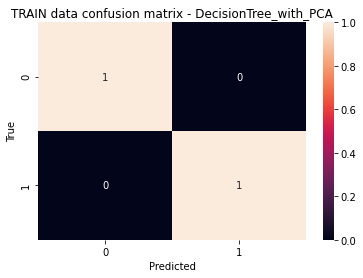

DecisionTree_with_PCA
for TESTING DATA
ROC_AUC Score: 0.5666666666666668
Accuracy Score: 0.5666666666666667


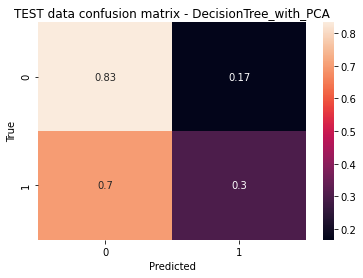

pipeline_name  \
0                  SVC_no_PCA   
1                SVC_with_PCA   
2                  LDA_no_PCA   
3                LDA_with_PCA   
4         RandomForest_no_PCA   
5       RandomForest_with_PCA   
6             AdaBoost_no_PCA   
7           AdaBoost_with_PCA   
8     GradientBoosting_no_PCA   
9   GradientBoosting_with_PCA   
10        DecisionTree_no_PCA   
11      DecisionTree_with_PCA   

                                          named_steps  train_ROC_score  \
0          {'scaler': StandardScaler(), 'est': SVC()}              1.0   
1   {'scaler': StandardScaler(), 'pca': PCA(), 'es...              1.0   
2   {'scaler': StandardScaler(), 'est': LinearDisc...              1.0   
3   {'scaler': StandardScaler(), 'pca': PCA(), 'es...              0.5   
4   {'scaler': StandardScaler(), 'est': RandomFore...              1.0   
5   {'scaler': StandardScaler(), 'pca': PCA(), 'es...              1.0   
6   {'scaler': StandardScaler(), 'est': AdaBoostCl...              1.0   
7   {'scaler': StandardScaler(), 'pca': PCA(), 'es...              1.0   
8   {'scaler': StandardScaler(), 'est': GradientBo...              1.0   
9   {'scaler': StandardScaler(), 'pca': PCA(), 'es...              1.0   
10  {'scaler': StandardScaler(), 'est': DecisionTr...              1.0   
11  {'scaler': StandardScaler(), 'pca': PCA(), 'es...              1.0   

    train_acc_score    train_confusion_matrix  test_ROC_score  test_acc_score  \
0               1.0  [[1.0, 0.0], [0.0, 1.0]]        0.700000        0.700000   
1               1.0  [[1.0, 0.0], [0.0, 1.0]]        0.741667        0.741667   
2               1.0  [[1.0, 0.0], [0.0, 1.0]]        0.616667        0.616667   
3               0.5  [[1.0, 0.0], [1.0, 0.0]]        0.391667        0.391667   
4               1.0  [[1.0, 0.0], [0.0, 1.0]]        0.875000        0.875000   
5               1.0  [[1.0, 0.0], [0.0, 1.0]]        0.558333        0.558333   
6               1.0  [[1.0, 0.0], [0.0, 1.0]]        0.841667        0.841667   
7               1.0  [[1.0, 0.0], [0.0, 1.0]]        0.625000        0.625000   
8               1.0  [[1.0, 0.0], [0.0, 1.0]]        0.833333        0.833333   
9               1.0  [[1.0, 0.0], [0.0, 1.0]]        0.683333        0.683333   
10              1.0  [[1.0, 0.0], [0.0, 1.0]]        0.700000        0.700000   
11              1.0  [[1.0, 0.0], [0.0, 1.0]]        0.566667        0.566667   

                                test_confusion_matrix  
0                            [[0.6, 0.4], [0.2, 0.8]]  
1   [[0.5833333333333334, 0.4166666666666667], [0....  
2   [[0.5166666666666667, 0.48333333333333334], [0...  
3   [[0.5, 0.5], [0.7166666666666667, 0.2833333333...  
4                          [[0.75, 0.25], [0.0, 1.0]]  
5   [[0.45, 0.55], [0.3333333333333333, 0.66666666...  
6   [[0.6833333333333333, 0.31666666666666665], [0...  
7   [[0.31666666666666665, 0.6833333333333333], [0...  
8   [[0.6666666666666666, 0.3333333333333333], [0....  
9   [[0.6, 0.4], [0.23333333333333334, 0.766666666...  
10                           [[0.4, 0.6], [0.0, 1.0]]  
11  [[0.8333333333333334, 0.16666666666666666], [0...

NameError: name 'model_metrics_path' is not defined

In [45]:
model_metrics = []

print("unique target values:",np.unique(y_train))

for pipe_steps, name in zip([pipeline_1a_steps, pipeline_1b_steps, pipeline_2a_steps, pipeline_2b_steps, 
                         pipeline_3a_steps, pipeline_3b_steps, pipeline_4a_steps, pipeline_4b_steps,
                         pipeline_5a_steps, pipeline_5b_steps, pipeline_6a_steps, pipeline_6b_steps],
                         ["SVC_no_PCA","SVC_with_PCA","LDA_no_PCA","LDA_with_PCA",
                          "RandomForest_no_PCA","RandomForest_with_PCA","AdaBoost_no_PCA","AdaBoost_with_PCA",
                "GradientBoosting_no_PCA","GradientBoosting_with_PCA", "DecisionTree_no_PCA",  "DecisionTree_with_PCA"]):
  
  pipe = Pipeline(pipe_steps)
  pipe.fit(X_train, y_train)
  train_predictions = pipe.predict(X_train)
  test_preds = pipe.predict(X_test)

  model_metrics_dict = {'pipeline_name': name, 'named_steps': str(pipe.named_steps)}

  print(name)
  print("for TRAINING DATA")

  model_metrics_dict['train_ROC_score'] = roc_auc_score(y_train, train_predictions)
  model_metrics_dict['train_acc_score'] = balanced_accuracy_score(y_train, train_predictions)
  model_metrics_dict['train_confusion_matrix'] = confusion_matrix(y_train, train_predictions, normalize='true')

  print("ROC_AUC Score:", model_metrics_dict['train_ROC_score'])
  print("Accuracy Score:", model_metrics_dict['train_acc_score'])
  sns.heatmap(model_metrics_dict['train_confusion_matrix'], annot=True)
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.title('TRAIN data confusion matrix - '+name)
  plt.show()

  print(name)
  print("for TESTING DATA")

  model_metrics_dict['test_ROC_score'] = roc_auc_score(y_test, test_preds)
  model_metrics_dict['test_acc_score'] = balanced_accuracy_score(y_test, test_preds)
  model_metrics_dict['test_confusion_matrix'] = confusion_matrix(y_test, test_preds, normalize='true')
  
  print("ROC_AUC Score:", model_metrics_dict['test_ROC_score'] )
  print("Accuracy Score:", model_metrics_dict['test_acc_score'])
  sns.heatmap(model_metrics_dict['test_confusion_matrix'], annot=True)
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.title('TEST data confusion matrix - '+name)
  plt.show()

  model_metrics.append(model_metrics_dict)


model_metrics_df = pd.DataFrame( {'pipeline_name': [metrics['pipeline_name'] for metrics in model_metrics],
                                  'named_steps': [metrics['named_steps'] for metrics in model_metrics],
                                  'train_ROC_score': [metrics['train_ROC_score'] for metrics in model_metrics],
                                  'train_acc_score': [metrics['train_acc_score'] for metrics in model_metrics],
                                  'train_confusion_matrix': [metrics['train_confusion_matrix'] for metrics in model_metrics],
                                  'test_ROC_score': [metrics['test_ROC_score'] for metrics in model_metrics],
                                  'test_acc_score': [metrics['test_acc_score'] for metrics in model_metrics],
                                  'test_confusion_matrix': [metrics['test_confusion_matrix'] for metrics in model_metrics]} )

display(model_metrics_df)

model_metrics_df.to_csv('model_metrics\\M1vM2_experiment_agg_notOptimized_100samplesPerSession.csv')

In [46]:
model_metrics_df.to_csv('model_metrics\\M1vM2_experiment_agg_notOptimized_100samplesPerSession.csv')

RandomForest_no_PCA
for TRAINING DATA
ROC_AUC Score: 1.0
Accuracy Score: 1.0


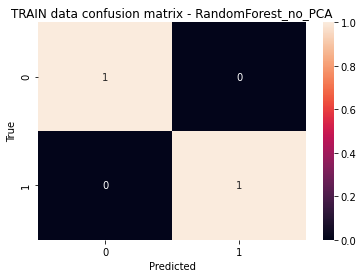

RandomForest_no_PCA
for TESTING DATA
ROC_AUC Score: 0.8583333333333334
Accuracy Score: 0.8583333333333334


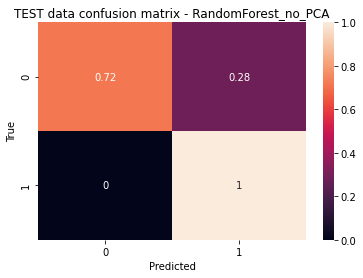

mean_Accelerometer_Z                                  0.023615
mean_Accelerometer_X                                  0.023422
var_power60.0HzCh0                                    0.021041
mean_amplitude60.0HzCh0                               0.020900
var_phaseDifference_phase60.0HzCh0_phase60.0HzCh3     0.019460
                                                        ...   
mean_phaseDifference_phase24.0HzCh1_phase24.0HzCh3    0.000000
mean_phaseDifference_phase24.0HzCh1_phase24.0HzCh2    0.000000
var_amplitude36.0HzCh3                                0.000000
mean_phaseDifference_phase22.0HzCh0_phase22.0HzCh2    0.000000
var_phaseDifference_phase80.0HzCh2_phase80.0HzCh3     0.000000
Length: 1482, dtype: float64
mean_Accelerometer_Z                                  0.023615
mean_Accelerometer_X                                  0.023422
var_power60.0HzCh0                                    0.021041
mean_amplitude60.0HzCh0                               0.020900
var_phaseDifference_phase6

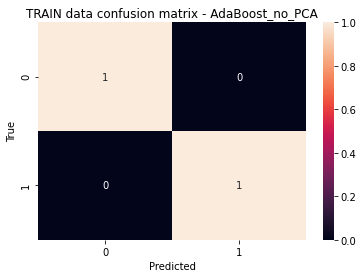

AdaBoost_no_PCA
for TESTING DATA
ROC_AUC Score: 0.8416666666666667
Accuracy Score: 0.8416666666666667


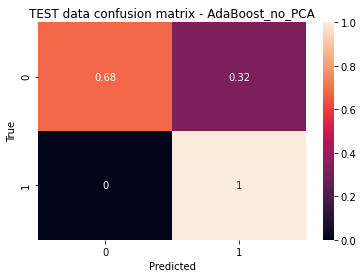

mean_Accelerometer_X                                  0.08
var_phaseDifference_phase60.0HzCh0_phase60.0HzCh3     0.06
var_phaseDifference_phase62.0HzCh0_phase62.0HzCh3     0.06
mean_phaseDifference_phase58.0HzCh0_phase58.0HzCh3    0.04
var_amplitude62.0HzCh0                                0.04
                                                      ... 
mean_phase62.0HzCh3                                   0.00
mean_phase60.0HzCh3                                   0.00
mean_phase58.0HzCh3                                   0.00
mean_phase56.0HzCh3                                   0.00
var_phaseDifference_phase80.0HzCh2_phase80.0HzCh3     0.00
Length: 1482, dtype: float64
mean_Accelerometer_X                                  0.08
var_phaseDifference_phase60.0HzCh0_phase60.0HzCh3     0.06
var_phaseDifference_phase62.0HzCh0_phase62.0HzCh3     0.06
mean_phaseDifference_phase58.0HzCh0_phase58.0HzCh3    0.04
var_amplitude62.0HzCh0                                0.04
mean_Accelerometer_Y       

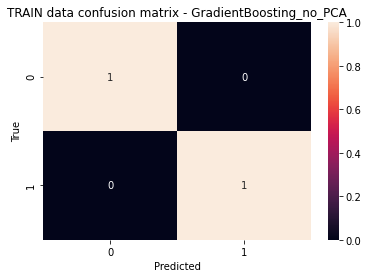

GradientBoosting_no_PCA
for TESTING DATA
ROC_AUC Score: 0.85
Accuracy Score: 0.85


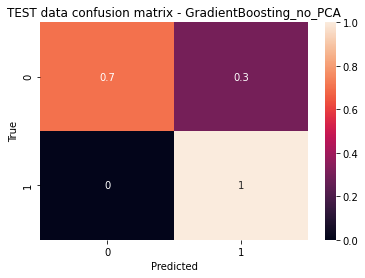

mean_Accelerometer_X                                 2.526275e-01
var_phaseDifference_phase60.0HzCh0_phase60.0HzCh3    1.894172e-01
mean_amplitude58.0HzCh0                              1.230162e-01
var_phase58.0HzCh0                                   1.109842e-01
var_power62.0HzCh0                                   8.815802e-02
                                                         ...     
mean_phase62.0HzCh3                                  0.000000e+00
mean_phase60.0HzCh3                                  0.000000e+00
mean_phase58.0HzCh3                                  0.000000e+00
mean_phase56.0HzCh3                                  0.000000e+00
var_phase28.0HzCh0                                  -9.532674e-19
Length: 1482, dtype: float64
mean_Accelerometer_X                                  0.252628
var_phaseDifference_phase60.0HzCh0_phase60.0HzCh3     0.189417
mean_amplitude58.0HzCh0                               0.123016
var_phase58.0HzCh0                                    0.

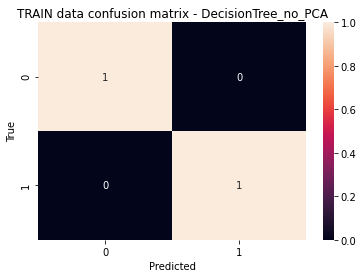

DecisionTree_no_PCA
for TESTING DATA
ROC_AUC Score: 0.7
Accuracy Score: 0.7


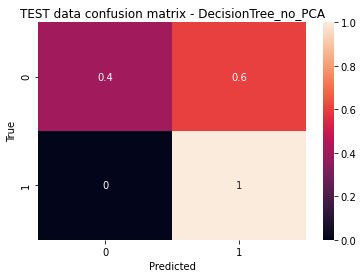

mean_amplitude58.0HzCh0                              0.362678
var_phaseDifference_phase60.0HzCh0_phase60.0HzCh3    0.293952
var_power62.0HzCh0                                   0.184247
var_phaseDifference_phase34.0HzCh2_phase34.0HzCh3    0.054264
mean_Accelerometer_X                                 0.032231
                                                       ...   
mean_phase56.0HzCh3                                  0.000000
mean_phase54.0HzCh3                                  0.000000
mean_phase52.0HzCh3                                  0.000000
mean_phase50.0HzCh3                                  0.000000
var_phaseDifference_phase80.0HzCh2_phase80.0HzCh3    0.000000
Length: 1482, dtype: float64
mean_amplitude58.0HzCh0                               0.362678
var_phaseDifference_phase60.0HzCh0_phase60.0HzCh3     0.293952
var_power62.0HzCh0                                    0.184247
var_phaseDifference_phase34.0HzCh2_phase34.0HzCh3     0.054264
mean_Accelerometer_X                 

In [47]:
for pipe_steps, name in zip([
                         pipeline_3a_steps, pipeline_4a_steps, 
                         pipeline_5a_steps, pipeline_6a_steps],
                         [
                          "RandomForest_no_PCA","AdaBoost_no_PCA",
                          "GradientBoosting_no_PCA", "DecisionTree_no_PCA"]):
  
  pipe = Pipeline(pipe_steps)
  pipe.fit(X_train, y_train)
  train_predictions = pipe.predict(X_train)
  test_preds = pipe.predict(X_test)

  model_metrics_dict = {'pipeline_name': name, 'named_steps': str(pipe.named_steps)}

  print(name)
  print("for TRAINING DATA")

  model_metrics_dict['train_ROC_score'] = roc_auc_score(y_train, train_predictions)
  model_metrics_dict['train_acc_score'] = balanced_accuracy_score(y_train, train_predictions)
  model_metrics_dict['train_confusion_matrix'] = confusion_matrix(y_train, train_predictions, normalize='true')

  print("ROC_AUC Score:", model_metrics_dict['train_ROC_score'])
  print("Accuracy Score:", model_metrics_dict['train_acc_score'])
  sns.heatmap(model_metrics_dict['train_confusion_matrix'], annot=True)
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.title('TRAIN data confusion matrix - '+name)
  plt.show()

  print(name)
  print("for TESTING DATA")

  model_metrics_dict['test_ROC_score'] = roc_auc_score(y_test, test_preds)
  model_metrics_dict['test_acc_score'] = balanced_accuracy_score(y_test, test_preds)
  model_metrics_dict['test_confusion_matrix'] = confusion_matrix(y_test, test_preds, normalize='true')
  
  print("ROC_AUC Score:", model_metrics_dict['test_ROC_score'] )
  print("Accuracy Score:", model_metrics_dict['test_acc_score'])
  sns.heatmap(model_metrics_dict['test_confusion_matrix'], annot=True)
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.title('TEST data confusion matrix - '+name)
  plt.show()

  feat_import = pd.Series(pipe.named_steps.est.feature_importances_, index= dataset.drop(['TARGET','ORIGINAL_ROW_NUM','ORIGINAL_FILE_NUM'], axis=1).columns)


  print(feat_import.sort_values(ascending=False))

  print(feat_import.sort_values(ascending=False).iloc[:30])

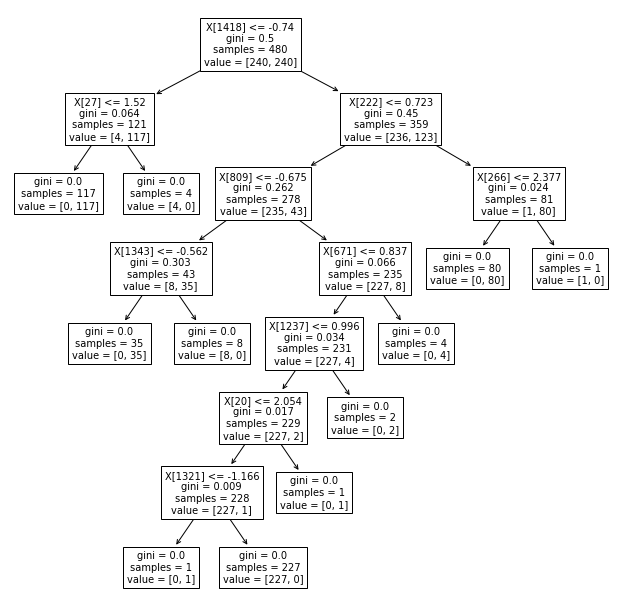

In [48]:
from sklearn.tree import plot_tree

plt.figure(figsize=(11,11))
plot_tree(pipe.named_steps.est)
plt.show()

In [49]:
print('X[1418]:', temp[1418])

print('X[27]:', temp[27])
print('X[222]:', temp[222])

print('X[809]:', temp[809])
print('X[266]:', temp[266])

print('X[1343]:', temp[1343])
print('X[671]:', temp[671])

print('X[1237]:', temp[1237])
print('X[20]:', temp[20])

print('X[1321]:', temp[1321])


#print('X[]:', temp[])
#print('X[]:', temp[])

X[1418]: var_phaseDifference_phase60.0HzCh0_phase60.0HzCh3
X[27]: mean_Accelerometer_X
X[222]: mean_amplitude58.0HzCh0
X[809]: var_power62.0HzCh0
X[266]: mean_amplitude68.0HzCh1
X[1343]: var_phaseDifference_phase34.0HzCh2_phase34.0HzCh3
X[671]: mean_phaseDifference_phase58.0HzCh0_phase58.0HzCh3
X[1237]: var_phase60.0HzCh3
X[20]: mean_RAW_TP9
X[1321]: var_phaseDifference_phase28.0HzCh0_phase28.0HzCh2


### Experiment 2 results:
* The high feature importance of accelerometer and gyroscope features, along with the features related to instability of Channels 0 and 3 (TP9 and TP10), suggest that physical movement and noise artifacts are driving the effect here.
* This suggests that either...
    * The effect is based on spurious correlations related to small sample size, or
    * Action thinking results in imperceptible muscle activity that can be picked up by this kind of algorithm.

* As things stand now, this effect should be considered spurious. However, further experimentation should be conducted.


# <a name="exp3">  Experiment 3 - M1 (baseline) vs M3 (physical action) </a >

[back to top](#TOC)

In [50]:
 # M1 vs. M3
M1_session0 = df.loc[df.TARGET==1].loc[df.ORIGINAL_FILE_NUM==0]
M1_session1 = df.loc[df.TARGET==1].loc[df.ORIGINAL_FILE_NUM==1]
M1_session2 = df.loc[df.TARGET==1].loc[df.ORIGINAL_FILE_NUM==2]

M3_session0 = df.loc[df.TARGET==3].loc[df.ORIGINAL_FILE_NUM==0]
M3_session1 = df.loc[df.TARGET==3].loc[df.ORIGINAL_FILE_NUM==1]
M3_session2 = df.loc[df.TARGET==3].loc[df.ORIGINAL_FILE_NUM==2]
print(len(M1_session0),
      len(M1_session1),
      len(M1_session2),
      len(M3_session0),
      len(M3_session1),
      len(M3_session2))

347 383 448 116 170 230


In [67]:
outer1, outer2, outer3, outer4 = [],[],[],[]

for dataset in [M1_session0.iloc[:100], M1_session1.iloc[:100], M1_session2.iloc[:100], M3_session0.iloc[:100], M3_session1.iloc[:100], M3_session2.iloc[:100]]:
  y = np.array(dataset['TARGET']).reshape(-1, 1)
  X = np.array(dataset.drop(['TARGET','ORIGINAL_ROW_NUM','ORIGINAL_FILE_NUM'], axis=1))

  print('y.shape',y.shape)

  X_train_subset, X_test_subset, y_train_subset, y_test_subset = train_test_split(X, y, test_size=0.2, shuffle=False)

  outer1.append(X_train_subset)
  outer2.append(X_test_subset)
  outer3.append(y_train_subset)
  outer4.append(y_test_subset)

X_train = np.vstack(outer1)
X_test = np.vstack(outer2)
y_train = np.vstack(outer3).ravel()
y_test = np.vstack(outer4).ravel()

print('X_train.shape', X_train.shape)
print('X_test.shape', X_test.shape)
print('y_train.shape',y_train.shape)
print('y_test.shape',y_test.shape)

y.shape (100, 1)
y.shape (100, 1)
y.shape (100, 1)
y.shape (100, 1)
y.shape (100, 1)
y.shape (100, 1)
X_train.shape (480, 1482)
X_test.shape (120, 1482)
y_train.shape (480,)
y_test.shape (120,)


unique target values: [1 3]
SVC_no_PCA
for TRAINING DATA
ROC_AUC Score: 1.0
Accuracy Score: 1.0


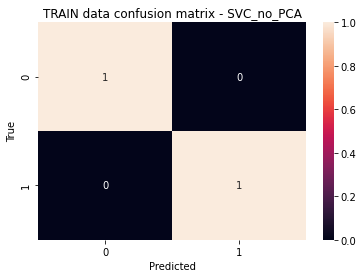

SVC_no_PCA
for TESTING DATA
ROC_AUC Score: 0.7333333333333334
Accuracy Score: 0.7333333333333334


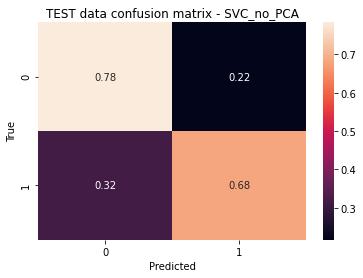

SVC_with_PCA
for TRAINING DATA
ROC_AUC Score: 1.0
Accuracy Score: 1.0


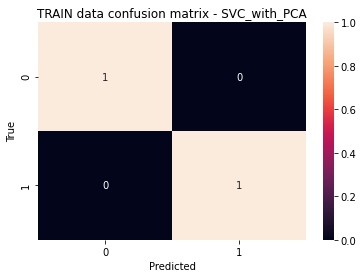

SVC_with_PCA
for TESTING DATA
ROC_AUC Score: 0.75
Accuracy Score: 0.75


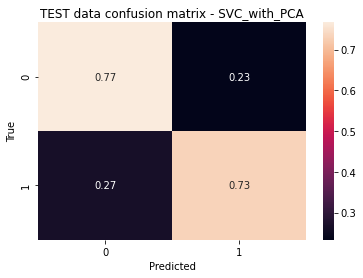

LDA_no_PCA
for TRAINING DATA
ROC_AUC Score: 1.0
Accuracy Score: 1.0


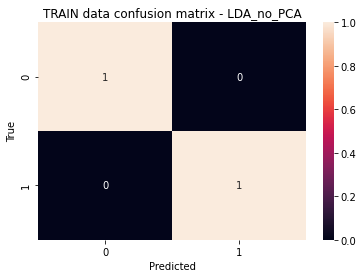

LDA_no_PCA
for TESTING DATA
ROC_AUC Score: 0.8166666666666667
Accuracy Score: 0.8166666666666667


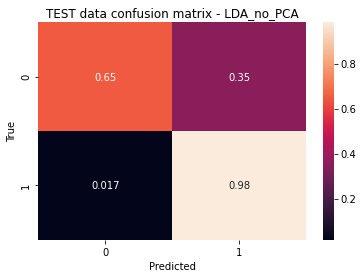

LDA_with_PCA
for TRAINING DATA
ROC_AUC Score: 0.5
Accuracy Score: 0.5


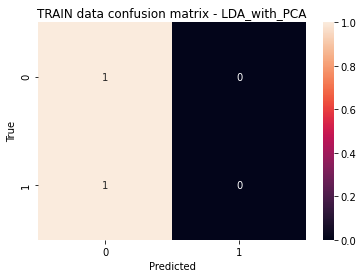

LDA_with_PCA
for TESTING DATA
ROC_AUC Score: 0.7000000000000001
Accuracy Score: 0.7


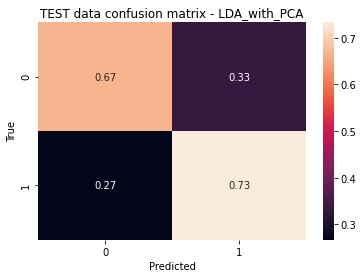

RandomForest_no_PCA
for TRAINING DATA
ROC_AUC Score: 1.0
Accuracy Score: 1.0


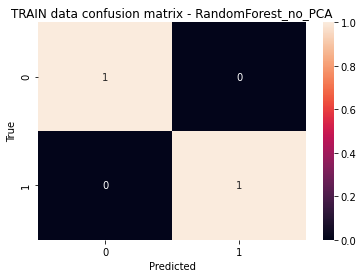

RandomForest_no_PCA
for TESTING DATA
ROC_AUC Score: 0.9583333333333333
Accuracy Score: 0.9583333333333333


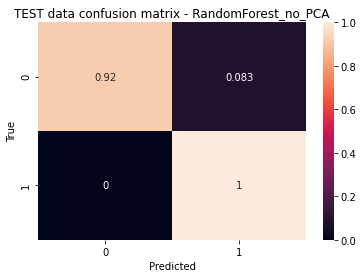

RandomForest_with_PCA
for TRAINING DATA
ROC_AUC Score: 1.0
Accuracy Score: 1.0


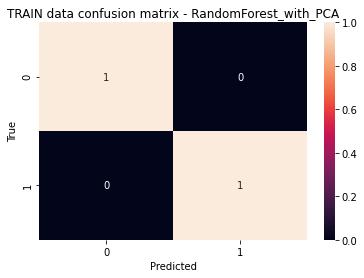

RandomForest_with_PCA
for TESTING DATA
ROC_AUC Score: 0.5166666666666667
Accuracy Score: 0.5166666666666667


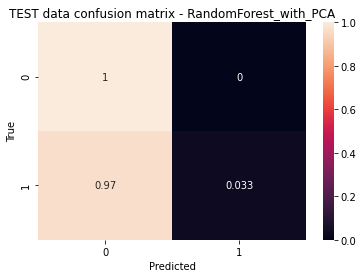

AdaBoost_no_PCA
for TRAINING DATA
ROC_AUC Score: 1.0
Accuracy Score: 1.0


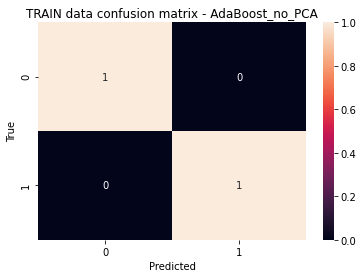

AdaBoost_no_PCA
for TESTING DATA
ROC_AUC Score: 0.8333333333333334
Accuracy Score: 0.8333333333333333


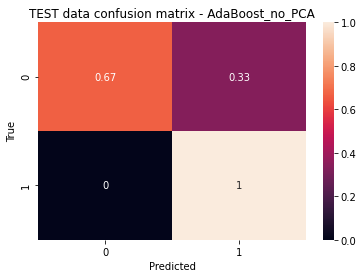

AdaBoost_with_PCA
for TRAINING DATA
ROC_AUC Score: 1.0
Accuracy Score: 1.0


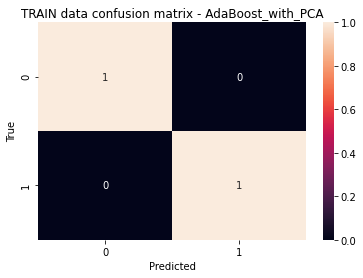

AdaBoost_with_PCA
for TESTING DATA
ROC_AUC Score: 0.5416666666666666
Accuracy Score: 0.5416666666666666


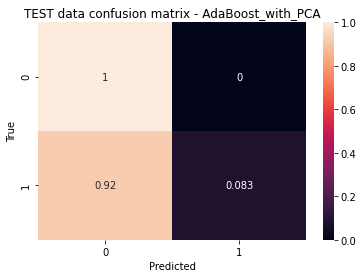

GradientBoosting_no_PCA
for TRAINING DATA
ROC_AUC Score: 1.0
Accuracy Score: 1.0


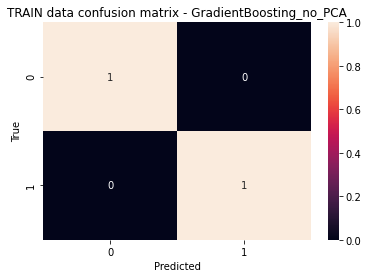

GradientBoosting_no_PCA
for TESTING DATA
ROC_AUC Score: 0.8666666666666667
Accuracy Score: 0.8666666666666667


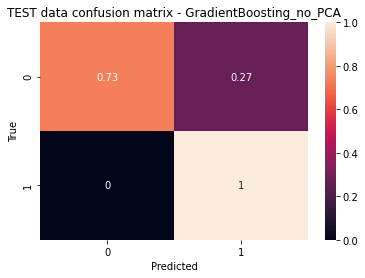

GradientBoosting_with_PCA
for TRAINING DATA
ROC_AUC Score: 1.0
Accuracy Score: 1.0


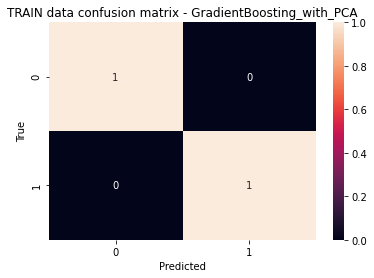

GradientBoosting_with_PCA
for TESTING DATA
ROC_AUC Score: 0.5
Accuracy Score: 0.5


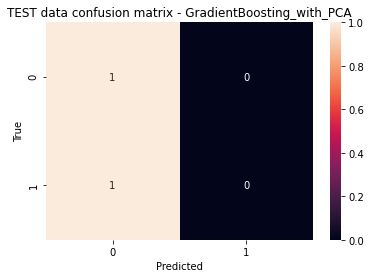

DecisionTree_no_PCA
for TRAINING DATA
ROC_AUC Score: 1.0
Accuracy Score: 1.0


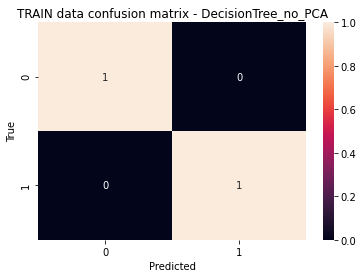

DecisionTree_no_PCA
for TESTING DATA
ROC_AUC Score: 0.7749999999999999
Accuracy Score: 0.7749999999999999


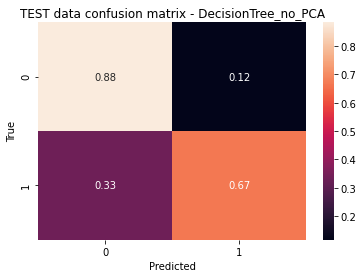

DecisionTree_with_PCA
for TRAINING DATA
ROC_AUC Score: 1.0
Accuracy Score: 1.0


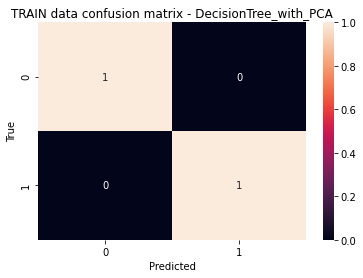

DecisionTree_with_PCA
for TESTING DATA
ROC_AUC Score: 0.7
Accuracy Score: 0.7


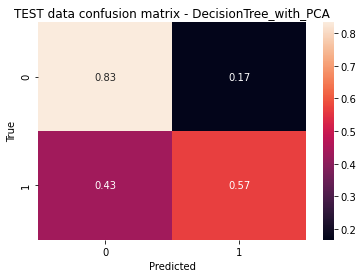

pipeline_name  \
0                  SVC_no_PCA   
1                SVC_with_PCA   
2                  LDA_no_PCA   
3                LDA_with_PCA   
4         RandomForest_no_PCA   
5       RandomForest_with_PCA   
6             AdaBoost_no_PCA   
7           AdaBoost_with_PCA   
8     GradientBoosting_no_PCA   
9   GradientBoosting_with_PCA   
10        DecisionTree_no_PCA   
11      DecisionTree_with_PCA   

                                          named_steps  train_ROC_score  \
0          {'scaler': StandardScaler(), 'est': SVC()}              1.0   
1   {'scaler': StandardScaler(), 'pca': PCA(), 'es...              1.0   
2   {'scaler': StandardScaler(), 'est': LinearDisc...              1.0   
3   {'scaler': StandardScaler(), 'pca': PCA(), 'es...              0.5   
4   {'scaler': StandardScaler(), 'est': RandomFore...              1.0   
5   {'scaler': StandardScaler(), 'pca': PCA(), 'es...              1.0   
6   {'scaler': StandardScaler(), 'est': AdaBoostCl...              1.0   
7   {'scaler': StandardScaler(), 'pca': PCA(), 'es...              1.0   
8   {'scaler': StandardScaler(), 'est': GradientBo...              1.0   
9   {'scaler': StandardScaler(), 'pca': PCA(), 'es...              1.0   
10  {'scaler': StandardScaler(), 'est': DecisionTr...              1.0   
11  {'scaler': StandardScaler(), 'pca': PCA(), 'es...              1.0   

    train_acc_score    train_confusion_matrix  test_ROC_score  test_acc_score  \
0               1.0  [[1.0, 0.0], [0.0, 1.0]]        0.733333        0.733333   
1               1.0  [[1.0, 0.0], [0.0, 1.0]]        0.750000        0.750000   
2               1.0  [[1.0, 0.0], [0.0, 1.0]]        0.816667        0.816667   
3               0.5  [[1.0, 0.0], [1.0, 0.0]]        0.700000        0.700000   
4               1.0  [[1.0, 0.0], [0.0, 1.0]]        0.958333        0.958333   
5               1.0  [[1.0, 0.0], [0.0, 1.0]]        0.516667        0.516667   
6               1.0  [[1.0, 0.0], [0.0, 1.0]]        0.833333        0.833333   
7               1.0  [[1.0, 0.0], [0.0, 1.0]]        0.541667        0.541667   
8               1.0  [[1.0, 0.0], [0.0, 1.0]]        0.866667        0.866667   
9               1.0  [[1.0, 0.0], [0.0, 1.0]]        0.500000        0.500000   
10              1.0  [[1.0, 0.0], [0.0, 1.0]]        0.775000        0.775000   
11              1.0  [[1.0, 0.0], [0.0, 1.0]]        0.700000        0.700000   

                                test_confusion_matrix  
0   [[0.7833333333333333, 0.21666666666666667], [0...  
1   [[0.7666666666666667, 0.23333333333333334], [0...  
2   [[0.65, 0.35], [0.016666666666666666, 0.983333...  
3   [[0.6666666666666666, 0.3333333333333333], [0....  
4   [[0.9166666666666666, 0.08333333333333333], [0...  
5   [[1.0, 0.0], [0.9666666666666667, 0.0333333333...  
6   [[0.6666666666666666, 0.3333333333333333], [0....  
7   [[1.0, 0.0], [0.9166666666666666, 0.0833333333...  
8   [[0.7333333333333333, 0.26666666666666666], [0...  
9                            [[1.0, 0.0], [1.0, 0.0]]  
10  [[0.8833333333333333, 0.11666666666666667], [0...  
11  [[0.8333333333333334, 0.16666666666666666], [0...

In [68]:
model_metrics = []

print("unique target values:",np.unique(y_train))

for pipe_steps, name in zip([pipeline_1a_steps, pipeline_1b_steps, pipeline_2a_steps, pipeline_2b_steps, 
                         pipeline_3a_steps, pipeline_3b_steps, pipeline_4a_steps, pipeline_4b_steps,
                         pipeline_5a_steps, pipeline_5b_steps, pipeline_6a_steps, pipeline_6b_steps],
                         ["SVC_no_PCA","SVC_with_PCA","LDA_no_PCA","LDA_with_PCA",
                          "RandomForest_no_PCA","RandomForest_with_PCA","AdaBoost_no_PCA","AdaBoost_with_PCA",
                "GradientBoosting_no_PCA","GradientBoosting_with_PCA", "DecisionTree_no_PCA",  "DecisionTree_with_PCA"]):
  
  pipe = Pipeline(pipe_steps)
  pipe.fit(X_train, y_train)
  train_predictions = pipe.predict(X_train)
  test_preds = pipe.predict(X_test)

  model_metrics_dict = {'pipeline_name': name, 'named_steps': str(pipe.named_steps)}

  print(name)
  print("for TRAINING DATA")

  model_metrics_dict['train_ROC_score'] = roc_auc_score(y_train, train_predictions)
  model_metrics_dict['train_acc_score'] = balanced_accuracy_score(y_train, train_predictions)
  model_metrics_dict['train_confusion_matrix'] = confusion_matrix(y_train, train_predictions, normalize='true')

  print("ROC_AUC Score:", model_metrics_dict['train_ROC_score'])
  print("Accuracy Score:", model_metrics_dict['train_acc_score'])
  sns.heatmap(model_metrics_dict['train_confusion_matrix'], annot=True)
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.title('TRAIN data confusion matrix - '+name)
  plt.show()

  print(name)
  print("for TESTING DATA")

  model_metrics_dict['test_ROC_score'] = roc_auc_score(y_test, test_preds)
  model_metrics_dict['test_acc_score'] = balanced_accuracy_score(y_test, test_preds)
  model_metrics_dict['test_confusion_matrix'] = confusion_matrix(y_test, test_preds, normalize='true')
  
  print("ROC_AUC Score:", model_metrics_dict['test_ROC_score'] )
  print("Accuracy Score:", model_metrics_dict['test_acc_score'])
  sns.heatmap(model_metrics_dict['test_confusion_matrix'], annot=True)
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.title('TEST data confusion matrix - '+name)
  plt.show()

  model_metrics.append(model_metrics_dict)


model_metrics_df = pd.DataFrame( {'pipeline_name': [metrics['pipeline_name'] for metrics in model_metrics],
                                  'named_steps': [metrics['named_steps'] for metrics in model_metrics],
                                  'train_ROC_score': [metrics['train_ROC_score'] for metrics in model_metrics],
                                  'train_acc_score': [metrics['train_acc_score'] for metrics in model_metrics],
                                  'train_confusion_matrix': [metrics['train_confusion_matrix'] for metrics in model_metrics],
                                  'test_ROC_score': [metrics['test_ROC_score'] for metrics in model_metrics],
                                  'test_acc_score': [metrics['test_acc_score'] for metrics in model_metrics],
                                  'test_confusion_matrix': [metrics['test_confusion_matrix'] for metrics in model_metrics]} )

display(model_metrics_df)

model_metrics_df.to_csv('model_metrics\\M1vM3_experiment_agg_notOptimized_100samplesPerSession.csv')

RandomForest_no_PCA
for TRAINING DATA
ROC_AUC Score: 1.0
Accuracy Score: 1.0


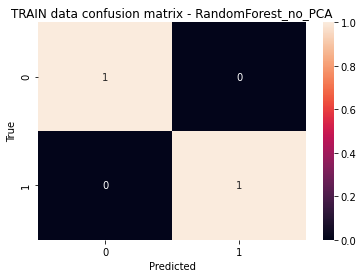

RandomForest_no_PCA
for TESTING DATA
ROC_AUC Score: 0.9916666666666666
Accuracy Score: 0.9916666666666667


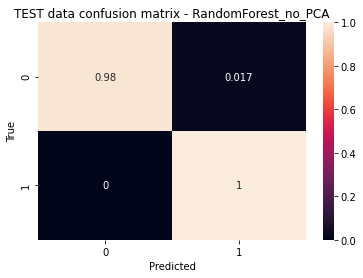

var_Accelerometer_Y                                   0.048230
mean_Accelerometer_X                                  0.046693
var_Gyro_Z                                            0.037279
mean_Accelerometer_Z                                  0.032886
var_phase60.0HzCh3                                    0.021521
                                                        ...   
mean_phaseDifference_phase50.0HzCh1_phase50.0HzCh3    0.000000
mean_phaseDifference_phase52.0HzCh0_phase52.0HzCh1    0.000000
mean_phaseDifference_phase52.0HzCh0_phase52.0HzCh2    0.000000
mean_phaseDifference_phase52.0HzCh0_phase52.0HzCh3    0.000000
var_phaseDifference_phase80.0HzCh2_phase80.0HzCh3     0.000000
Length: 1482, dtype: float64
var_Accelerometer_Y                                   0.048230
mean_Accelerometer_X                                  0.046693
var_Gyro_Z                                            0.037279
mean_Accelerometer_Z                                  0.032886
var_phase60.0HzCh3        

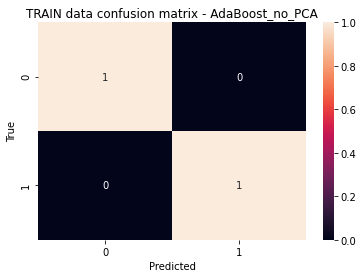

AdaBoost_no_PCA
for TESTING DATA
ROC_AUC Score: 0.8333333333333334
Accuracy Score: 0.8333333333333333


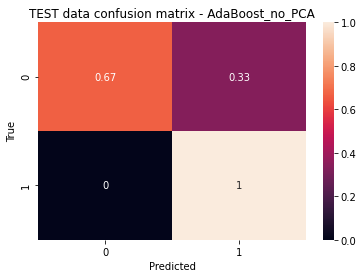

mean_Accelerometer_X                                 0.72
mean_Accelerometer_Z                                 0.26
var_Gyro_Z                                           0.02
mean_Delta_TP9                                       0.00
var_amplitude44.0HzCh1                               0.00
                                                     ... 
mean_phase54.0HzCh3                                  0.00
mean_phase52.0HzCh3                                  0.00
mean_phase50.0HzCh3                                  0.00
mean_phase48.0HzCh3                                  0.00
var_phaseDifference_phase80.0HzCh2_phase80.0HzCh3    0.00
Length: 1482, dtype: float64
mean_Accelerometer_X      0.72
mean_Accelerometer_Z      0.26
var_Gyro_Z                0.02
mean_Delta_TP9            0.00
var_amplitude44.0HzCh1    0.00
var_amplitude40.0HzCh1    0.00
var_amplitude38.0HzCh1    0.00
var_amplitude36.0HzCh1    0.00
var_amplitude34.0HzCh1    0.00
var_amplitude32.0HzCh1    0.00
var_amplitude30.0HzCh1 

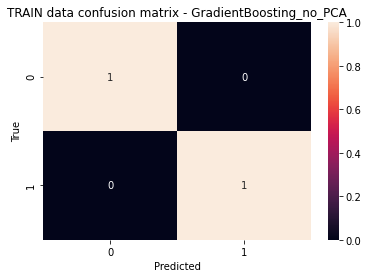

GradientBoosting_no_PCA
for TESTING DATA
ROC_AUC Score: 0.8583333333333334
Accuracy Score: 0.8583333333333334


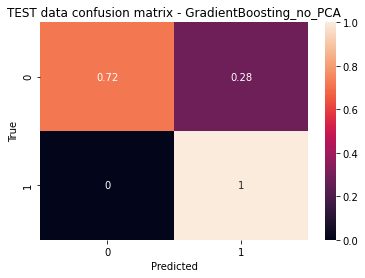

var_Gyro_Z                                            0.727947
mean_Accelerometer_X                                  0.069183
mean_Accelerometer_Z                                  0.055364
mean_phaseDifference_phase62.0HzCh0_phase62.0HzCh3    0.038017
var_Accelerometer_Z                                   0.029711
                                                        ...   
mean_phaseDifference_phase6.0HzCh2_phase6.0HzCh3      0.000000
mean_phaseDifference_phase6.0HzCh1_phase6.0HzCh3      0.000000
mean_phaseDifference_phase6.0HzCh1_phase6.0HzCh2      0.000000
mean_phaseDifference_phase6.0HzCh0_phase6.0HzCh3      0.000000
var_phaseDifference_phase80.0HzCh2_phase80.0HzCh3     0.000000
Length: 1482, dtype: float64
var_Gyro_Z                                            0.727947
mean_Accelerometer_X                                  0.069183
mean_Accelerometer_Z                                  0.055364
mean_phaseDifference_phase62.0HzCh0_phase62.0HzCh3    0.038017
var_Accelerometer_Z       

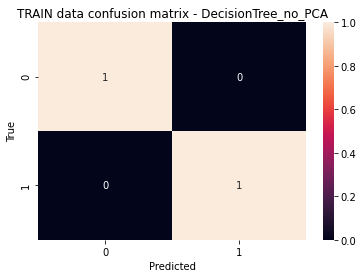

DecisionTree_no_PCA
for TESTING DATA
ROC_AUC Score: 0.875
Accuracy Score: 0.875


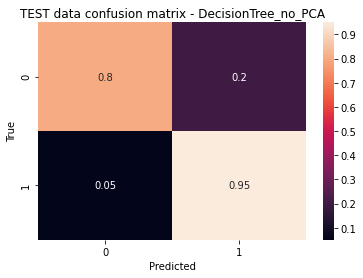

var_Gyro_Z                                            0.730222
mean_Accelerometer_X                                  0.127368
mean_phaseDifference_phase62.0HzCh0_phase62.0HzCh3    0.061424
var_phaseDifference_phase6.0HzCh0_phase6.0HzCh3       0.032754
mean_amplitude58.0HzCh0                               0.024217
                                                        ...   
mean_phase54.0HzCh3                                   0.000000
mean_phase52.0HzCh3                                   0.000000
mean_phase50.0HzCh3                                   0.000000
mean_phase48.0HzCh3                                   0.000000
var_phaseDifference_phase80.0HzCh2_phase80.0HzCh3     0.000000
Length: 1482, dtype: float64
var_Gyro_Z                                            0.730222
mean_Accelerometer_X                                  0.127368
mean_phaseDifference_phase62.0HzCh0_phase62.0HzCh3    0.061424
var_phaseDifference_phase6.0HzCh0_phase6.0HzCh3       0.032754
mean_amplitude58.0HzCh0   

In [53]:
for pipe_steps, name in zip([
                         pipeline_3a_steps, pipeline_4a_steps, 
                         pipeline_5a_steps, pipeline_6a_steps],
                         [
                          "RandomForest_no_PCA","AdaBoost_no_PCA",
                          "GradientBoosting_no_PCA", "DecisionTree_no_PCA"]):
  
  pipe = Pipeline(pipe_steps)
  pipe.fit(X_train, y_train)
  train_predictions = pipe.predict(X_train)
  test_preds = pipe.predict(X_test)

  model_metrics_dict = {'pipeline_name': name, 'named_steps': str(pipe.named_steps)}

  print(name)
  print("for TRAINING DATA")

  model_metrics_dict['train_ROC_score'] = roc_auc_score(y_train, train_predictions)
  model_metrics_dict['train_acc_score'] = balanced_accuracy_score(y_train, train_predictions)
  model_metrics_dict['train_confusion_matrix'] = confusion_matrix(y_train, train_predictions, normalize='true')

  print("ROC_AUC Score:", model_metrics_dict['train_ROC_score'])
  print("Accuracy Score:", model_metrics_dict['train_acc_score'])
  sns.heatmap(model_metrics_dict['train_confusion_matrix'], annot=True)
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.title('TRAIN data confusion matrix - '+name)
  plt.show()

  print(name)
  print("for TESTING DATA")

  model_metrics_dict['test_ROC_score'] = roc_auc_score(y_test, test_preds)
  model_metrics_dict['test_acc_score'] = balanced_accuracy_score(y_test, test_preds)
  model_metrics_dict['test_confusion_matrix'] = confusion_matrix(y_test, test_preds, normalize='true')
  
  print("ROC_AUC Score:", model_metrics_dict['test_ROC_score'] )
  print("Accuracy Score:", model_metrics_dict['test_acc_score'])
  sns.heatmap(model_metrics_dict['test_confusion_matrix'], annot=True)
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.title('TEST data confusion matrix - '+name)
  plt.show()

  feat_import = pd.Series(pipe.named_steps.est.feature_importances_, index= dataset.drop(['TARGET','ORIGINAL_ROW_NUM','ORIGINAL_FILE_NUM'], axis=1).columns)


  print(feat_import.sort_values(ascending=False))

  print(feat_import.sort_values(ascending=False).iloc[:30])

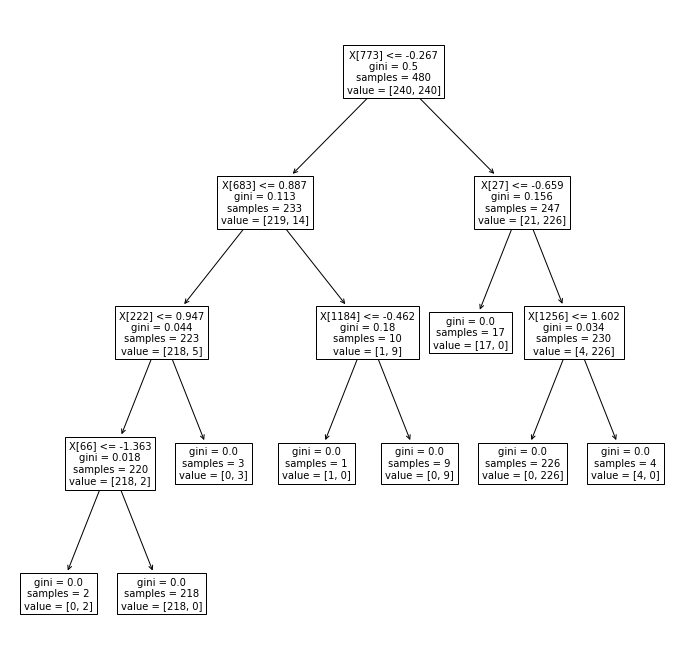

In [55]:
from sklearn.tree import plot_tree

plt.figure(figsize=(12,12))
plot_tree(pipe.named_steps.est)
plt.show()

In [56]:
print('X[773]:', temp[773])
print('X[683]:', temp[683])

print('X[27]:', temp[27])
print('X[222]:', temp[222])

print('X[1184]:', temp[1184])
print('X[1256]:', temp[1256])

print('X[66]:', temp[66])

#print('X[]:', temp[])
#print('X[]:', temp[])

X[773]: var_Gyro_Z
X[683]: mean_phaseDifference_phase62.0HzCh0_phase62.0HzCh3
X[27]: mean_Accelerometer_X
X[222]: mean_amplitude58.0HzCh0
X[1184]: var_phase32.0HzCh2
X[1256]: var_phaseDifference_phase6.0HzCh0_phase6.0HzCh3
X[66]: mean_power58.0HzCh0


### Experiment 3 results:
* Like experiment 2, the discrimination here is based on movement. For example, the decision tree relies most heavily on the gyroscope and the accelerometer.

# <a name="exp4">  Experiment 4: M1 (baseline) vs M4 (attention on somatosensations) </a >

[back to top](#TOC)

In [8]:
 # M1 vs. M4
M1_session0 = df.loc[df.TARGET==1].loc[df.ORIGINAL_FILE_NUM==0]
M1_session1 = df.loc[df.TARGET==1].loc[df.ORIGINAL_FILE_NUM==1]
M1_session2 = df.loc[df.TARGET==1].loc[df.ORIGINAL_FILE_NUM==2]

M4_session0 = df.loc[df.TARGET==4].loc[df.ORIGINAL_FILE_NUM==0]
M4_session1 = df.loc[df.TARGET==4].loc[df.ORIGINAL_FILE_NUM==1]
M4_session2 = df.loc[df.TARGET==4].loc[df.ORIGINAL_FILE_NUM==2]
print(len(M1_session0),
      len(M1_session1),
      len(M1_session2),
      len(M4_session0),
      len(M4_session1),
      len(M4_session2))

AttributeError: 'DataFrame' object has no attribute 'TARGET'

In [70]:
outer1, outer2, outer3, outer4 = [],[],[],[]

for dataset in [M1_session0.iloc[:169], M1_session1.iloc[:169], M1_session2.iloc[:169], M4_session0.iloc[:169], M4_session1.iloc[:169], M4_session2.iloc[:169]]:
  y = np.array(dataset['TARGET']).reshape(-1, 1)
  X = np.array(dataset.drop(['TARGET','ORIGINAL_ROW_NUM','ORIGINAL_FILE_NUM'], axis=1))

  print('y.shape',y.shape)

  X_train_subset, X_test_subset, y_train_subset, y_test_subset = train_test_split(X, y, test_size=0.2, shuffle=False)

  outer1.append(X_train_subset)
  outer2.append(X_test_subset)
  outer3.append(y_train_subset)
  outer4.append(y_test_subset)

X_train = np.vstack(outer1)
X_test = np.vstack(outer2)
y_train = np.vstack(outer3).ravel()
y_test = np.vstack(outer4).ravel()

print('X_train.shape', X_train.shape)
print('X_test.shape', X_test.shape)
print('y_train.shape',y_train.shape)
print('y_test.shape',y_test.shape)

y.shape (169, 1)
y.shape (169, 1)
y.shape (169, 1)
y.shape (169, 1)
y.shape (169, 1)
y.shape (169, 1)
X_train.shape (810, 1482)
X_test.shape (204, 1482)
y_train.shape (810,)
y_test.shape (204,)


unique target values: [1 4]
SVC_no_PCA
for TRAINING DATA
ROC_AUC Score: 1.0
Accuracy Score: 1.0


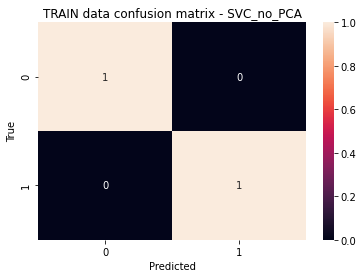

SVC_no_PCA
for TESTING DATA
ROC_AUC Score: 0.7401960784313726
Accuracy Score: 0.7401960784313726


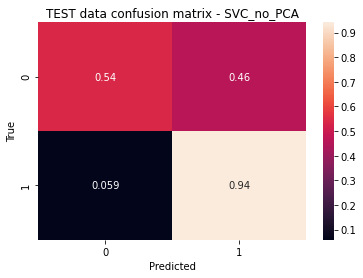

SVC_with_PCA
for TRAINING DATA
ROC_AUC Score: 1.0
Accuracy Score: 1.0


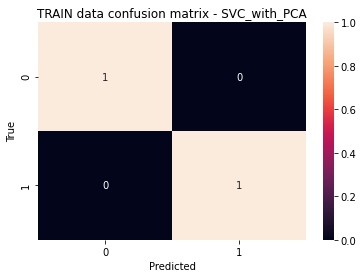

SVC_with_PCA
for TESTING DATA
ROC_AUC Score: 0.7450980392156863
Accuracy Score: 0.7450980392156863


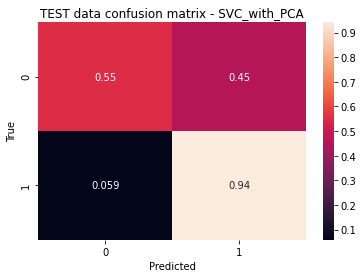

LDA_no_PCA
for TRAINING DATA
ROC_AUC Score: 1.0
Accuracy Score: 1.0


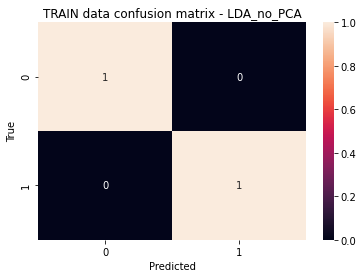

LDA_no_PCA
for TESTING DATA
ROC_AUC Score: 0.5637254901960785
Accuracy Score: 0.5637254901960784


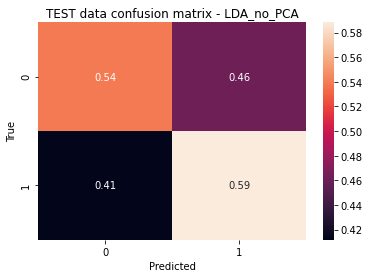

LDA_with_PCA
for TRAINING DATA
ROC_AUC Score: 0.5
Accuracy Score: 0.5


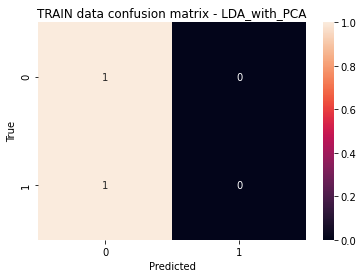

LDA_with_PCA
for TESTING DATA
ROC_AUC Score: 0.5588235294117647
Accuracy Score: 0.5588235294117647


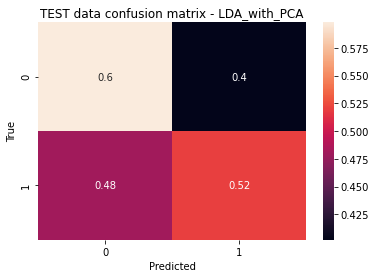

RandomForest_no_PCA
for TRAINING DATA
ROC_AUC Score: 1.0
Accuracy Score: 1.0


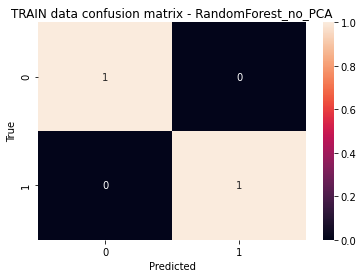

RandomForest_no_PCA
for TESTING DATA
ROC_AUC Score: 0.6519607843137254
Accuracy Score: 0.6519607843137254


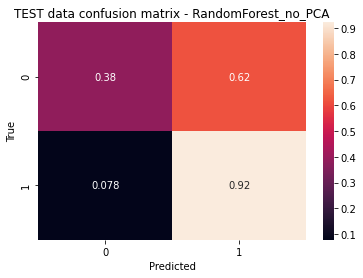

RandomForest_with_PCA
for TRAINING DATA
ROC_AUC Score: 1.0
Accuracy Score: 1.0


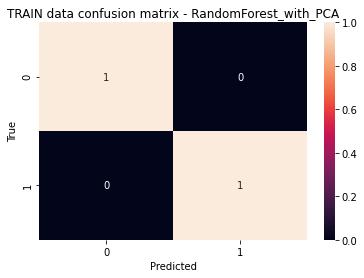

RandomForest_with_PCA
for TESTING DATA
ROC_AUC Score: 0.46078431372549017
Accuracy Score: 0.4607843137254902


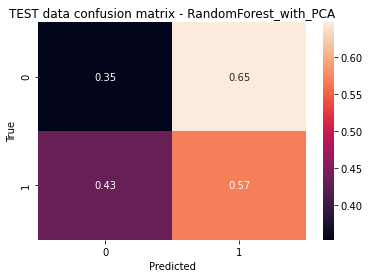

AdaBoost_no_PCA
for TRAINING DATA
ROC_AUC Score: 1.0
Accuracy Score: 1.0


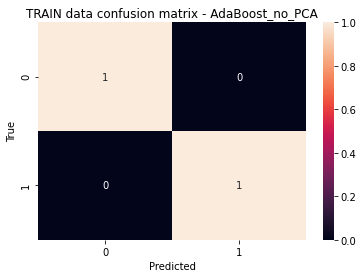

AdaBoost_no_PCA
for TESTING DATA
ROC_AUC Score: 0.6764705882352942
Accuracy Score: 0.6764705882352942


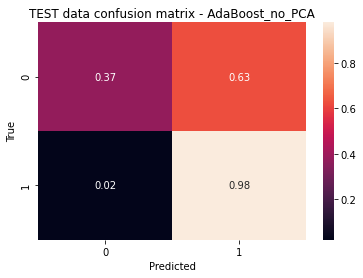

AdaBoost_with_PCA
for TRAINING DATA
ROC_AUC Score: 0.9950617283950617
Accuracy Score: 0.9950617283950618


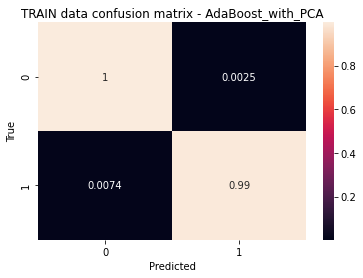

AdaBoost_with_PCA
for TESTING DATA
ROC_AUC Score: 0.7107843137254902
Accuracy Score: 0.7107843137254902


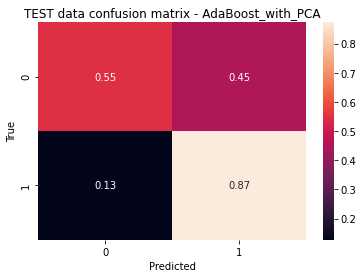

GradientBoosting_no_PCA
for TRAINING DATA
ROC_AUC Score: 1.0
Accuracy Score: 1.0


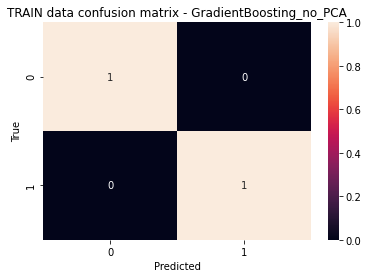

GradientBoosting_no_PCA
for TESTING DATA
ROC_AUC Score: 0.6274509803921569
Accuracy Score: 0.6274509803921569


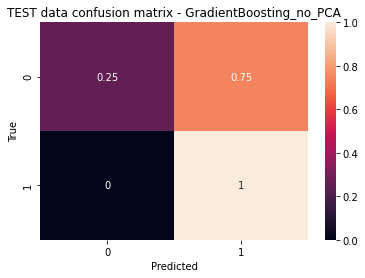

GradientBoosting_with_PCA
for TRAINING DATA
ROC_AUC Score: 1.0
Accuracy Score: 1.0


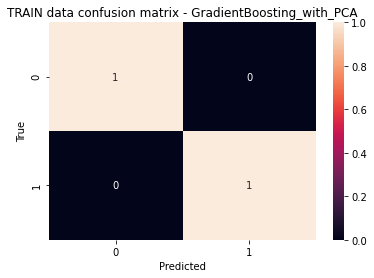

GradientBoosting_with_PCA
for TESTING DATA
ROC_AUC Score: 0.6764705882352942
Accuracy Score: 0.6764705882352942


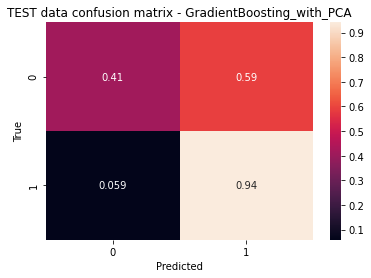

DecisionTree_no_PCA
for TRAINING DATA
ROC_AUC Score: 1.0
Accuracy Score: 1.0


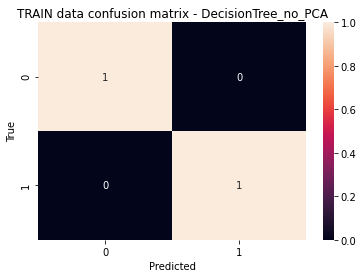

DecisionTree_no_PCA
for TESTING DATA
ROC_AUC Score: 0.6813725490196078
Accuracy Score: 0.6813725490196079


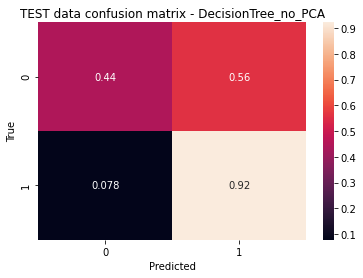

DecisionTree_with_PCA
for TRAINING DATA
ROC_AUC Score: 1.0
Accuracy Score: 1.0


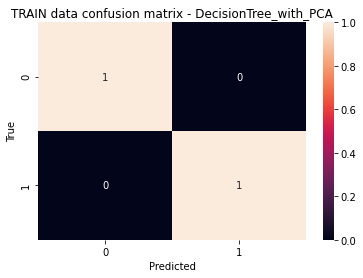

DecisionTree_with_PCA
for TESTING DATA
ROC_AUC Score: 0.6470588235294117
Accuracy Score: 0.6470588235294117


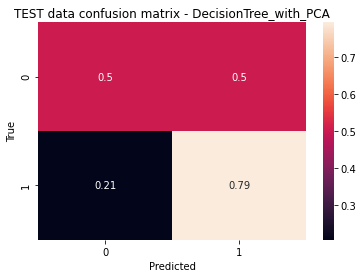

pipeline_name  \
0                  SVC_no_PCA   
1                SVC_with_PCA   
2                  LDA_no_PCA   
3                LDA_with_PCA   
4         RandomForest_no_PCA   
5       RandomForest_with_PCA   
6             AdaBoost_no_PCA   
7           AdaBoost_with_PCA   
8     GradientBoosting_no_PCA   
9   GradientBoosting_with_PCA   
10        DecisionTree_no_PCA   
11      DecisionTree_with_PCA   

                                          named_steps  train_ROC_score  \
0          {'scaler': StandardScaler(), 'est': SVC()}         1.000000   
1   {'scaler': StandardScaler(), 'pca': PCA(), 'es...         1.000000   
2   {'scaler': StandardScaler(), 'est': LinearDisc...         1.000000   
3   {'scaler': StandardScaler(), 'pca': PCA(), 'es...         0.500000   
4   {'scaler': StandardScaler(), 'est': RandomFore...         1.000000   
5   {'scaler': StandardScaler(), 'pca': PCA(), 'es...         1.000000   
6   {'scaler': StandardScaler(), 'est': AdaBoostCl...         1.000000   
7   {'scaler': StandardScaler(), 'pca': PCA(), 'es...         0.995062   
8   {'scaler': StandardScaler(), 'est': GradientBo...         1.000000   
9   {'scaler': StandardScaler(), 'pca': PCA(), 'es...         1.000000   
10  {'scaler': StandardScaler(), 'est': DecisionTr...         1.000000   
11  {'scaler': StandardScaler(), 'pca': PCA(), 'es...         1.000000   

    train_acc_score                             train_confusion_matrix  \
0          1.000000                           [[1.0, 0.0], [0.0, 1.0]]   
1          1.000000                           [[1.0, 0.0], [0.0, 1.0]]   
2          1.000000                           [[1.0, 0.0], [0.0, 1.0]]   
3          0.500000                           [[1.0, 0.0], [1.0, 0.0]]   
4          1.000000                           [[1.0, 0.0], [0.0, 1.0]]   
5          1.000000                           [[1.0, 0.0], [0.0, 1.0]]   
6          1.000000                           [[1.0, 0.0], [0.0, 1.0]]   
7          0.995062  [[0.9975308641975309, 0.0024691358024691358], ...   
8          1.000000                           [[1.0, 0.0], [0.0, 1.0]]   
9          1.000000                           [[1.0, 0.0], [0.0, 1.0]]   
10         1.000000                           [[1.0, 0.0], [0.0, 1.0]]   
11         1.000000                           [[1.0, 0.0], [0.0, 1.0]]   

    test_ROC_score  test_acc_score  \
0         0.740196        0.740196   
1         0.745098        0.745098   
2         0.563725        0.563725   
3         0.558824        0.558824   
4         0.651961        0.651961   
5         0.460784        0.460784   
6         0.676471        0.676471   
7         0.710784        0.710784   
8         0.627451        0.627451   
9         0.676471        0.676471   
10        0.681373        0.681373   
11        0.647059        0.647059   

                                test_confusion_matrix  
0   [[0.5392156862745098, 0.46078431372549017], [0...  
1   [[0.5490196078431373, 0.45098039215686275], [0...  
2   [[0.5392156862745098, 0.46078431372549017], [0...  
3   [[0.5980392156862745, 0.4019607843137255], [0....  
4   [[0.38235294117647056, 0.6176470588235294], [0...  
5   [[0.35294117647058826, 0.6470588235294118], [0...  
6   [[0.37254901960784315, 0.6274509803921569], [0...  
7   [[0.5490196078431373, 0.45098039215686275], [0...  
8   [[0.2549019607843137, 0.7450980392156863], [0....  
9   [[0.4117647058823529, 0.5882352941176471], [0....  
10  [[0.4411764705882353, 0.5588235294117647], [0....  
11  [[0.5, 0.5], [0.20588235294117646, 0.794117647...

In [71]:
model_metrics = []

print("unique target values:",np.unique(y_train))

for pipe_steps, name in zip([pipeline_1a_steps, pipeline_1b_steps, pipeline_2a_steps, pipeline_2b_steps, 
                         pipeline_3a_steps, pipeline_3b_steps, pipeline_4a_steps, pipeline_4b_steps,
                         pipeline_5a_steps, pipeline_5b_steps, pipeline_6a_steps, pipeline_6b_steps],
                         ["SVC_no_PCA","SVC_with_PCA","LDA_no_PCA","LDA_with_PCA",
                          "RandomForest_no_PCA","RandomForest_with_PCA","AdaBoost_no_PCA","AdaBoost_with_PCA",
                "GradientBoosting_no_PCA","GradientBoosting_with_PCA", "DecisionTree_no_PCA",  "DecisionTree_with_PCA"]):
  
  pipe = Pipeline(pipe_steps)
  pipe.fit(X_train, y_train)
  train_predictions = pipe.predict(X_train)
  test_preds = pipe.predict(X_test)

  model_metrics_dict = {'pipeline_name': name, 'named_steps': str(pipe.named_steps)}

  print(name)
  print("for TRAINING DATA")

  model_metrics_dict['train_ROC_score'] = roc_auc_score(y_train, train_predictions)
  model_metrics_dict['train_acc_score'] = balanced_accuracy_score(y_train, train_predictions)
  model_metrics_dict['train_confusion_matrix'] = confusion_matrix(y_train, train_predictions, normalize='true')

  print("ROC_AUC Score:", model_metrics_dict['train_ROC_score'])
  print("Accuracy Score:", model_metrics_dict['train_acc_score'])
  sns.heatmap(model_metrics_dict['train_confusion_matrix'], annot=True)
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.title('TRAIN data confusion matrix - '+name)
  plt.show()

  print(name)
  print("for TESTING DATA")

  model_metrics_dict['test_ROC_score'] = roc_auc_score(y_test, test_preds)
  model_metrics_dict['test_acc_score'] = balanced_accuracy_score(y_test, test_preds)
  model_metrics_dict['test_confusion_matrix'] = confusion_matrix(y_test, test_preds, normalize='true')
  
  print("ROC_AUC Score:", model_metrics_dict['test_ROC_score'] )
  print("Accuracy Score:", model_metrics_dict['test_acc_score'])
  sns.heatmap(model_metrics_dict['test_confusion_matrix'], annot=True)
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.title('TEST data confusion matrix - '+name)
  plt.show()

  model_metrics.append(model_metrics_dict)


model_metrics_df = pd.DataFrame( {'pipeline_name': [metrics['pipeline_name'] for metrics in model_metrics],
                                  'named_steps': [metrics['named_steps'] for metrics in model_metrics],
                                  'train_ROC_score': [metrics['train_ROC_score'] for metrics in model_metrics],
                                  'train_acc_score': [metrics['train_acc_score'] for metrics in model_metrics],
                                  'train_confusion_matrix': [metrics['train_confusion_matrix'] for metrics in model_metrics],
                                  'test_ROC_score': [metrics['test_ROC_score'] for metrics in model_metrics],
                                  'test_acc_score': [metrics['test_acc_score'] for metrics in model_metrics],
                                  'test_confusion_matrix': [metrics['test_confusion_matrix'] for metrics in model_metrics]} )

display(model_metrics_df)

model_metrics_df.to_csv('model_metrics\\M1vM4_experiment_agg_notOptimized_169samplesPerSession.csv')

RandomForest_no_PCA
for TRAINING DATA
ROC_AUC Score: 1.0
Accuracy Score: 1.0


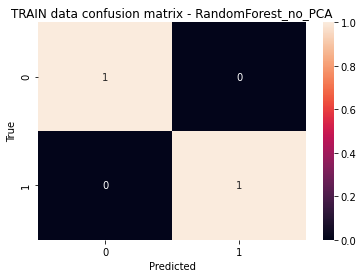

RandomForest_no_PCA
for TESTING DATA
ROC_AUC Score: 0.6911764705882353
Accuracy Score: 0.6911764705882353


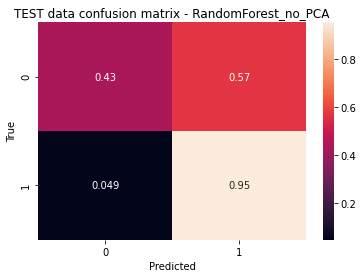

var_power60.0HzCh3                                   0.027127
mean_Accelerometer_X                                 0.026263
var_amplitude4.0HzCh1                                0.018707
mean_amplitude60.0HzCh3                              0.015983
var_amplitude58.0HzCh3                               0.015691
                                                       ...   
var_phaseDifference_phase16.0HzCh2_phase16.0HzCh3    0.000000
var_amplitude66.0HzCh3                               0.000000
var_phaseDifference_phase16.0HzCh1_phase16.0HzCh2    0.000000
mean_phase46.0HzCh0                                  0.000000
var_power36.0HzCh2                                   0.000000
Length: 1482, dtype: float64
var_power60.0HzCh3                                    0.027127
mean_Accelerometer_X                                  0.026263
var_amplitude4.0HzCh1                                 0.018707
mean_amplitude60.0HzCh3                               0.015983
var_amplitude58.0HzCh3               

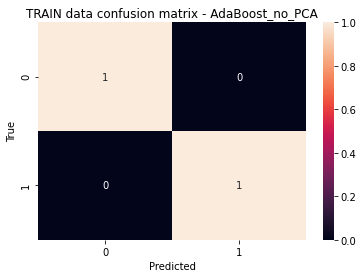

AdaBoost_no_PCA
for TESTING DATA
ROC_AUC Score: 0.607843137254902
Accuracy Score: 0.607843137254902


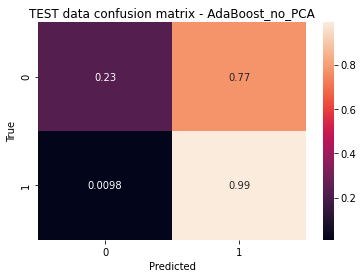

mean_Accelerometer_X                                 0.16
mean_Accelerometer_Y                                 0.14
var_phaseDifference_phase58.0HzCh0_phase58.0HzCh3    0.04
mean_Theta_AF7                                       0.04
mean_Mellow                                          0.04
                                                     ... 
mean_phase70.0HzCh3                                  0.00
mean_phase68.0HzCh3                                  0.00
mean_phase66.0HzCh3                                  0.00
mean_phase64.0HzCh3                                  0.00
var_phaseDifference_phase80.0HzCh2_phase80.0HzCh3    0.00
Length: 1482, dtype: float64
mean_Accelerometer_X                                 0.16
mean_Accelerometer_Y                                 0.14
var_phaseDifference_phase58.0HzCh0_phase58.0HzCh3    0.04
mean_Theta_AF7                                       0.04
mean_Mellow                                          0.04
mean_Accelerometer_Z                       

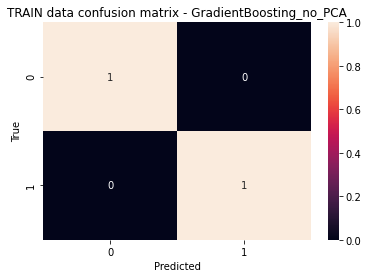

GradientBoosting_no_PCA
for TESTING DATA
ROC_AUC Score: 0.6274509803921569
Accuracy Score: 0.6274509803921569


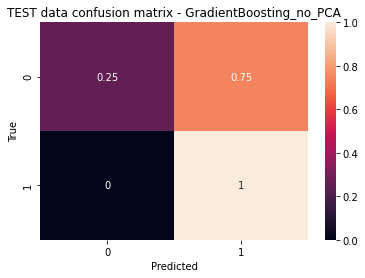

mean_Accelerometer_X                                  0.412758
var_power60.0HzCh3                                    0.273761
var_phaseDifference_phase60.0HzCh0_phase60.0HzCh3     0.047876
mean_Accelerometer_Y                                  0.045291
var_amplitude6.0HzCh1                                 0.016711
                                                        ...   
mean_phaseDifference_phase10.0HzCh1_phase10.0HzCh3    0.000000
mean_phaseDifference_phase10.0HzCh1_phase10.0HzCh2    0.000000
mean_phaseDifference_phase10.0HzCh0_phase10.0HzCh3    0.000000
mean_phaseDifference_phase10.0HzCh0_phase10.0HzCh1    0.000000
var_phaseDifference_phase80.0HzCh2_phase80.0HzCh3     0.000000
Length: 1482, dtype: float64
mean_Accelerometer_X                                  0.412758
var_power60.0HzCh3                                    0.273761
var_phaseDifference_phase60.0HzCh0_phase60.0HzCh3     0.047876
mean_Accelerometer_Y                                  0.045291
var_amplitude6.0HzCh1     

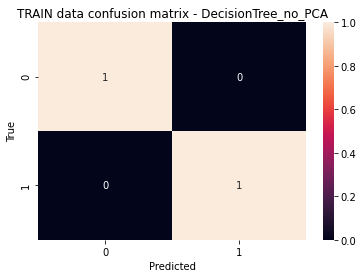

DecisionTree_no_PCA
for TESTING DATA
ROC_AUC Score: 0.6813725490196078
Accuracy Score: 0.6813725490196079


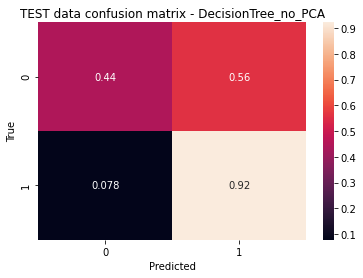

mean_Accelerometer_X                                 0.437724
var_power60.0HzCh3                                   0.288235
mean_Accelerometer_Y                                 0.055319
var_phaseDifference_phase60.0HzCh0_phase60.0HzCh3    0.045233
mean_power48.0HzCh0                                  0.039643
                                                       ...   
mean_phase56.0HzCh3                                  0.000000
mean_phase54.0HzCh3                                  0.000000
mean_phase52.0HzCh3                                  0.000000
mean_phase50.0HzCh3                                  0.000000
var_phaseDifference_phase80.0HzCh2_phase80.0HzCh3    0.000000
Length: 1482, dtype: float64
mean_Accelerometer_X                                  0.437724
var_power60.0HzCh3                                    0.288235
mean_Accelerometer_Y                                  0.055319
var_phaseDifference_phase60.0HzCh0_phase60.0HzCh3     0.045233
mean_power48.0HzCh0                  

In [61]:
for pipe_steps, name in zip([
                         pipeline_3a_steps, pipeline_4a_steps, 
                         pipeline_5a_steps, pipeline_6a_steps],
                         [
                          "RandomForest_no_PCA","AdaBoost_no_PCA",
                          "GradientBoosting_no_PCA", "DecisionTree_no_PCA"]):
  
  pipe = Pipeline(pipe_steps)
  pipe.fit(X_train, y_train)
  train_predictions = pipe.predict(X_train)
  test_preds = pipe.predict(X_test)

  model_metrics_dict = {'pipeline_name': name, 'named_steps': str(pipe.named_steps)}

  print(name)
  print("for TRAINING DATA")

  model_metrics_dict['train_ROC_score'] = roc_auc_score(y_train, train_predictions)
  model_metrics_dict['train_acc_score'] = balanced_accuracy_score(y_train, train_predictions)
  model_metrics_dict['train_confusion_matrix'] = confusion_matrix(y_train, train_predictions, normalize='true')

  print("ROC_AUC Score:", model_metrics_dict['train_ROC_score'])
  print("Accuracy Score:", model_metrics_dict['train_acc_score'])
  sns.heatmap(model_metrics_dict['train_confusion_matrix'], annot=True)
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.title('TRAIN data confusion matrix - '+name)
  plt.show()

  print(name)
  print("for TESTING DATA")

  model_metrics_dict['test_ROC_score'] = roc_auc_score(y_test, test_preds)
  model_metrics_dict['test_acc_score'] = balanced_accuracy_score(y_test, test_preds)
  model_metrics_dict['test_confusion_matrix'] = confusion_matrix(y_test, test_preds, normalize='true')
  
  print("ROC_AUC Score:", model_metrics_dict['test_ROC_score'] )
  print("Accuracy Score:", model_metrics_dict['test_acc_score'])
  sns.heatmap(model_metrics_dict['test_confusion_matrix'], annot=True)
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.title('TEST data confusion matrix - '+name)
  plt.show()

  feat_import = pd.Series(pipe.named_steps.est.feature_importances_, index= dataset.drop(['TARGET','ORIGINAL_ROW_NUM','ORIGINAL_FILE_NUM'], axis=1).columns)


  print(feat_import.sort_values(ascending=False))

  print(feat_import.sort_values(ascending=False).iloc[:30])

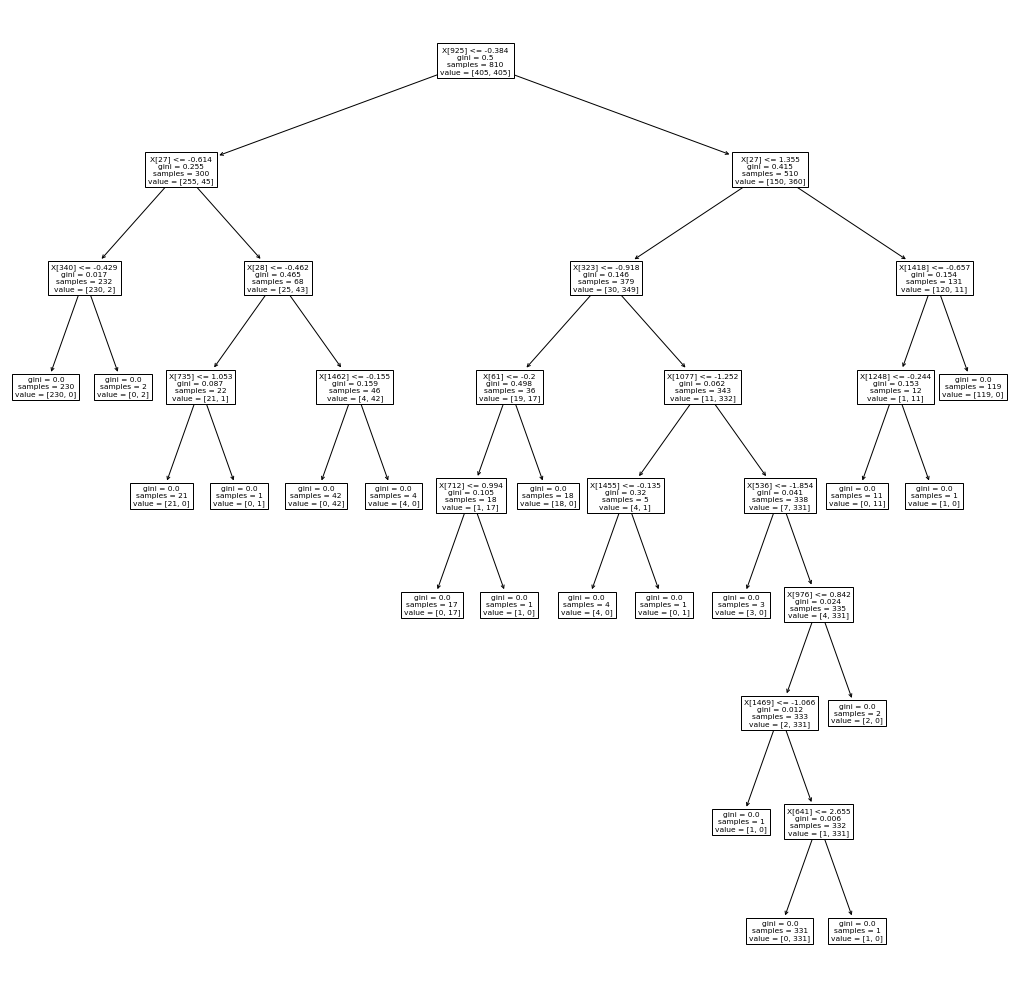

In [64]:
from sklearn.tree import plot_tree

plt.figure(figsize=(18,18))
plot_tree(pipe.named_steps.est)
plt.show()

In [65]:
print('X[925]:', temp[925])
print('X[27]:', temp[27])


print('X[28]:', temp[28])


print('X[323]:', temp[323])

print('X[1418]:', temp[1418])
print('X[1462]:', temp[1462])

print('X[61]:', temp[61])

#print('X[]:', temp[])
#print('X[]:', temp[])

X[925]: var_power60.0HzCh3
X[27]: mean_Accelerometer_X
X[28]: mean_Accelerometer_Y
X[323]: mean_amplitude26.0HzCh3
X[1418]: var_phaseDifference_phase60.0HzCh0_phase60.0HzCh3
X[1462]: var_phaseDifference_phase74.0HzCh1_phase74.0HzCh3
X[61]: mean_power48.0HzCh0


# <a name="exp5">  Experiment 5: All classes </a >

[back to top](#TOC)

In [72]:
outer1, outer2, outer3, outer4 = [],[],[],[]

for dataset in [M1_session0.iloc[:112], M1_session1.iloc[:112], M1_session2.iloc[:112], 
                M2_session0.iloc[:112], M2_session1.iloc[:112], M2_session2.iloc[:112], 
                M3_session0.iloc[:112], M3_session1.iloc[:112], M3_session2.iloc[:112], 
                M4_session0.iloc[:112], M4_session1.iloc[:112], M4_session2.iloc[:112], 
                M5_session0.iloc[:112], M5_session1.iloc[:112], M5_session2.iloc[:112]]:
  y = np.array(dataset['TARGET']).reshape(-1, 1)
  X = np.array(dataset.drop(['TARGET','ORIGINAL_ROW_NUM','ORIGINAL_FILE_NUM'], axis=1))

  print('y.shape',y.shape)

  X_train_subset, X_test_subset, y_train_subset, y_test_subset = train_test_split(X, y, test_size=0.2, shuffle=False)

  outer1.append(X_train_subset)
  outer2.append(X_test_subset)
  outer3.append(y_train_subset)
  outer4.append(y_test_subset)

X_train = np.vstack(outer1)
X_test = np.vstack(outer2)
y_train = np.vstack(outer3).ravel()
y_test = np.vstack(outer4).ravel()

print('X_train.shape', X_train.shape)
print('X_test.shape', X_test.shape)
print('y_train.shape',y_train.shape)
print('y_test.shape',y_test.shape)

y.shape (112, 1)
y.shape (112, 1)
y.shape (112, 1)
y.shape (112, 1)
y.shape (112, 1)
y.shape (112, 1)
y.shape (112, 1)
y.shape (112, 1)
y.shape (112, 1)
y.shape (112, 1)
y.shape (112, 1)
y.shape (112, 1)
y.shape (112, 1)
y.shape (112, 1)
y.shape (112, 1)
X_train.shape (1335, 1482)
X_test.shape (345, 1482)
y_train.shape (1335,)
y_test.shape (345,)


unique target values: [1 2 3 4 5]
SVC_no_PCA
for TRAINING DATA
Accuracy Score: 1.0


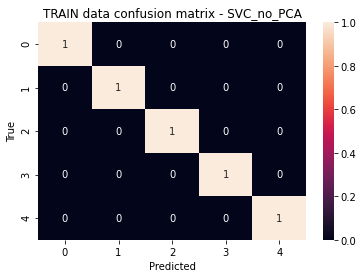

SVC_no_PCA
for TESTING DATA
Accuracy Score: 0.7043478260869566


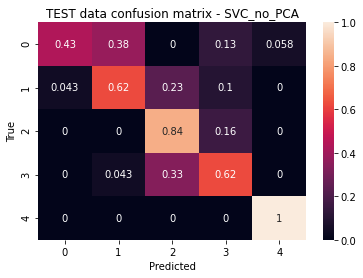

SVC_with_PCA
for TRAINING DATA
Accuracy Score: 1.0


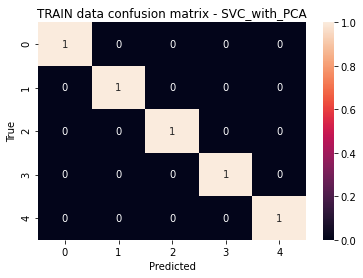

SVC_with_PCA
for TESTING DATA
Accuracy Score: 0.7043478260869566


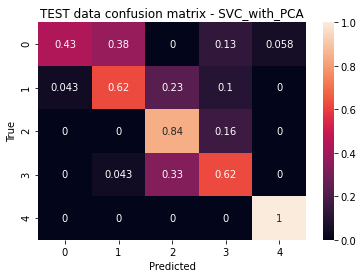

LDA_no_PCA
for TRAINING DATA
Accuracy Score: 1.0


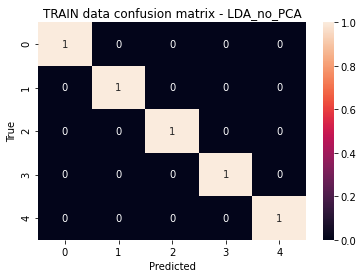

LDA_no_PCA
for TESTING DATA
Accuracy Score: 0.37681159420289856


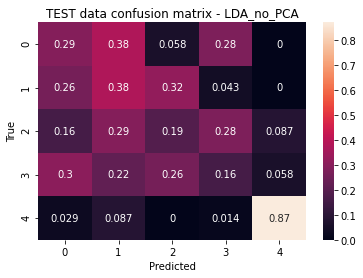

LDA_with_PCA
for TRAINING DATA
Accuracy Score: 0.2


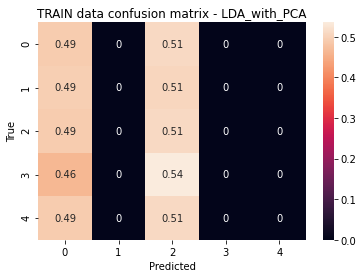

LDA_with_PCA
for TESTING DATA
Accuracy Score: 0.1855072463768116


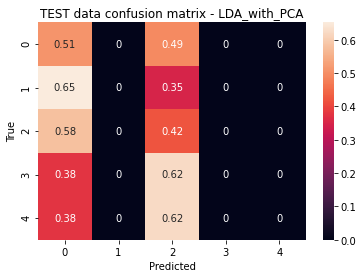

RandomForest_no_PCA
for TRAINING DATA
Accuracy Score: 1.0


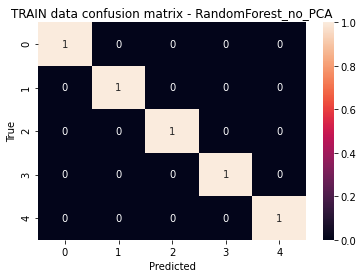

RandomForest_no_PCA
for TESTING DATA
Accuracy Score: 0.7594202898550725


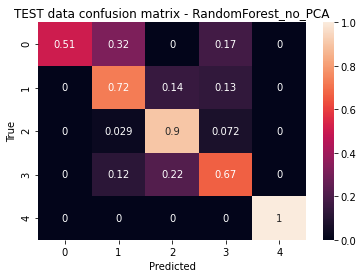

mean_power70.0HzCh1       0.013442
mean_Accelerometer_X      0.012673
var_Gyro_Z                0.011025
mean_Accelerometer_Z      0.010582
var_Accelerometer_Y       0.008667
                            ...   
mean_HeadBandOn           0.000000
mean_HSI_TP9              0.000000
var_power68.0HzCh3        0.000000
mean_HSI_AF7              0.000000
var_amplitude64.0HzCh3    0.000000
Length: 1482, dtype: float64
mean_power70.0HzCh1                                  0.013442
mean_Accelerometer_X                                 0.012673
var_Gyro_Z                                           0.011025
mean_Accelerometer_Z                                 0.010582
var_Accelerometer_Y                                  0.008667
mean_power46.0HzCh1                                  0.007061
mean_Accelerometer_Y                                 0.007006
mean_amplitude10.0HzCh3                              0.006973
var_amplitude76.0HzCh1                               0.006880
mean_power10.0HzCh3         

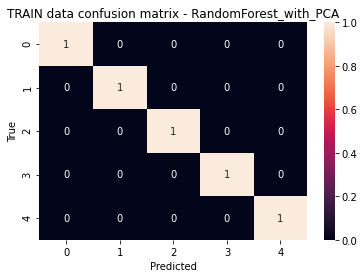

RandomForest_with_PCA
for TESTING DATA
Accuracy Score: 0.42028985507246375


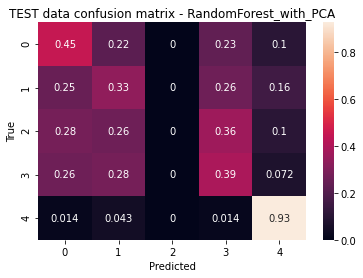

AdaBoost_no_PCA
for TRAINING DATA
Accuracy Score: 0.47415730337078654


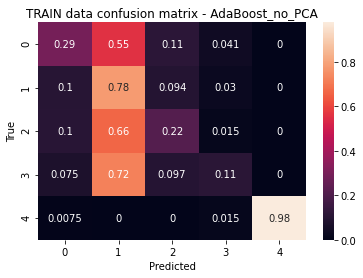

AdaBoost_no_PCA
for TESTING DATA
Accuracy Score: 0.42608695652173906


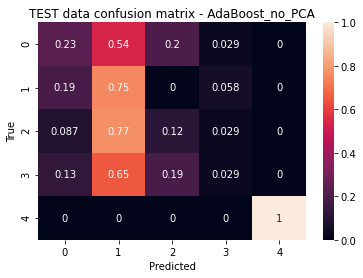

mean_amplitude46.0HzCh1                              0.24
mean_power10.0HzCh3                                  0.20
var_amplitude10.0HzCh1                               0.04
mean_Alpha_TP10                                      0.04
mean_amplitude10.0HzCh3                              0.04
                                                     ... 
mean_phase72.0HzCh3                                  0.00
mean_phase70.0HzCh3                                  0.00
mean_phase68.0HzCh3                                  0.00
mean_phase66.0HzCh3                                  0.00
var_phaseDifference_phase80.0HzCh2_phase80.0HzCh3    0.00
Length: 1482, dtype: float64
mean_amplitude46.0HzCh1                            0.24
mean_power10.0HzCh3                                0.20
var_amplitude10.0HzCh1                             0.04
mean_Alpha_TP10                                    0.04
mean_amplitude10.0HzCh3                            0.04
mean_amplitude78.0HzCh1                            0.

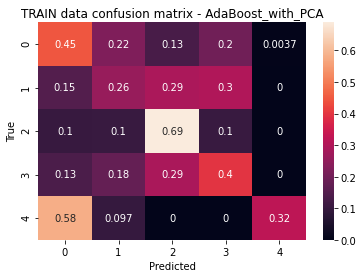

AdaBoost_with_PCA
for TESTING DATA
Accuracy Score: 0.3942028985507247


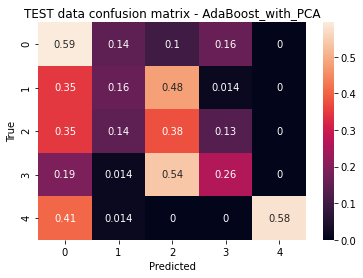

GradientBoosting_no_PCA
for TRAINING DATA
Accuracy Score: 1.0


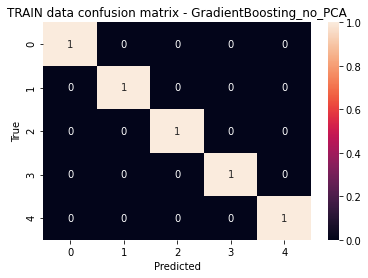

GradientBoosting_no_PCA
for TESTING DATA
Accuracy Score: 0.7014492753623188


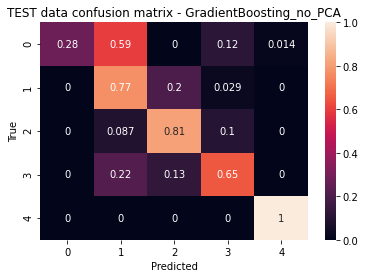

mean_amplitude46.0HzCh1                               2.044194e-01
mean_Accelerometer_X                                  9.896705e-02
var_Gyro_Z                                            7.800960e-02
mean_Accelerometer_Z                                  6.597769e-02
var_amplitude62.0HzCh0                                5.693320e-02
                                                          ...     
var_power12.0HzCh0                                    0.000000e+00
mean_amplitude72.0HzCh0                               0.000000e+00
var_power16.0HzCh0                                    0.000000e+00
var_power24.0HzCh3                                    0.000000e+00
mean_phaseDifference_phase30.0HzCh1_phase30.0HzCh3   -3.168830e-21
Length: 1482, dtype: float64
mean_amplitude46.0HzCh1                              0.204419
mean_Accelerometer_X                                 0.098967
var_Gyro_Z                                           0.078010
mean_Accelerometer_Z                            

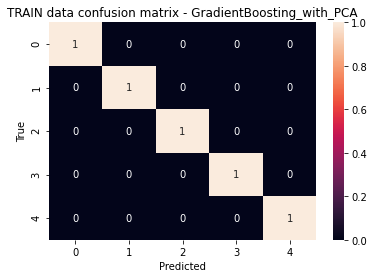

GradientBoosting_with_PCA
for TESTING DATA
Accuracy Score: 0.527536231884058


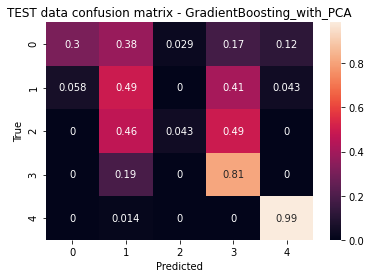

DecisionTree_no_PCA
for TRAINING DATA
Accuracy Score: 1.0


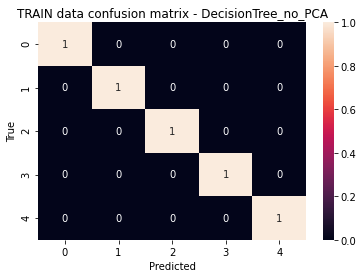

DecisionTree_no_PCA
for TESTING DATA
Accuracy Score: 0.5855072463768116


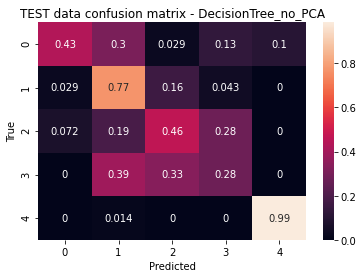

mean_amplitude46.0HzCh1                              0.219128
mean_Accelerometer_X                                 0.132253
var_Gyro_Z                                           0.093260
mean_Accelerometer_Z                                 0.092604
mean_Accelerometer_Y                                 0.059958
                                                       ...   
mean_phaseDifference_phase4.0HzCh0_phase4.0HzCh2     0.000000
mean_phaseDifference_phase4.0HzCh0_phase4.0HzCh1     0.000000
mean_phase80.0HzCh3                                  0.000000
mean_phase78.0HzCh3                                  0.000000
var_phaseDifference_phase80.0HzCh2_phase80.0HzCh3    0.000000
Length: 1482, dtype: float64
mean_amplitude46.0HzCh1                              0.219128
mean_Accelerometer_X                                 0.132253
var_Gyro_Z                                           0.093260
mean_Accelerometer_Z                                 0.092604
mean_Accelerometer_Y                     

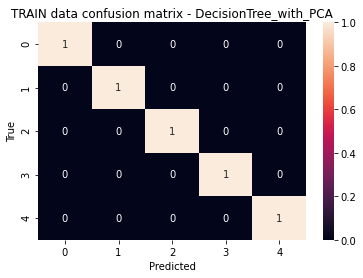

DecisionTree_with_PCA
for TESTING DATA
Accuracy Score: 0.3246376811594203


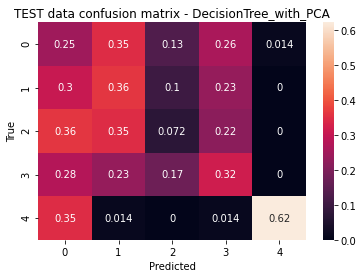

pipeline_name  \
0                  SVC_no_PCA   
1                SVC_with_PCA   
2                  LDA_no_PCA   
3                LDA_with_PCA   
4         RandomForest_no_PCA   
5       RandomForest_with_PCA   
6             AdaBoost_no_PCA   
7           AdaBoost_with_PCA   
8     GradientBoosting_no_PCA   
9   GradientBoosting_with_PCA   
10        DecisionTree_no_PCA   
11      DecisionTree_with_PCA   

                                          named_steps  train_acc_score  \
0          {'scaler': StandardScaler(), 'est': SVC()}         1.000000   
1   {'scaler': StandardScaler(), 'pca': PCA(), 'es...         1.000000   
2   {'scaler': StandardScaler(), 'est': LinearDisc...         1.000000   
3   {'scaler': StandardScaler(), 'pca': PCA(), 'es...         0.200000   
4   {'scaler': StandardScaler(), 'est': RandomFore...         1.000000   
5   {'scaler': StandardScaler(), 'pca': PCA(), 'es...         1.000000   
6   {'scaler': StandardScaler(), 'est': AdaBoostCl...         0.474157   
7   {'scaler': StandardScaler(), 'pca': PCA(), 'es...         0.422472   
8   {'scaler': StandardScaler(), 'est': GradientBo...         1.000000   
9   {'scaler': StandardScaler(), 'pca': PCA(), 'es...         1.000000   
10  {'scaler': StandardScaler(), 'est': DecisionTr...         1.000000   
11  {'scaler': StandardScaler(), 'pca': PCA(), 'es...         1.000000   

                               train_confusion_matrix  test_acc_score  \
0   [[1.0, 0.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0....        0.704348   
1   [[1.0, 0.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0....        0.704348   
2   [[1.0, 0.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0....        0.376812   
3   [[0.49063670411985016, 0.0, 0.5093632958801498...        0.185507   
4   [[1.0, 0.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0....        0.759420   
5   [[1.0, 0.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0....        0.420290   
6   [[0.29213483146067415, 0.5543071161048689, 0.1...        0.426087   
7   [[0.44569288389513106, 0.2209737827715356, 0.1...        0.394203   
8   [[1.0, 0.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0....        0.701449   
9   [[1.0, 0.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0....        0.527536   
10  [[1.0, 0.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0....        0.585507   
11  [[1.0, 0.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0....        0.324638   

                                test_confusion_matrix  
0   [[0.43478260869565216, 0.37681159420289856, 0....  
1   [[0.43478260869565216, 0.37681159420289856, 0....  
2   [[0.2898550724637681, 0.37681159420289856, 0.0...  
3   [[0.5072463768115942, 0.0, 0.4927536231884058,...  
4   [[0.5072463768115942, 0.3188405797101449, 0.0,...  
5   [[0.4492753623188406, 0.21739130434782608, 0.0...  
6   [[0.2318840579710145, 0.5362318840579711, 0.20...  
7   [[0.5942028985507246, 0.14492753623188406, 0.1...  
8   [[0.2753623188405797, 0.5942028985507246, 0.0,...  
9   [[0.30434782608695654, 0.37681159420289856, 0....  
10  [[0.43478260869565216, 0.30434782608695654, 0....  
11  [[0.2463768115942029, 0.34782608695652173, 0.1...

In [76]:
model_metrics = []

print("unique target values:",np.unique(y_train))

for pipe_steps, name in zip([pipeline_1a_steps, pipeline_1b_steps, pipeline_2a_steps, pipeline_2b_steps, 
                         pipeline_3a_steps, pipeline_3b_steps, pipeline_4a_steps, pipeline_4b_steps,
                         pipeline_5a_steps, pipeline_5b_steps, pipeline_6a_steps, pipeline_6b_steps],
                         ["SVC_no_PCA","SVC_with_PCA","LDA_no_PCA","LDA_with_PCA",
                          "RandomForest_no_PCA","RandomForest_with_PCA","AdaBoost_no_PCA","AdaBoost_with_PCA",
                "GradientBoosting_no_PCA","GradientBoosting_with_PCA", "DecisionTree_no_PCA",  "DecisionTree_with_PCA"]):
  
  pipe = Pipeline(pipe_steps)
  pipe.fit(X_train, y_train)
  train_predictions = pipe.predict(X_train)
  test_preds = pipe.predict(X_test)

  model_metrics_dict = {'pipeline_name': name, 'named_steps': str(pipe.named_steps)}

  print(name)
  print("for TRAINING DATA")

  model_metrics_dict['train_acc_score'] = balanced_accuracy_score(y_train, train_predictions)
  model_metrics_dict['train_confusion_matrix'] = confusion_matrix(y_train, train_predictions, normalize='true')

  print("Accuracy Score:", model_metrics_dict['train_acc_score'])
  sns.heatmap(model_metrics_dict['train_confusion_matrix'], annot=True)
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.title('TRAIN data confusion matrix - '+name)
  plt.show()

  print(name)
  print("for TESTING DATA")

  model_metrics_dict['test_acc_score'] = balanced_accuracy_score(y_test, test_preds)
  model_metrics_dict['test_confusion_matrix'] = confusion_matrix(y_test, test_preds, normalize='true')
  
  print("Accuracy Score:", model_metrics_dict['test_acc_score'])
  sns.heatmap(model_metrics_dict['test_confusion_matrix'], annot=True)
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.title('TEST data confusion matrix - '+name)
  plt.show()

  if name in ["RandomForest_no_PCA", "AdaBoost_no_PCA" ,"GradientBoosting_no_PCA", "DecisionTree_no_PCA"]:
      feat_import = pd.Series(pipe.named_steps.est.feature_importances_, index= dataset.drop(['TARGET','ORIGINAL_ROW_NUM','ORIGINAL_FILE_NUM'], axis=1).columns)
      print(feat_import.sort_values(ascending=False))
      print(feat_import.sort_values(ascending=False).iloc[:30])

  model_metrics.append(model_metrics_dict)


model_metrics_df = pd.DataFrame( {'pipeline_name': [metrics['pipeline_name'] for metrics in model_metrics],
                                  'named_steps': [metrics['named_steps'] for metrics in model_metrics],
                                  'train_acc_score': [metrics['train_acc_score'] for metrics in model_metrics],
                                  'train_confusion_matrix': [metrics['train_confusion_matrix'] for metrics in model_metrics],
                                  'test_acc_score': [metrics['test_acc_score'] for metrics in model_metrics],
                                  'test_confusion_matrix': [metrics['test_confusion_matrix'] for metrics in model_metrics]} )

display(model_metrics_df)

model_metrics_df.to_csv('model_metrics\\AllClasses_experiment_agg_notOptimized_112samplesPerSession.csv')

RandomForest_no_PCA
for TRAINING DATA
Accuracy Score: 1.0


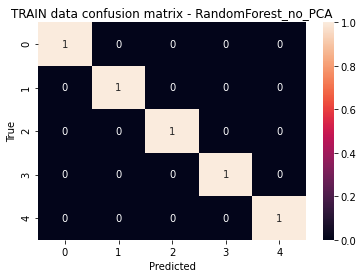

RandomForest_no_PCA
for TESTING DATA
Accuracy Score: 0.7594202898550725


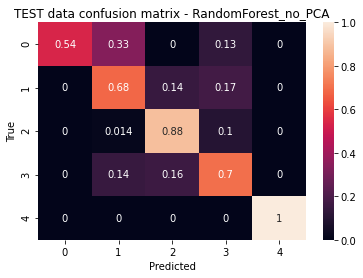

mean_Accelerometer_X                                  0.016193
mean_Accelerometer_Z                                  0.014668
var_Gyro_Z                                            0.012101
mean_amplitude44.0HzCh1                               0.011319
var_Accelerometer_Y                                   0.009533
                                                        ...   
mean_power6.0HzCh2                                    0.000000
mean_HSI_TP9                                          0.000000
mean_HeadBandOn                                       0.000000
var_HSI_AF8                                           0.000000
mean_phaseDifference_phase54.0HzCh0_phase54.0HzCh1    0.000000
Length: 1482, dtype: float64
mean_Accelerometer_X                                  0.016193
mean_Accelerometer_Z                                  0.014668
var_Gyro_Z                                            0.012101
mean_amplitude44.0HzCh1                               0.011319
var_Accelerometer_Y       

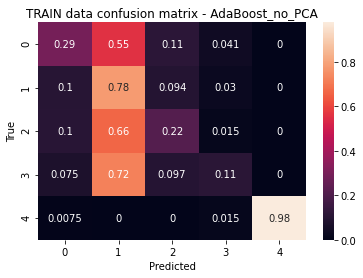

AdaBoost_no_PCA
for TESTING DATA
Accuracy Score: 0.42608695652173906


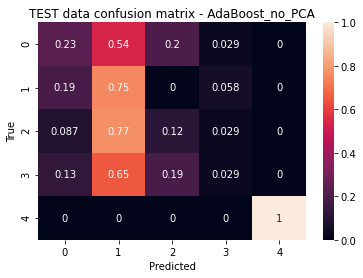

mean_amplitude46.0HzCh1                              0.24
mean_power10.0HzCh3                                  0.20
mean_power72.0HzCh1                                  0.04
mean_power76.0HzCh1                                  0.04
var_phaseDifference_phase8.0HzCh0_phase8.0HzCh1      0.04
                                                     ... 
mean_phase72.0HzCh3                                  0.00
mean_phase70.0HzCh3                                  0.00
mean_phase68.0HzCh3                                  0.00
mean_phase66.0HzCh3                                  0.00
var_phaseDifference_phase80.0HzCh2_phase80.0HzCh3    0.00
Length: 1482, dtype: float64
mean_amplitude46.0HzCh1                            0.24
mean_power10.0HzCh3                                0.20
mean_power72.0HzCh1                                0.04
mean_power76.0HzCh1                                0.04
var_phaseDifference_phase8.0HzCh0_phase8.0HzCh1    0.04
mean_amplitude10.0HzCh3                            0.

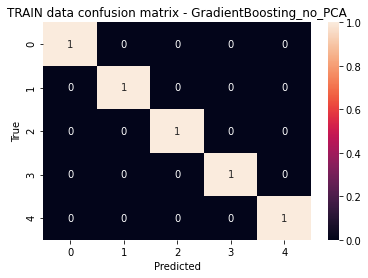

GradientBoosting_no_PCA
for TESTING DATA
Accuracy Score: 0.7072463768115942


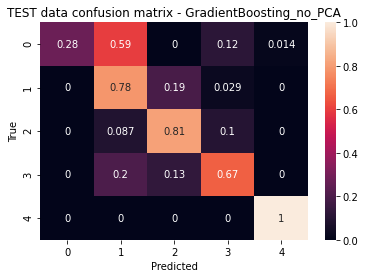

mean_amplitude46.0HzCh1                              0.204419
mean_Accelerometer_X                                 0.098475
var_Gyro_Z                                           0.078010
mean_Accelerometer_Z                                 0.066470
var_amplitude62.0HzCh0                               0.056933
                                                       ...   
var_power56.0HzCh1                                   0.000000
mean_amplitude20.0HzCh3                              0.000000
var_power62.0HzCh1                                   0.000000
mean_amplitude18.0HzCh3                              0.000000
var_phaseDifference_phase80.0HzCh2_phase80.0HzCh3    0.000000
Length: 1482, dtype: float64
mean_amplitude46.0HzCh1                              0.204419
mean_Accelerometer_X                                 0.098475
var_Gyro_Z                                           0.078010
mean_Accelerometer_Z                                 0.066470
var_amplitude62.0HzCh0                   

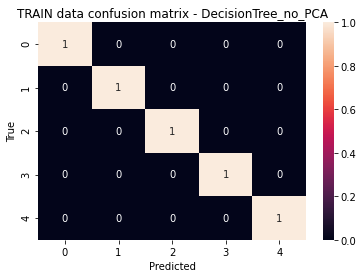

DecisionTree_no_PCA
for TESTING DATA
Accuracy Score: 0.6202898550724638


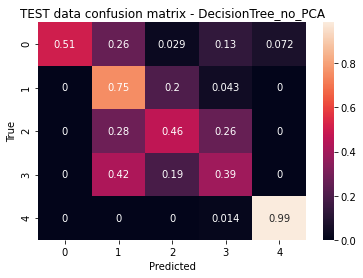

mean_amplitude46.0HzCh1                              0.219128
mean_Accelerometer_X                                 0.132253
var_Gyro_Z                                           0.093260
mean_Accelerometer_Z                                 0.092604
mean_Accelerometer_Y                                 0.059958
                                                       ...   
mean_phase76.0HzCh3                                  0.000000
mean_phase74.0HzCh3                                  0.000000
mean_phase72.0HzCh3                                  0.000000
mean_phase70.0HzCh3                                  0.000000
var_phaseDifference_phase80.0HzCh2_phase80.0HzCh3    0.000000
Length: 1482, dtype: float64
mean_amplitude46.0HzCh1                              0.219128
mean_Accelerometer_X                                 0.132253
var_Gyro_Z                                           0.093260
mean_Accelerometer_Z                                 0.092604
mean_Accelerometer_Y                     

In [79]:
for pipe_steps, name in zip([
                         pipeline_3a_steps, pipeline_4a_steps, 
                         pipeline_5a_steps, pipeline_6a_steps],
                         [
                          "RandomForest_no_PCA","AdaBoost_no_PCA",
                          "GradientBoosting_no_PCA", "DecisionTree_no_PCA"]):
  
  pipe = Pipeline(pipe_steps)
  pipe.fit(X_train, y_train)
  train_predictions = pipe.predict(X_train)
  test_preds = pipe.predict(X_test)

  model_metrics_dict = {'pipeline_name': name, 'named_steps': str(pipe.named_steps)}

  print(name)
  print("for TRAINING DATA")


  model_metrics_dict['train_acc_score'] = balanced_accuracy_score(y_train, train_predictions)
  model_metrics_dict['train_confusion_matrix'] = confusion_matrix(y_train, train_predictions, normalize='true')


  print("Accuracy Score:", model_metrics_dict['train_acc_score'])
  sns.heatmap(model_metrics_dict['train_confusion_matrix'], annot=True)
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.title('TRAIN data confusion matrix - '+name)
  plt.show()

  print(name)
  print("for TESTING DATA")


  model_metrics_dict['test_acc_score'] = balanced_accuracy_score(y_test, test_preds)
  model_metrics_dict['test_confusion_matrix'] = confusion_matrix(y_test, test_preds, normalize='true')
  

  print("Accuracy Score:", model_metrics_dict['test_acc_score'])
  sns.heatmap(model_metrics_dict['test_confusion_matrix'], annot=True)
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.title('TEST data confusion matrix - '+name)
  plt.show()

  feat_import = pd.Series(pipe.named_steps.est.feature_importances_, index= dataset.drop(['TARGET','ORIGINAL_ROW_NUM','ORIGINAL_FILE_NUM'], axis=1).columns)


  print(feat_import.sort_values(ascending=False))

  print(feat_import.sort_values(ascending=False).iloc[:30])

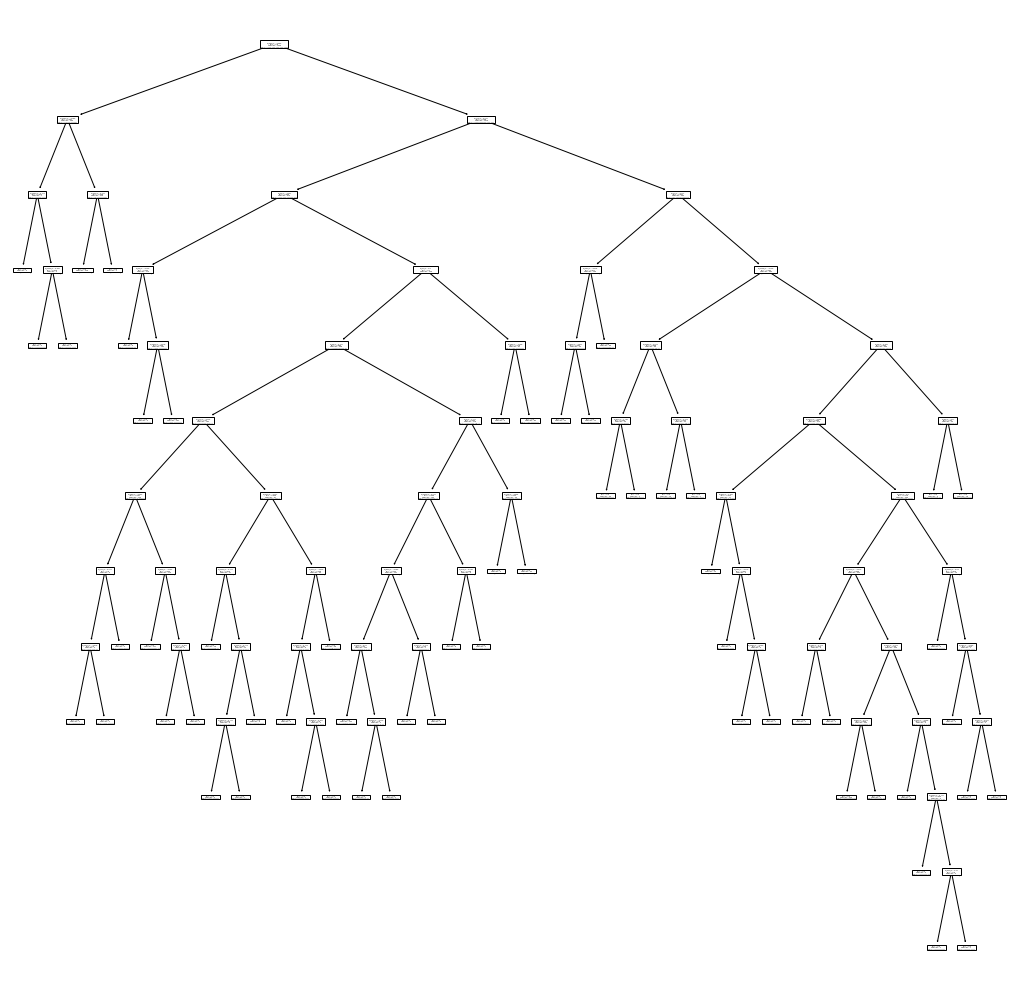

In [80]:
from sklearn.tree import plot_tree

plt.figure(figsize=(18,18))
plot_tree(pipe.named_steps.est)
plt.show()

# <a name="exp6">  Experiment 6: M1, M3, M4, M5 </a >

[back to top](#TOC)

In [81]:
outer1, outer2, outer3, outer4 = [],[],[],[]

for dataset in [M1_session0.iloc[:112], M1_session1.iloc[:112], M1_session2.iloc[:112], 
                M3_session0.iloc[:112], M3_session1.iloc[:112], M3_session2.iloc[:112], 
                M4_session0.iloc[:112], M4_session1.iloc[:112], M4_session2.iloc[:112], 
                M5_session0.iloc[:112], M5_session1.iloc[:112], M5_session2.iloc[:112]]:
  y = np.array(dataset['TARGET']).reshape(-1, 1)
  X = np.array(dataset.drop(['TARGET','ORIGINAL_ROW_NUM','ORIGINAL_FILE_NUM'], axis=1))

  print('y.shape',y.shape)

  X_train_subset, X_test_subset, y_train_subset, y_test_subset = train_test_split(X, y, test_size=0.2, shuffle=False)

  outer1.append(X_train_subset)
  outer2.append(X_test_subset)
  outer3.append(y_train_subset)
  outer4.append(y_test_subset)

X_train = np.vstack(outer1)
X_test = np.vstack(outer2)
y_train = np.vstack(outer3).ravel()
y_test = np.vstack(outer4).ravel()

print('X_train.shape', X_train.shape)
print('X_test.shape', X_test.shape)
print('y_train.shape',y_train.shape)
print('y_test.shape',y_test.shape)

y.shape (112, 1)
y.shape (112, 1)
y.shape (112, 1)
y.shape (112, 1)
y.shape (112, 1)
y.shape (112, 1)
y.shape (112, 1)
y.shape (112, 1)
y.shape (112, 1)
y.shape (112, 1)
y.shape (112, 1)
y.shape (112, 1)
X_train.shape (1068, 1482)
X_test.shape (276, 1482)
y_train.shape (1068,)
y_test.shape (276,)


unique target values: [1 3 4 5]
SVC_no_PCA
for TRAINING DATA
Accuracy Score: 1.0


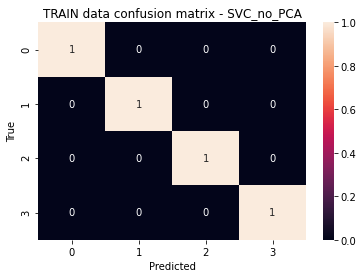

SVC_no_PCA
for TESTING DATA
Accuracy Score: 0.7826086956521738


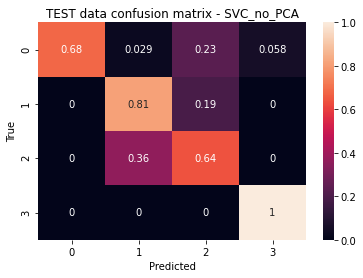

SVC_with_PCA
for TRAINING DATA
Accuracy Score: 1.0


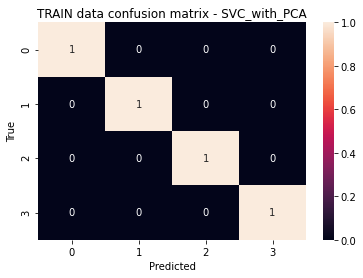

SVC_with_PCA
for TESTING DATA
Accuracy Score: 0.786231884057971


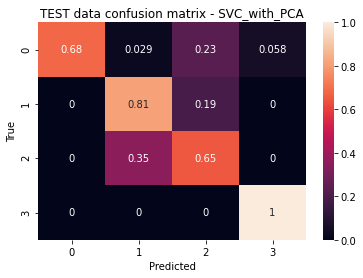

LDA_no_PCA
for TRAINING DATA
Accuracy Score: 1.0


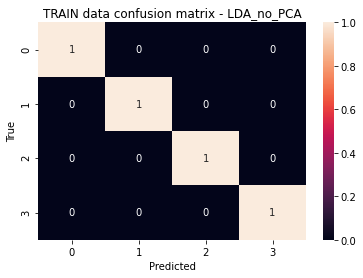

LDA_no_PCA
for TESTING DATA
Accuracy Score: 0.5652173913043479


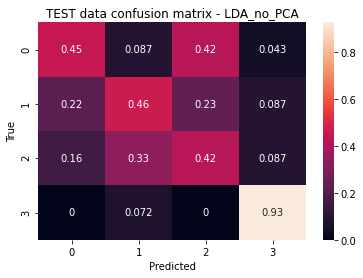

LDA_with_PCA
for TRAINING DATA
Accuracy Score: 0.25


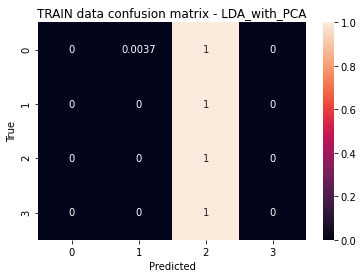

LDA_with_PCA
for TESTING DATA
Accuracy Score: 0.2536231884057971


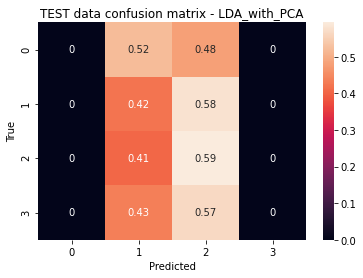

RandomForest_no_PCA
for TRAINING DATA
Accuracy Score: 1.0


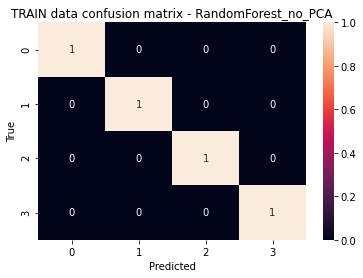

RandomForest_no_PCA
for TESTING DATA
Accuracy Score: 0.8369565217391304


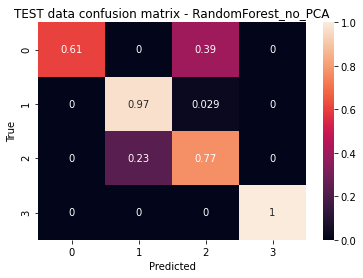

var_Gyro_Z                                           0.019595
var_Accelerometer_Y                                  0.017470
mean_Accelerometer_X                                 0.016142
mean_power70.0HzCh1                                  0.015850
mean_power58.0HzCh1                                  0.012781
                                                       ...   
mean_HSI_AF8                                         0.000000
mean_HSI_AF7                                         0.000000
var_phaseDifference_phase68.0HzCh2_phase68.0HzCh3    0.000000
mean_phase44.0HzCh1                                  0.000000
var_phase14.0HzCh2                                   0.000000
Length: 1482, dtype: float64
var_Gyro_Z                                           0.019595
var_Accelerometer_Y                                  0.017470
mean_Accelerometer_X                                 0.016142
mean_power70.0HzCh1                                  0.015850
mean_power58.0HzCh1                      

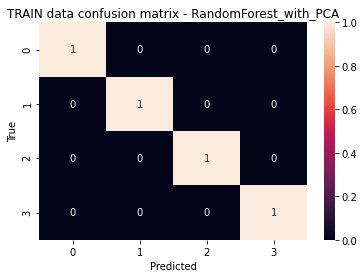

RandomForest_with_PCA
for TESTING DATA
Accuracy Score: 0.39492753623188404


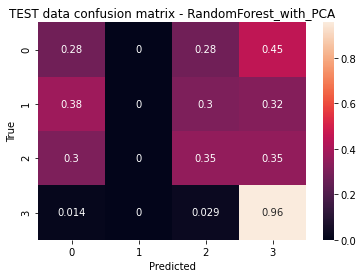

AdaBoost_no_PCA
for TRAINING DATA
Accuracy Score: 0.5589887640449438


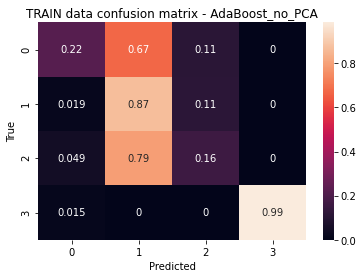

AdaBoost_no_PCA
for TESTING DATA
Accuracy Score: 0.5797101449275363


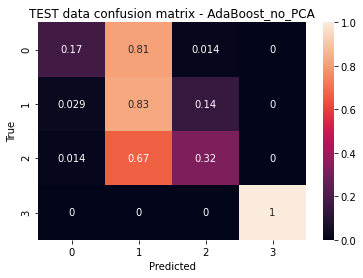

var_amplitude10.0HzCh1                               0.14
mean_amplitude46.0HzCh1                              0.14
mean_power80.0HzCh1                                  0.14
var_power6.0HzCh1                                    0.12
mean_power58.0HzCh1                                  0.06
                                                     ... 
mean_phase70.0HzCh3                                  0.00
mean_phase68.0HzCh3                                  0.00
mean_phase66.0HzCh3                                  0.00
mean_phase64.0HzCh3                                  0.00
var_phaseDifference_phase80.0HzCh2_phase80.0HzCh3    0.00
Length: 1482, dtype: float64
var_amplitude10.0HzCh1                               0.14
mean_amplitude46.0HzCh1                              0.14
mean_power80.0HzCh1                                  0.14
var_power6.0HzCh1                                    0.12
mean_power58.0HzCh1                                  0.06
var_phaseDifference_phase50.0HzCh1_phase50.

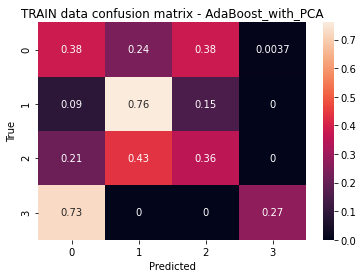

AdaBoost_with_PCA
for TESTING DATA
Accuracy Score: 0.39855072463768115


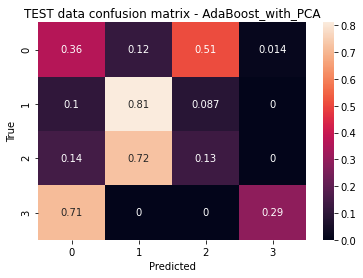

GradientBoosting_no_PCA
for TRAINING DATA
Accuracy Score: 1.0


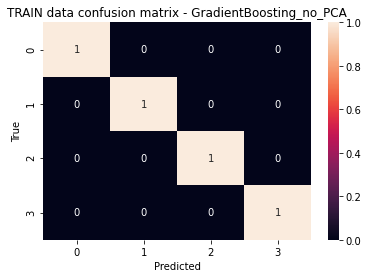

GradientBoosting_no_PCA
for TESTING DATA
Accuracy Score: 0.8188405797101449


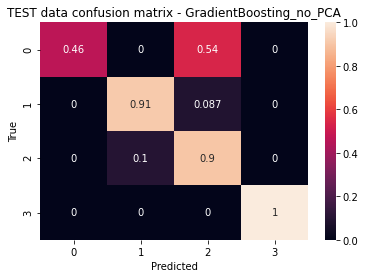

mean_amplitude46.0HzCh1                               0.227396
mean_Accelerometer_X                                  0.134242
var_Gyro_Z                                            0.127194
mean_Accelerometer_Z                                  0.078601
var_phase56.0HzCh0                                    0.035422
                                                        ...   
mean_phaseDifference_phase44.0HzCh0_phase44.0HzCh3    0.000000
mean_phaseDifference_phase44.0HzCh1_phase44.0HzCh2    0.000000
mean_phaseDifference_phase44.0HzCh2_phase44.0HzCh3    0.000000
mean_phaseDifference_phase46.0HzCh0_phase46.0HzCh2    0.000000
var_Delta_TP9                                         0.000000
Length: 1482, dtype: float64
mean_amplitude46.0HzCh1                               0.227396
mean_Accelerometer_X                                  0.134242
var_Gyro_Z                                            0.127194
mean_Accelerometer_Z                                  0.078601
var_phase56.0HzCh0        

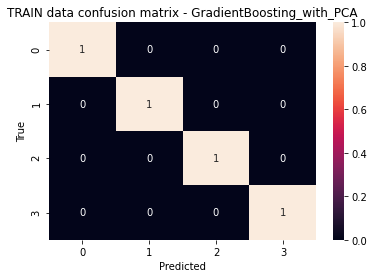

GradientBoosting_with_PCA
for TESTING DATA
Accuracy Score: 0.6086956521739131


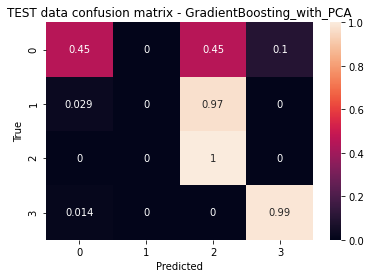

DecisionTree_no_PCA
for TRAINING DATA
Accuracy Score: 1.0


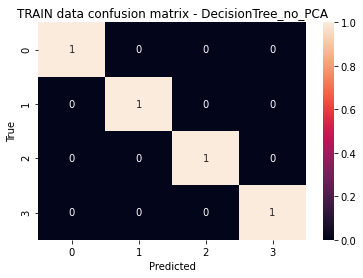

DecisionTree_no_PCA
for TESTING DATA
Accuracy Score: 0.7681159420289855


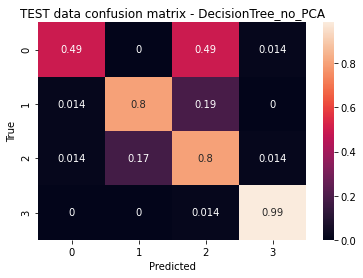

mean_amplitude46.0HzCh1                              0.294341
mean_Accelerometer_X                                 0.292399
var_Gyro_Z                                           0.160938
var_phase76.0HzCh1                                   0.031050
var_power4.0HzCh1                                    0.027965
                                                       ...   
mean_phase54.0HzCh3                                  0.000000
mean_phase52.0HzCh3                                  0.000000
mean_phase50.0HzCh3                                  0.000000
mean_phase48.0HzCh3                                  0.000000
var_phaseDifference_phase80.0HzCh2_phase80.0HzCh3    0.000000
Length: 1482, dtype: float64
mean_amplitude46.0HzCh1                               0.294341
mean_Accelerometer_X                                  0.292399
var_Gyro_Z                                            0.160938
var_phase76.0HzCh1                                    0.031050
var_power4.0HzCh1                    

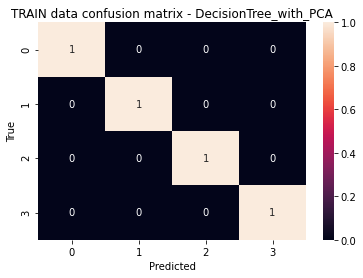

DecisionTree_with_PCA
for TESTING DATA
Accuracy Score: 0.4855072463768116


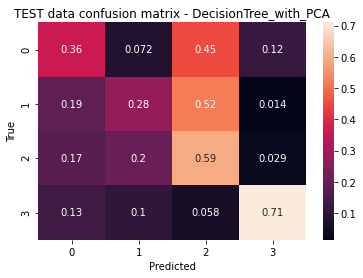

pipeline_name  \
0                  SVC_no_PCA   
1                SVC_with_PCA   
2                  LDA_no_PCA   
3                LDA_with_PCA   
4         RandomForest_no_PCA   
5       RandomForest_with_PCA   
6             AdaBoost_no_PCA   
7           AdaBoost_with_PCA   
8     GradientBoosting_no_PCA   
9   GradientBoosting_with_PCA   
10        DecisionTree_no_PCA   
11      DecisionTree_with_PCA   

                                          named_steps  train_acc_score  \
0          {'scaler': StandardScaler(), 'est': SVC()}         1.000000   
1   {'scaler': StandardScaler(), 'pca': PCA(), 'es...         1.000000   
2   {'scaler': StandardScaler(), 'est': LinearDisc...         1.000000   
3   {'scaler': StandardScaler(), 'pca': PCA(), 'es...         0.250000   
4   {'scaler': StandardScaler(), 'est': RandomFore...         1.000000   
5   {'scaler': StandardScaler(), 'pca': PCA(), 'es...         1.000000   
6   {'scaler': StandardScaler(), 'est': AdaBoostCl...         0.558989   
7   {'scaler': StandardScaler(), 'pca': PCA(), 'es...         0.442884   
8   {'scaler': StandardScaler(), 'est': GradientBo...         1.000000   
9   {'scaler': StandardScaler(), 'pca': PCA(), 'es...         1.000000   
10  {'scaler': StandardScaler(), 'est': DecisionTr...         1.000000   
11  {'scaler': StandardScaler(), 'pca': PCA(), 'es...         1.000000   

                               train_confusion_matrix  test_acc_score  \
0   [[1.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0], [...        0.782609   
1   [[1.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0], [...        0.786232   
2   [[1.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0], [...        0.565217   
3   [[0.0, 0.003745318352059925, 0.996254681647940...        0.253623   
4   [[1.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0], [...        0.836957   
5   [[1.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0], [...        0.394928   
6   [[0.2209737827715356, 0.6704119850187266, 0.10...        0.579710   
7   [[0.38202247191011235, 0.23595505617977527, 0....        0.398551   
8   [[1.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0], [...        0.818841   
9   [[1.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0], [...        0.608696   
10  [[1.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0], [...        0.768116   
11  [[1.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0], [...        0.485507   

                                test_confusion_matrix  
0   [[0.6811594202898551, 0.028985507246376812, 0....  
1   [[0.6811594202898551, 0.028985507246376812, 0....  
2   [[0.4492753623188406, 0.08695652173913043, 0.4...  
3   [[0.0, 0.5217391304347826, 0.4782608695652174,...  
4   [[0.6086956521739131, 0.0, 0.391304347826087, ...  
5   [[0.2753623188405797, 0.0, 0.2753623188405797,...  
6   [[0.17391304347826086, 0.8115942028985508, 0.0...  
7   [[0.36231884057971014, 0.11594202898550725, 0....  
8   [[0.463768115942029, 0.0, 0.5362318840579711, ...  
9   [[0.4492753623188406, 0.0, 0.4492753623188406,...  
10  [[0.4927536231884058, 0.0, 0.4927536231884058,...  
11  [[0.36231884057971014, 0.07246376811594203, 0....

In [82]:
model_metrics = []

print("unique target values:",np.unique(y_train))

for pipe_steps, name in zip([pipeline_1a_steps, pipeline_1b_steps, pipeline_2a_steps, pipeline_2b_steps, 
                         pipeline_3a_steps, pipeline_3b_steps, pipeline_4a_steps, pipeline_4b_steps,
                         pipeline_5a_steps, pipeline_5b_steps, pipeline_6a_steps, pipeline_6b_steps],
                         ["SVC_no_PCA","SVC_with_PCA","LDA_no_PCA","LDA_with_PCA",
                          "RandomForest_no_PCA","RandomForest_with_PCA","AdaBoost_no_PCA","AdaBoost_with_PCA",
                "GradientBoosting_no_PCA","GradientBoosting_with_PCA", "DecisionTree_no_PCA",  "DecisionTree_with_PCA"]):
  
  pipe = Pipeline(pipe_steps)
  pipe.fit(X_train, y_train)
  train_predictions = pipe.predict(X_train)
  test_preds = pipe.predict(X_test)

  model_metrics_dict = {'pipeline_name': name, 'named_steps': str(pipe.named_steps)}

  print(name)
  print("for TRAINING DATA")

  model_metrics_dict['train_acc_score'] = balanced_accuracy_score(y_train, train_predictions)
  model_metrics_dict['train_confusion_matrix'] = confusion_matrix(y_train, train_predictions, normalize='true')

  print("Accuracy Score:", model_metrics_dict['train_acc_score'])
  sns.heatmap(model_metrics_dict['train_confusion_matrix'], annot=True)
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.title('TRAIN data confusion matrix - '+name)
  plt.show()

  print(name)
  print("for TESTING DATA")

  model_metrics_dict['test_acc_score'] = balanced_accuracy_score(y_test, test_preds)
  model_metrics_dict['test_confusion_matrix'] = confusion_matrix(y_test, test_preds, normalize='true')
  
  print("Accuracy Score:", model_metrics_dict['test_acc_score'])
  sns.heatmap(model_metrics_dict['test_confusion_matrix'], annot=True)
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.title('TEST data confusion matrix - '+name)
  plt.show()

  if name in ["RandomForest_no_PCA", "AdaBoost_no_PCA" ,"GradientBoosting_no_PCA", "DecisionTree_no_PCA"]:
      feat_import = pd.Series(pipe.named_steps.est.feature_importances_, index= dataset.drop(['TARGET','ORIGINAL_ROW_NUM','ORIGINAL_FILE_NUM'], axis=1).columns)
      print(feat_import.sort_values(ascending=False))
      print(feat_import.sort_values(ascending=False).iloc[:30])

  model_metrics.append(model_metrics_dict)


model_metrics_df = pd.DataFrame( {'pipeline_name': [metrics['pipeline_name'] for metrics in model_metrics],
                                  'named_steps': [metrics['named_steps'] for metrics in model_metrics],
                                  'train_acc_score': [metrics['train_acc_score'] for metrics in model_metrics],
                                  'train_confusion_matrix': [metrics['train_confusion_matrix'] for metrics in model_metrics],
                                  'test_acc_score': [metrics['test_acc_score'] for metrics in model_metrics],
                                  'test_confusion_matrix': [metrics['test_confusion_matrix'] for metrics in model_metrics]} )

display(model_metrics_df)

model_metrics_df.to_csv('model_metrics\\M1_M3_M4_M5_experiment_agg_notOptimized_112samplesPerSession.csv')

RandomForest_no_PCA
for TRAINING DATA
Accuracy Score: 1.0


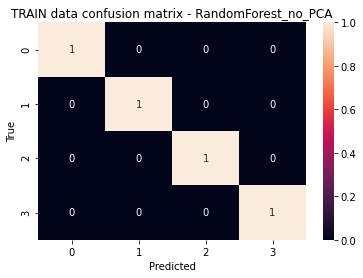

RandomForest_no_PCA
for TESTING DATA
Accuracy Score: 0.8514492753623188


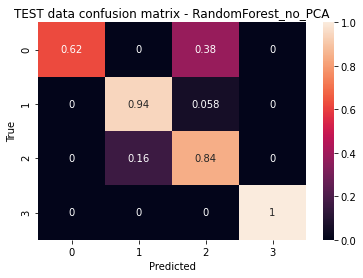

mean_amplitude42.0HzCh1    0.017894
var_Gyro_Z                 0.016344
mean_Accelerometer_X       0.016235
mean_Accelerometer_Z       0.016184
mean_power76.0HzCh1        0.015553
                             ...   
var_power48.0HzCh3         0.000000
mean_phase8.0HzCh1         0.000000
mean_phase20.0HzCh1        0.000000
var_power72.0HzCh3         0.000000
mean_power54.0HzCh2        0.000000
Length: 1482, dtype: float64
mean_amplitude42.0HzCh1                              0.017894
var_Gyro_Z                                           0.016344
mean_Accelerometer_X                                 0.016235
mean_Accelerometer_Z                                 0.016184
mean_power76.0HzCh1                                  0.015553
var_Accelerometer_Y                                  0.011988
mean_amplitude46.0HzCh1                              0.009561
mean_power66.0HzCh1                                  0.009557
mean_amplitude52.0HzCh1                              0.009548
mean_amplitude10.

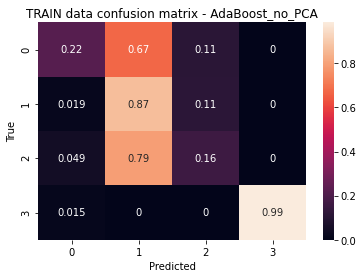

AdaBoost_no_PCA
for TESTING DATA
Accuracy Score: 0.5797101449275363


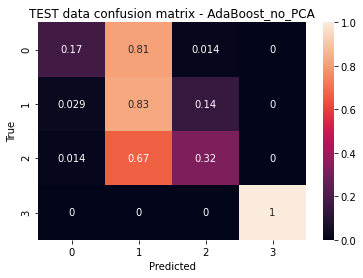

var_amplitude10.0HzCh1                               0.16
mean_amplitude46.0HzCh1                              0.14
mean_power80.0HzCh1                                  0.14
var_power6.0HzCh1                                    0.12
mean_power58.0HzCh1                                  0.06
                                                     ... 
mean_phase68.0HzCh3                                  0.00
mean_phase66.0HzCh3                                  0.00
mean_phase64.0HzCh3                                  0.00
mean_phase62.0HzCh3                                  0.00
var_phaseDifference_phase80.0HzCh2_phase80.0HzCh3    0.00
Length: 1482, dtype: float64
var_amplitude10.0HzCh1                               0.16
mean_amplitude46.0HzCh1                              0.14
mean_power80.0HzCh1                                  0.14
var_power6.0HzCh1                                    0.12
mean_power58.0HzCh1                                  0.06
var_phaseDifference_phase50.0HzCh1_phase50.

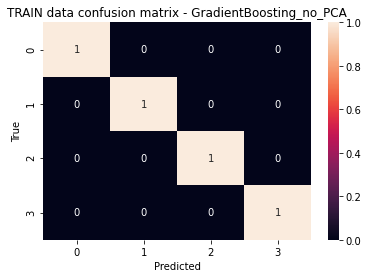

GradientBoosting_no_PCA
for TESTING DATA
Accuracy Score: 0.8188405797101449


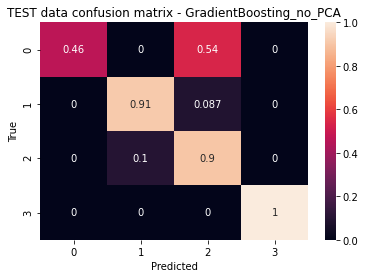

mean_amplitude46.0HzCh1                               0.227396
mean_Accelerometer_X                                  0.134635
var_Gyro_Z                                            0.127194
mean_Accelerometer_Z                                  0.080845
var_phase56.0HzCh0                                    0.035424
                                                        ...   
mean_phaseDifference_phase44.0HzCh2_phase44.0HzCh3    0.000000
mean_phaseDifference_phase46.0HzCh0_phase46.0HzCh1    0.000000
mean_phaseDifference_phase46.0HzCh0_phase46.0HzCh2    0.000000
mean_phaseDifference_phase46.0HzCh1_phase46.0HzCh2    0.000000
var_phaseDifference_phase80.0HzCh2_phase80.0HzCh3     0.000000
Length: 1482, dtype: float64
mean_amplitude46.0HzCh1                               0.227396
mean_Accelerometer_X                                  0.134635
var_Gyro_Z                                            0.127194
mean_Accelerometer_Z                                  0.080845
var_phase56.0HzCh0        

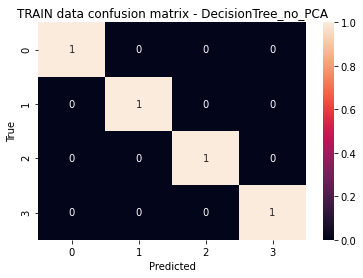

DecisionTree_no_PCA
for TESTING DATA
Accuracy Score: 0.7717391304347826


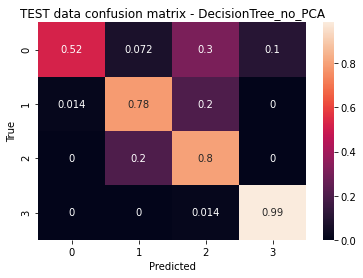

mean_amplitude46.0HzCh1                              0.294341
mean_Accelerometer_X                                 0.200917
var_Gyro_Z                                           0.160938
mean_Accelerometer_Z                                 0.096412
var_phase76.0HzCh1                                   0.031050
                                                       ...   
mean_phase68.0HzCh3                                  0.000000
mean_phase66.0HzCh3                                  0.000000
mean_phase64.0HzCh3                                  0.000000
mean_phase62.0HzCh3                                  0.000000
var_phaseDifference_phase80.0HzCh2_phase80.0HzCh3    0.000000
Length: 1482, dtype: float64
mean_amplitude46.0HzCh1                               0.294341
mean_Accelerometer_X                                  0.200917
var_Gyro_Z                                            0.160938
mean_Accelerometer_Z                                  0.096412
var_phase76.0HzCh1                   

In [83]:
for pipe_steps, name in zip([
                         pipeline_3a_steps, pipeline_4a_steps, 
                         pipeline_5a_steps, pipeline_6a_steps],
                         [
                          "RandomForest_no_PCA","AdaBoost_no_PCA",
                          "GradientBoosting_no_PCA", "DecisionTree_no_PCA"]):
  
  pipe = Pipeline(pipe_steps)
  pipe.fit(X_train, y_train)
  train_predictions = pipe.predict(X_train)
  test_preds = pipe.predict(X_test)

  model_metrics_dict = {'pipeline_name': name, 'named_steps': str(pipe.named_steps)}

  print(name)
  print("for TRAINING DATA")


  model_metrics_dict['train_acc_score'] = balanced_accuracy_score(y_train, train_predictions)
  model_metrics_dict['train_confusion_matrix'] = confusion_matrix(y_train, train_predictions, normalize='true')


  print("Accuracy Score:", model_metrics_dict['train_acc_score'])
  sns.heatmap(model_metrics_dict['train_confusion_matrix'], annot=True)
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.title('TRAIN data confusion matrix - '+name)
  plt.show()

  print(name)
  print("for TESTING DATA")


  model_metrics_dict['test_acc_score'] = balanced_accuracy_score(y_test, test_preds)
  model_metrics_dict['test_confusion_matrix'] = confusion_matrix(y_test, test_preds, normalize='true')
  

  print("Accuracy Score:", model_metrics_dict['test_acc_score'])
  sns.heatmap(model_metrics_dict['test_confusion_matrix'], annot=True)
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.title('TEST data confusion matrix - '+name)
  plt.show()

  feat_import = pd.Series(pipe.named_steps.est.feature_importances_, index= dataset.drop(['TARGET','ORIGINAL_ROW_NUM','ORIGINAL_FILE_NUM'], axis=1).columns)


  print(feat_import.sort_values(ascending=False))

  print(feat_import.sort_values(ascending=False).iloc[:30])

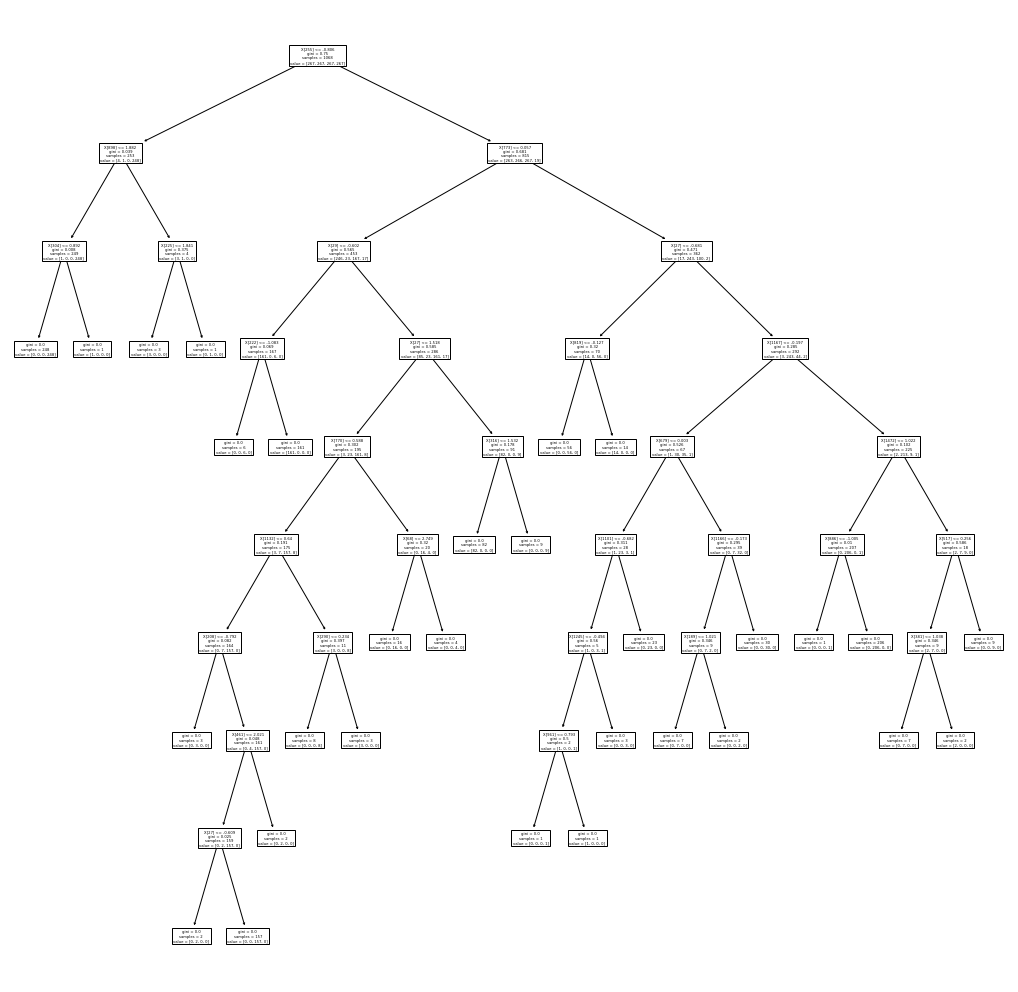

In [84]:
from sklearn.tree import plot_tree

plt.figure(figsize=(18,18))
plot_tree(pipe.named_steps.est)
plt.show()

In [ ]:
print('X[]:', temp[])
print('X[]:', temp[])

# <a name="exp7">  Experiment 7: M1, M4, M5 </a >

[back to top](#TOC)

In [85]:
outer1, outer2, outer3, outer4 = [],[],[],[]

for dataset in [M1_session0.iloc[:112], M1_session1.iloc[:112], M1_session2.iloc[:112], 
                M4_session0.iloc[:112], M4_session1.iloc[:112], M4_session2.iloc[:112], 
                M5_session0.iloc[:112], M5_session1.iloc[:112], M5_session2.iloc[:112]]:
  y = np.array(dataset['TARGET']).reshape(-1, 1)
  X = np.array(dataset.drop(['TARGET','ORIGINAL_ROW_NUM','ORIGINAL_FILE_NUM'], axis=1))

  print('y.shape',y.shape)

  X_train_subset, X_test_subset, y_train_subset, y_test_subset = train_test_split(X, y, test_size=0.2, shuffle=False)

  outer1.append(X_train_subset)
  outer2.append(X_test_subset)
  outer3.append(y_train_subset)
  outer4.append(y_test_subset)

X_train = np.vstack(outer1)
X_test = np.vstack(outer2)
y_train = np.vstack(outer3).ravel()
y_test = np.vstack(outer4).ravel()

print('X_train.shape', X_train.shape)
print('X_test.shape', X_test.shape)
print('y_train.shape',y_train.shape)
print('y_test.shape',y_test.shape)

y.shape (112, 1)
y.shape (112, 1)
y.shape (112, 1)
y.shape (112, 1)
y.shape (112, 1)
y.shape (112, 1)
y.shape (112, 1)
y.shape (112, 1)
y.shape (112, 1)
X_train.shape (801, 1482)
X_test.shape (207, 1482)
y_train.shape (801,)
y_test.shape (207,)


unique target values: [1 4 5]
SVC_no_PCA
for TRAINING DATA
Accuracy Score: 1.0


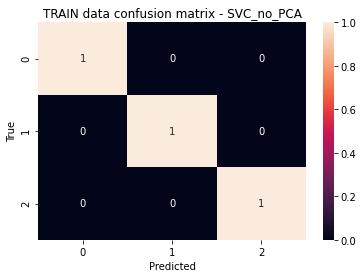

SVC_no_PCA
for TESTING DATA
Accuracy Score: 0.9033816425120773


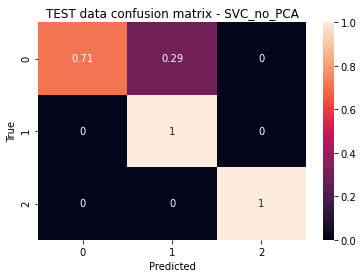

SVC_with_PCA
for TRAINING DATA
Accuracy Score: 1.0


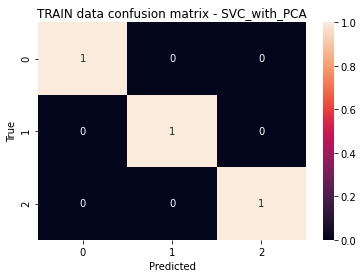

SVC_with_PCA
for TESTING DATA
Accuracy Score: 0.9082125603864735


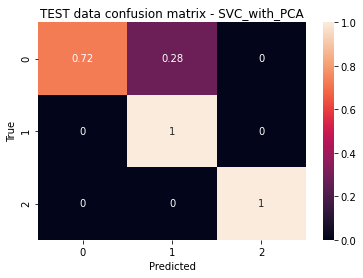

LDA_no_PCA
for TRAINING DATA
Accuracy Score: 1.0


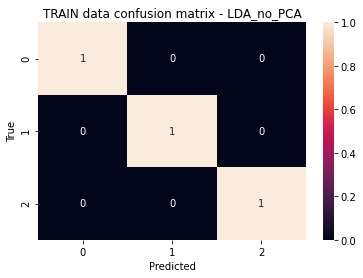

LDA_no_PCA
for TESTING DATA
Accuracy Score: 0.6859903381642513


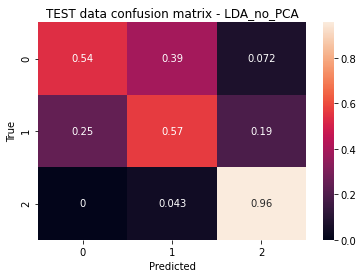

LDA_with_PCA
for TRAINING DATA
Accuracy Score: 0.3333333333333333


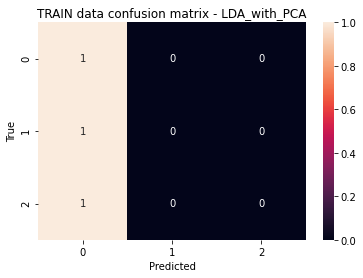

LDA_with_PCA
for TESTING DATA
Accuracy Score: 0.34782608695652173


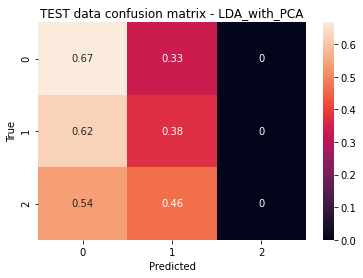

RandomForest_no_PCA
for TRAINING DATA
Accuracy Score: 1.0


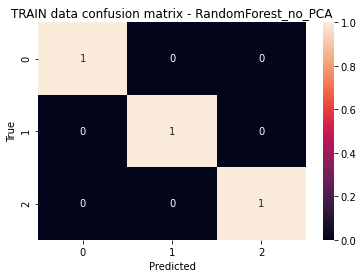

RandomForest_no_PCA
for TESTING DATA
Accuracy Score: 0.8647342995169082


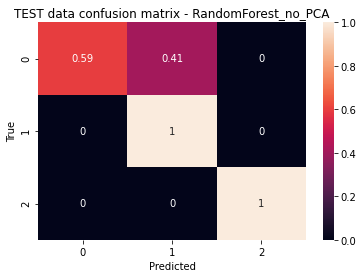

mean_amplitude38.0HzCh1                              0.025407
var_power58.0HzCh1                                   0.016695
var_phaseDifference_phase46.0HzCh1_phase46.0HzCh3    0.016690
mean_power70.0HzCh1                                  0.014641
mean_power60.0HzCh3                                  0.012836
                                                       ...   
mean_phase60.0HzCh2                                  0.000000
var_amplitude80.0HzCh3                               0.000000
var_power64.0HzCh0                                   0.000000
mean_phase64.0HzCh2                                  0.000000
mean_phase34.0HzCh2                                  0.000000
Length: 1482, dtype: float64
mean_amplitude38.0HzCh1                              0.025407
var_power58.0HzCh1                                   0.016695
var_phaseDifference_phase46.0HzCh1_phase46.0HzCh3    0.016690
mean_power70.0HzCh1                                  0.014641
mean_power60.0HzCh3                      

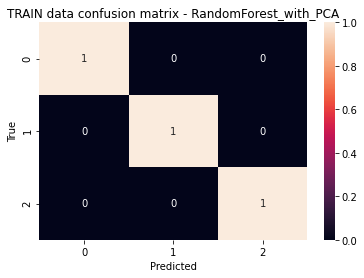

RandomForest_with_PCA
for TESTING DATA
Accuracy Score: 0.6328502415458938


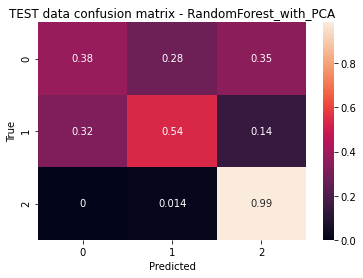

AdaBoost_no_PCA
for TRAINING DATA
Accuracy Score: 0.8002496878901374


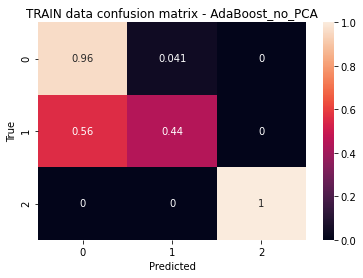

AdaBoost_no_PCA
for TESTING DATA
Accuracy Score: 0.8405797101449276


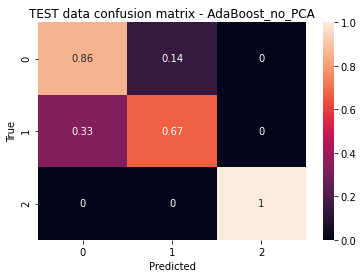

mean_amplitude72.0HzCh1                              0.06
var_phaseDifference_phase42.0HzCh1_phase42.0HzCh3    0.04
var_phaseDifference_phase8.0HzCh0_phase8.0HzCh1      0.04
mean_amplitude66.0HzCh1                              0.04
mean_amplitude58.0HzCh1                              0.04
                                                     ... 
mean_phase78.0HzCh3                                  0.00
mean_phase76.0HzCh3                                  0.00
mean_phase74.0HzCh3                                  0.00
mean_phase72.0HzCh3                                  0.00
var_phaseDifference_phase80.0HzCh2_phase80.0HzCh3    0.00
Length: 1482, dtype: float64
mean_amplitude72.0HzCh1                              0.06
var_phaseDifference_phase42.0HzCh1_phase42.0HzCh3    0.04
var_phaseDifference_phase8.0HzCh0_phase8.0HzCh1      0.04
mean_amplitude66.0HzCh1                              0.04
mean_amplitude58.0HzCh1                              0.04
mean_amplitude10.0HzCh3                    

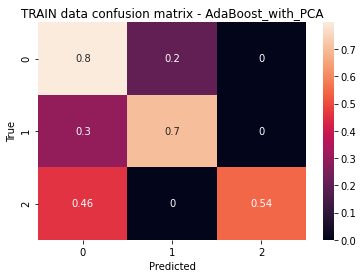

AdaBoost_with_PCA
for TESTING DATA
Accuracy Score: 0.6135265700483092


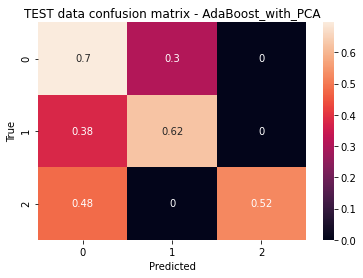

GradientBoosting_no_PCA
for TRAINING DATA
Accuracy Score: 1.0


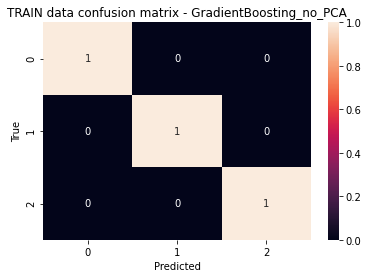

GradientBoosting_no_PCA
for TESTING DATA
Accuracy Score: 0.8309178743961353


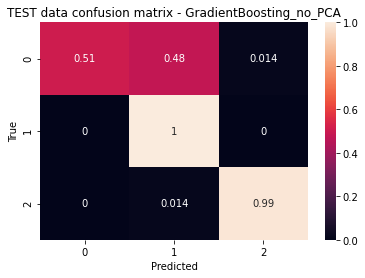

mean_power70.0HzCh1                                   0.324062
mean_Accelerometer_X                                  0.086848
var_phaseDifference_phase22.0HzCh1_phase22.0HzCh3     0.044245
var_power10.0HzCh3                                    0.037233
mean_power60.0HzCh3                                   0.035714
                                                        ...   
mean_phaseDifference_phase32.0HzCh1_phase32.0HzCh2    0.000000
mean_phaseDifference_phase32.0HzCh0_phase32.0HzCh2    0.000000
mean_phaseDifference_phase32.0HzCh0_phase32.0HzCh1    0.000000
mean_phaseDifference_phase30.0HzCh2_phase30.0HzCh3    0.000000
var_Delta_TP9                                         0.000000
Length: 1482, dtype: float64
mean_power70.0HzCh1                                   0.324062
mean_Accelerometer_X                                  0.086848
var_phaseDifference_phase22.0HzCh1_phase22.0HzCh3     0.044245
var_power10.0HzCh3                                    0.037233
mean_power60.0HzCh3       

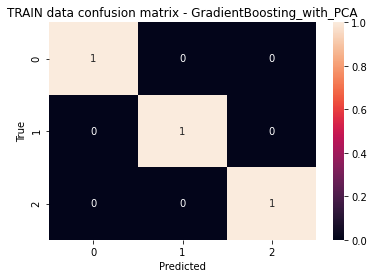

GradientBoosting_with_PCA
for TESTING DATA
Accuracy Score: 0.8164251207729469


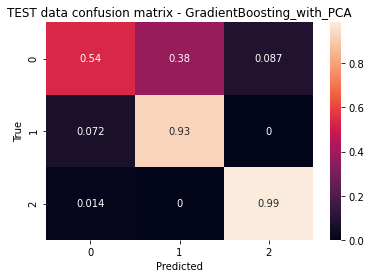

DecisionTree_no_PCA
for TRAINING DATA
Accuracy Score: 1.0


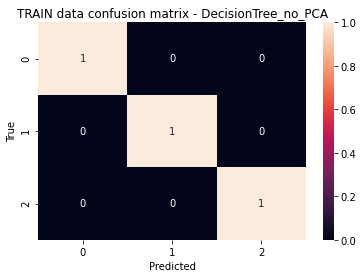

DecisionTree_no_PCA
for TESTING DATA
Accuracy Score: 0.8695652173913043


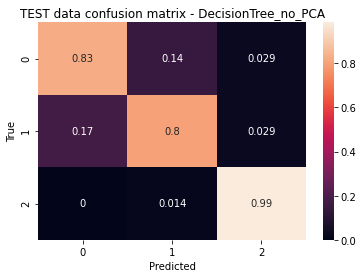

mean_power70.0HzCh1                                  0.442632
mean_Accelerometer_X                                 0.253872
var_power60.0HzCh3                                   0.132748
mean_amplitude62.0HzCh0                              0.058620
mean_Accelerometer_Y                                 0.035851
                                                       ...   
mean_phase60.0HzCh3                                  0.000000
mean_phase58.0HzCh3                                  0.000000
mean_phase56.0HzCh3                                  0.000000
mean_phase54.0HzCh3                                  0.000000
var_phaseDifference_phase80.0HzCh2_phase80.0HzCh3    0.000000
Length: 1482, dtype: float64
mean_power70.0HzCh1                                  0.442632
mean_Accelerometer_X                                 0.253872
var_power60.0HzCh3                                   0.132748
mean_amplitude62.0HzCh0                              0.058620
mean_Accelerometer_Y                     

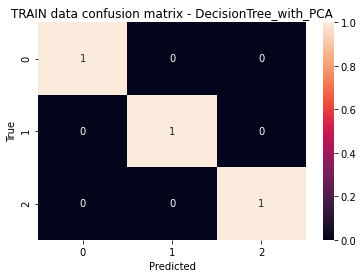

DecisionTree_with_PCA
for TESTING DATA
Accuracy Score: 0.6570048309178743


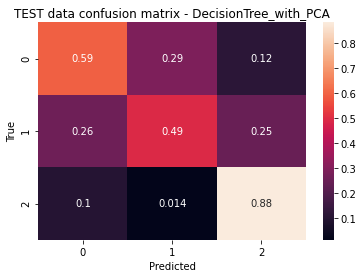

pipeline_name  \
0                  SVC_no_PCA   
1                SVC_with_PCA   
2                  LDA_no_PCA   
3                LDA_with_PCA   
4         RandomForest_no_PCA   
5       RandomForest_with_PCA   
6             AdaBoost_no_PCA   
7           AdaBoost_with_PCA   
8     GradientBoosting_no_PCA   
9   GradientBoosting_with_PCA   
10        DecisionTree_no_PCA   
11      DecisionTree_with_PCA   

                                          named_steps  train_acc_score  \
0          {'scaler': StandardScaler(), 'est': SVC()}         1.000000   
1   {'scaler': StandardScaler(), 'pca': PCA(), 'es...         1.000000   
2   {'scaler': StandardScaler(), 'est': LinearDisc...         1.000000   
3   {'scaler': StandardScaler(), 'pca': PCA(), 'es...         0.333333   
4   {'scaler': StandardScaler(), 'est': RandomFore...         1.000000   
5   {'scaler': StandardScaler(), 'pca': PCA(), 'es...         1.000000   
6   {'scaler': StandardScaler(), 'est': AdaBoostCl...         0.800250   
7   {'scaler': StandardScaler(), 'pca': PCA(), 'es...         0.681648   
8   {'scaler': StandardScaler(), 'est': GradientBo...         1.000000   
9   {'scaler': StandardScaler(), 'pca': PCA(), 'es...         1.000000   
10  {'scaler': StandardScaler(), 'est': DecisionTr...         1.000000   
11  {'scaler': StandardScaler(), 'pca': PCA(), 'es...         1.000000   

                               train_confusion_matrix  test_acc_score  \
0   [[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, ...        0.903382   
1   [[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, ...        0.908213   
2   [[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, ...        0.685990   
3   [[1.0, 0.0, 0.0], [1.0, 0.0, 0.0], [1.0, 0.0, ...        0.347826   
4   [[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, ...        0.864734   
5   [[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, ...        0.632850   
6   [[0.9588014981273408, 0.04119850187265917, 0.0...        0.840580   
7   [[0.797752808988764, 0.20224719101123595, 0.0]...        0.613527   
8   [[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, ...        0.830918   
9   [[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, ...        0.816425   
10  [[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, ...        0.869565   
11  [[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, ...        0.657005   

                                test_confusion_matrix  
0   [[0.7101449275362319, 0.2898550724637681, 0.0]...  
1   [[0.7246376811594203, 0.2753623188405797, 0.0]...  
2   [[0.5362318840579711, 0.391304347826087, 0.072...  
3   [[0.6666666666666666, 0.3333333333333333, 0.0]...  
4   [[0.5942028985507246, 0.4057971014492754, 0.0]...  
5   [[0.37681159420289856, 0.2753623188405797, 0.3...  
6   [[0.855072463768116, 0.14492753623188406, 0.0]...  
7   [[0.6956521739130435, 0.30434782608695654, 0.0...  
8   [[0.5072463768115942, 0.4782608695652174, 0.01...  
9   [[0.5362318840579711, 0.37681159420289856, 0.0...  
10  [[0.8260869565217391, 0.14492753623188406, 0.0...  
11  [[0.5942028985507246, 0.2898550724637681, 0.11...

In [86]:
model_metrics = []

print("unique target values:",np.unique(y_train))

for pipe_steps, name in zip([pipeline_1a_steps, pipeline_1b_steps, pipeline_2a_steps, pipeline_2b_steps, 
                         pipeline_3a_steps, pipeline_3b_steps, pipeline_4a_steps, pipeline_4b_steps,
                         pipeline_5a_steps, pipeline_5b_steps, pipeline_6a_steps, pipeline_6b_steps],
                         ["SVC_no_PCA","SVC_with_PCA","LDA_no_PCA","LDA_with_PCA",
                          "RandomForest_no_PCA","RandomForest_with_PCA","AdaBoost_no_PCA","AdaBoost_with_PCA",
                "GradientBoosting_no_PCA","GradientBoosting_with_PCA", "DecisionTree_no_PCA",  "DecisionTree_with_PCA"]):
  
  pipe = Pipeline(pipe_steps)
  pipe.fit(X_train, y_train)
  train_predictions = pipe.predict(X_train)
  test_preds = pipe.predict(X_test)

  model_metrics_dict = {'pipeline_name': name, 'named_steps': str(pipe.named_steps)}

  print(name)
  print("for TRAINING DATA")

  model_metrics_dict['train_acc_score'] = balanced_accuracy_score(y_train, train_predictions)
  model_metrics_dict['train_confusion_matrix'] = confusion_matrix(y_train, train_predictions, normalize='true')

  print("Accuracy Score:", model_metrics_dict['train_acc_score'])
  sns.heatmap(model_metrics_dict['train_confusion_matrix'], annot=True)
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.title('TRAIN data confusion matrix - '+name)
  plt.show()

  print(name)
  print("for TESTING DATA")

  model_metrics_dict['test_acc_score'] = balanced_accuracy_score(y_test, test_preds)
  model_metrics_dict['test_confusion_matrix'] = confusion_matrix(y_test, test_preds, normalize='true')
  
  print("Accuracy Score:", model_metrics_dict['test_acc_score'])
  sns.heatmap(model_metrics_dict['test_confusion_matrix'], annot=True)
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.title('TEST data confusion matrix - '+name)
  plt.show()

  if name in ["RandomForest_no_PCA", "AdaBoost_no_PCA" ,"GradientBoosting_no_PCA", "DecisionTree_no_PCA"]:
      feat_import = pd.Series(pipe.named_steps.est.feature_importances_, index= dataset.drop(['TARGET','ORIGINAL_ROW_NUM','ORIGINAL_FILE_NUM'], axis=1).columns)
      print(feat_import.sort_values(ascending=False))
      print(feat_import.sort_values(ascending=False).iloc[:30])

  model_metrics.append(model_metrics_dict)


model_metrics_df = pd.DataFrame( {'pipeline_name': [metrics['pipeline_name'] for metrics in model_metrics],
                                  'named_steps': [metrics['named_steps'] for metrics in model_metrics],
                                  'train_acc_score': [metrics['train_acc_score'] for metrics in model_metrics],
                                  'train_confusion_matrix': [metrics['train_confusion_matrix'] for metrics in model_metrics],
                                  'test_acc_score': [metrics['test_acc_score'] for metrics in model_metrics],
                                  'test_confusion_matrix': [metrics['test_confusion_matrix'] for metrics in model_metrics]} )

display(model_metrics_df)

model_metrics_df.to_csv('model_metrics\\M1_M4_M5_experiment_agg_notOptimized_112samplesPerSession.csv')

In [88]:
outer1, outer2, outer3, outer4 = [],[],[],[]

for dataset in [M1_session0.iloc[:169], M1_session1.iloc[:169], M1_session2.iloc[:169], 
                M4_session0.iloc[:169], M4_session1.iloc[:169], M4_session2.iloc[:169], 
                M5_session0.iloc[:169], M5_session1.iloc[:169], M5_session2.iloc[:169]]:
  y = np.array(dataset['TARGET']).reshape(-1, 1)
  X = np.array(dataset.drop(['TARGET','ORIGINAL_ROW_NUM','ORIGINAL_FILE_NUM'], axis=1))

  print('y.shape',y.shape)

  X_train_subset, X_test_subset, y_train_subset, y_test_subset = train_test_split(X, y, test_size=0.2, shuffle=False)

  outer1.append(X_train_subset)
  outer2.append(X_test_subset)
  outer3.append(y_train_subset)
  outer4.append(y_test_subset)

X_train = np.vstack(outer1)
X_test = np.vstack(outer2)
y_train = np.vstack(outer3).ravel()
y_test = np.vstack(outer4).ravel()

print('X_train.shape', X_train.shape)
print('X_test.shape', X_test.shape)
print('y_train.shape',y_train.shape)
print('y_test.shape',y_test.shape)

y.shape (169, 1)
y.shape (169, 1)
y.shape (169, 1)
y.shape (169, 1)
y.shape (169, 1)
y.shape (169, 1)
y.shape (169, 1)
y.shape (169, 1)
y.shape (169, 1)
X_train.shape (1215, 1482)
X_test.shape (306, 1482)
y_train.shape (1215,)
y_test.shape (306,)


unique target values: [1 4 5]
SVC_no_PCA
for TRAINING DATA
Accuracy Score: 1.0


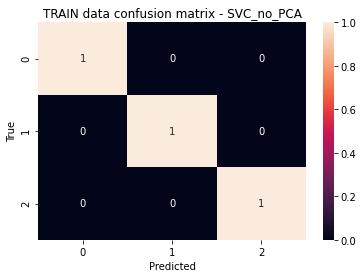

SVC_no_PCA
for TESTING DATA
Accuracy Score: 0.8300653594771242


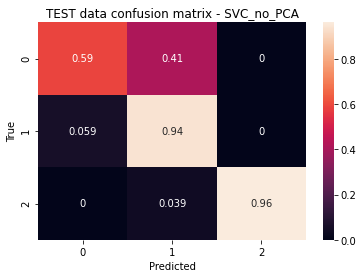

SVC_with_PCA
for TRAINING DATA
Accuracy Score: 1.0


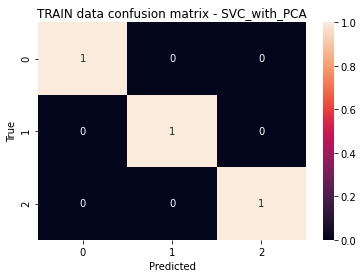

SVC_with_PCA
for TESTING DATA
Accuracy Score: 0.8300653594771242


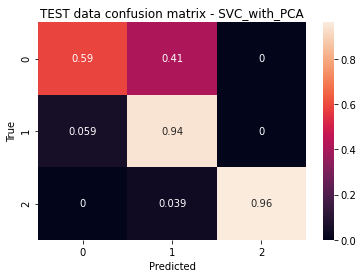

LDA_no_PCA
for TRAINING DATA
Accuracy Score: 1.0


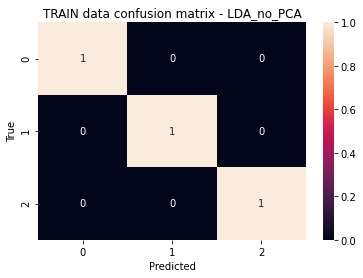

LDA_no_PCA
for TESTING DATA
Accuracy Score: 0.5620915032679739


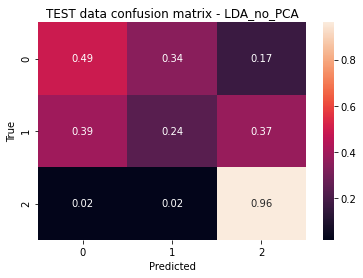

LDA_with_PCA
for TRAINING DATA
Accuracy Score: 0.33827160493827163


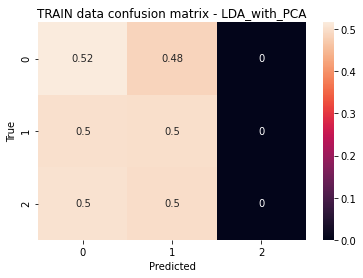

LDA_with_PCA
for TESTING DATA
Accuracy Score: 0.3594771241830066


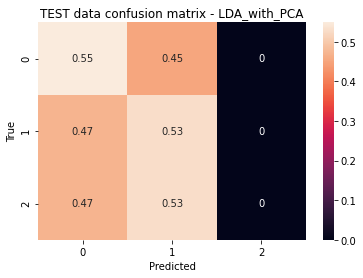

RandomForest_no_PCA
for TRAINING DATA
Accuracy Score: 1.0


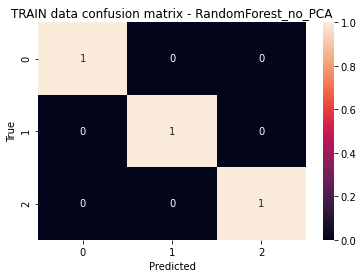

RandomForest_no_PCA
for TESTING DATA
Accuracy Score: 0.7908496732026143


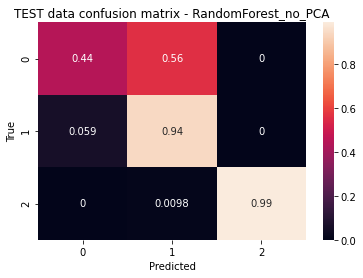

mean_power46.0HzCh1                                   0.018098
mean_power44.0HzCh1                                   0.017617
mean_amplitude54.0HzCh1                               0.016798
mean_power72.0HzCh1                                   0.014427
mean_power62.0HzCh1                                   0.013831
                                                        ...   
mean_phaseDifference_phase36.0HzCh2_phase36.0HzCh3    0.000000
var_phase36.0HzCh3                                    0.000000
var_Theta_AF7                                         0.000000
var_phase72.0HzCh3                                    0.000000
var_amplitude6.0HzCh3                                 0.000000
Length: 1482, dtype: float64
mean_power46.0HzCh1                                  0.018098
mean_power44.0HzCh1                                  0.017617
mean_amplitude54.0HzCh1                              0.016798
mean_power72.0HzCh1                                  0.014427
mean_power62.0HzCh1           

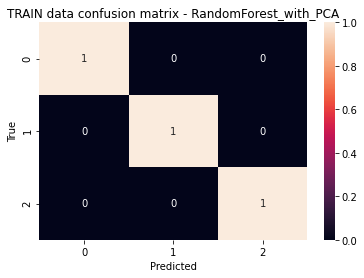

RandomForest_with_PCA
for TESTING DATA
Accuracy Score: 0.5522875816993463


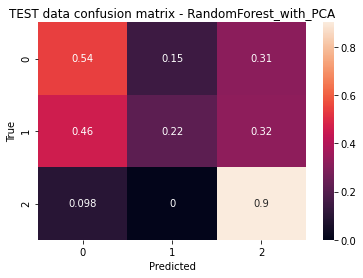

AdaBoost_no_PCA
for TRAINING DATA
Accuracy Score: 0.7810699588477367


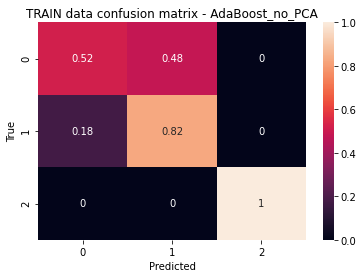

AdaBoost_no_PCA
for TESTING DATA
Accuracy Score: 0.7058823529411765


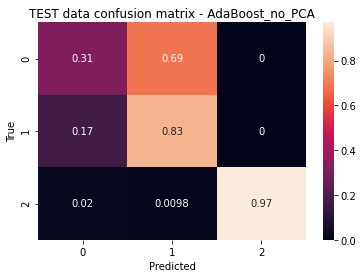

mean_power72.0HzCh1                                  0.06
mean_power70.0HzCh1                                  0.04
mean_phase74.0HzCh0                                  0.04
var_phaseDifference_phase22.0HzCh1_phase22.0HzCh3    0.04
mean_amplitude80.0HzCh1                              0.04
                                                     ... 
mean_phase78.0HzCh3                                  0.00
mean_phase76.0HzCh3                                  0.00
mean_phase74.0HzCh3                                  0.00
mean_phase72.0HzCh3                                  0.00
var_phaseDifference_phase80.0HzCh2_phase80.0HzCh3    0.00
Length: 1482, dtype: float64
mean_power72.0HzCh1                                   0.06
mean_power70.0HzCh1                                   0.04
mean_phase74.0HzCh0                                   0.04
var_phaseDifference_phase22.0HzCh1_phase22.0HzCh3     0.04
mean_amplitude80.0HzCh1                               0.04
mean_amplitude10.0HzCh3               

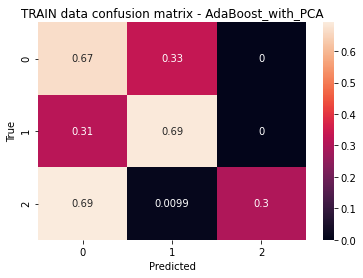

AdaBoost_with_PCA
for TESTING DATA
Accuracy Score: 0.4542483660130719


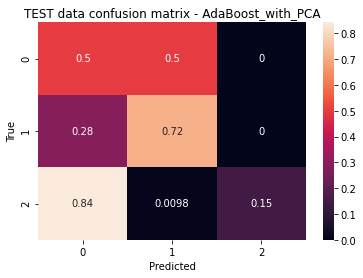

GradientBoosting_no_PCA
for TRAINING DATA
Accuracy Score: 1.0


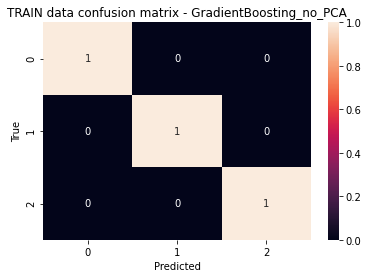

GradientBoosting_no_PCA
for TESTING DATA
Accuracy Score: 0.7450980392156863


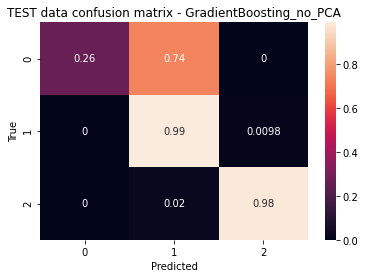

mean_power70.0HzCh1                                   0.336388
mean_Accelerometer_X                                  0.101613
mean_Alpha_TP10                                       0.080779
var_phaseDifference_phase22.0HzCh1_phase22.0HzCh3     0.052739
var_phaseDifference_phase62.0HzCh1_phase62.0HzCh3     0.041341
                                                        ...   
mean_phaseDifference_phase28.0HzCh1_phase28.0HzCh3    0.000000
mean_phaseDifference_phase28.0HzCh1_phase28.0HzCh2    0.000000
mean_phaseDifference_phase28.0HzCh0_phase28.0HzCh3    0.000000
mean_phaseDifference_phase28.0HzCh0_phase28.0HzCh2    0.000000
var_phaseDifference_phase80.0HzCh2_phase80.0HzCh3     0.000000
Length: 1482, dtype: float64
mean_power70.0HzCh1                                  0.336388
mean_Accelerometer_X                                 0.101613
mean_Alpha_TP10                                      0.080779
var_phaseDifference_phase22.0HzCh1_phase22.0HzCh3    0.052739
var_phaseDifference_phase62.0H

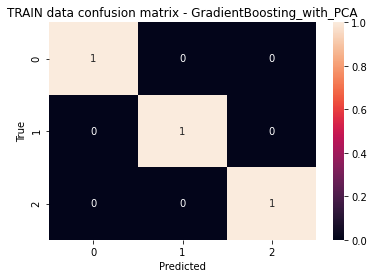

GradientBoosting_with_PCA
for TESTING DATA
Accuracy Score: 0.738562091503268


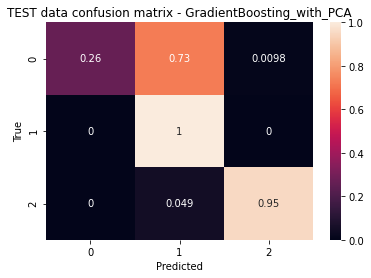

DecisionTree_no_PCA
for TRAINING DATA
Accuracy Score: 1.0


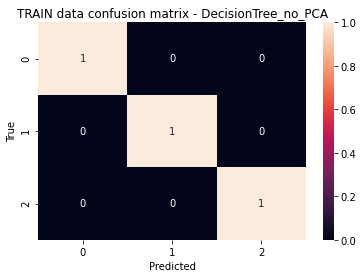

DecisionTree_no_PCA
for TESTING DATA
Accuracy Score: 0.7222222222222222


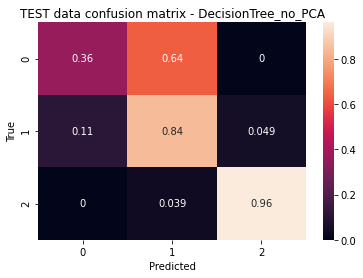

mean_power70.0HzCh1                                  0.458230
mean_Accelerometer_X                                 0.210750
var_power60.0HzCh3                                   0.142713
mean_Accelerometer_Y                                 0.027340
var_amplitude6.0HzCh1                                0.026473
                                                       ...   
mean_phase62.0HzCh3                                  0.000000
mean_phase60.0HzCh3                                  0.000000
mean_phase58.0HzCh3                                  0.000000
mean_phase56.0HzCh3                                  0.000000
var_phaseDifference_phase80.0HzCh2_phase80.0HzCh3    0.000000
Length: 1482, dtype: float64
mean_power70.0HzCh1                                   0.458230
mean_Accelerometer_X                                  0.210750
var_power60.0HzCh3                                    0.142713
mean_Accelerometer_Y                                  0.027340
var_amplitude6.0HzCh1                

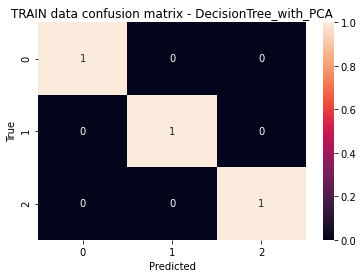

DecisionTree_with_PCA
for TESTING DATA
Accuracy Score: 0.6143790849673203


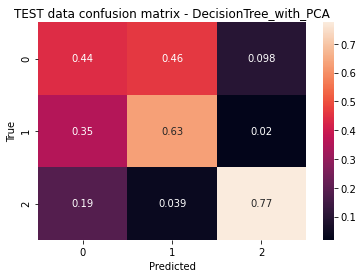

pipeline_name  \
0                  SVC_no_PCA   
1                SVC_with_PCA   
2                  LDA_no_PCA   
3                LDA_with_PCA   
4         RandomForest_no_PCA   
5       RandomForest_with_PCA   
6             AdaBoost_no_PCA   
7           AdaBoost_with_PCA   
8     GradientBoosting_no_PCA   
9   GradientBoosting_with_PCA   
10        DecisionTree_no_PCA   
11      DecisionTree_with_PCA   

                                          named_steps  train_acc_score  \
0          {'scaler': StandardScaler(), 'est': SVC()}         1.000000   
1   {'scaler': StandardScaler(), 'pca': PCA(), 'es...         1.000000   
2   {'scaler': StandardScaler(), 'est': LinearDisc...         1.000000   
3   {'scaler': StandardScaler(), 'pca': PCA(), 'es...         0.338272   
4   {'scaler': StandardScaler(), 'est': RandomFore...         1.000000   
5   {'scaler': StandardScaler(), 'pca': PCA(), 'es...         1.000000   
6   {'scaler': StandardScaler(), 'est': AdaBoostCl...         0.781070   
7   {'scaler': StandardScaler(), 'pca': PCA(), 'es...         0.550617   
8   {'scaler': StandardScaler(), 'est': GradientBo...         1.000000   
9   {'scaler': StandardScaler(), 'pca': PCA(), 'es...         1.000000   
10  {'scaler': StandardScaler(), 'est': DecisionTr...         1.000000   
11  {'scaler': StandardScaler(), 'pca': PCA(), 'es...         1.000000   

                               train_confusion_matrix  test_acc_score  \
0   [[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, ...        0.830065   
1   [[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, ...        0.830065   
2   [[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, ...        0.562092   
3   [[0.5160493827160494, 0.4839506172839506, 0.0]...        0.359477   
4   [[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, ...        0.790850   
5   [[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, ...        0.552288   
6   [[0.5185185185185185, 0.48148148148148145, 0.0...        0.705882   
7   [[0.6666666666666666, 0.3333333333333333, 0.0]...        0.454248   
8   [[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, ...        0.745098   
9   [[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, ...        0.738562   
10  [[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, ...        0.722222   
11  [[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, ...        0.614379   

                                test_confusion_matrix  
0   [[0.5882352941176471, 0.4117647058823529, 0.0]...  
1   [[0.5882352941176471, 0.4117647058823529, 0.0]...  
2   [[0.49019607843137253, 0.3431372549019608, 0.1...  
3   [[0.5490196078431373, 0.45098039215686275, 0.0...  
4   [[0.4411764705882353, 0.5588235294117647, 0.0]...  
5   [[0.5392156862745098, 0.14705882352941177, 0.3...  
6   [[0.3137254901960784, 0.6862745098039216, 0.0]...  
7   [[0.5, 0.5, 0.0], [0.28431372549019607, 0.7156...  
8   [[0.2647058823529412, 0.7352941176470589, 0.0]...  
9   [[0.2647058823529412, 0.7254901960784313, 0.00...  
10  [[0.3627450980392157, 0.6372549019607843, 0.0]...  
11  [[0.4411764705882353, 0.46078431372549017, 0.0...

In [89]:
model_metrics = []

print("unique target values:",np.unique(y_train))

for pipe_steps, name in zip([pipeline_1a_steps, pipeline_1b_steps, pipeline_2a_steps, pipeline_2b_steps, 
                         pipeline_3a_steps, pipeline_3b_steps, pipeline_4a_steps, pipeline_4b_steps,
                         pipeline_5a_steps, pipeline_5b_steps, pipeline_6a_steps, pipeline_6b_steps],
                         ["SVC_no_PCA","SVC_with_PCA","LDA_no_PCA","LDA_with_PCA",
                          "RandomForest_no_PCA","RandomForest_with_PCA","AdaBoost_no_PCA","AdaBoost_with_PCA",
                "GradientBoosting_no_PCA","GradientBoosting_with_PCA", "DecisionTree_no_PCA",  "DecisionTree_with_PCA"]):
  
  pipe = Pipeline(pipe_steps)
  pipe.fit(X_train, y_train)
  train_predictions = pipe.predict(X_train)
  test_preds = pipe.predict(X_test)

  model_metrics_dict = {'pipeline_name': name, 'named_steps': str(pipe.named_steps)}

  print(name)
  print("for TRAINING DATA")

  model_metrics_dict['train_acc_score'] = balanced_accuracy_score(y_train, train_predictions)
  model_metrics_dict['train_confusion_matrix'] = confusion_matrix(y_train, train_predictions, normalize='true')

  print("Accuracy Score:", model_metrics_dict['train_acc_score'])
  sns.heatmap(model_metrics_dict['train_confusion_matrix'], annot=True)
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.title('TRAIN data confusion matrix - '+name)
  plt.show()

  print(name)
  print("for TESTING DATA")

  model_metrics_dict['test_acc_score'] = balanced_accuracy_score(y_test, test_preds)
  model_metrics_dict['test_confusion_matrix'] = confusion_matrix(y_test, test_preds, normalize='true')
  
  print("Accuracy Score:", model_metrics_dict['test_acc_score'])
  sns.heatmap(model_metrics_dict['test_confusion_matrix'], annot=True)
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.title('TEST data confusion matrix - '+name)
  plt.show()

  if name in ["RandomForest_no_PCA", "AdaBoost_no_PCA" ,"GradientBoosting_no_PCA", "DecisionTree_no_PCA"]:
      feat_import = pd.Series(pipe.named_steps.est.feature_importances_, index= dataset.drop(['TARGET','ORIGINAL_ROW_NUM','ORIGINAL_FILE_NUM'], axis=1).columns)
      print(feat_import.sort_values(ascending=False))
      print(feat_import.sort_values(ascending=False).iloc[:30])

  model_metrics.append(model_metrics_dict)


model_metrics_df = pd.DataFrame( {'pipeline_name': [metrics['pipeline_name'] for metrics in model_metrics],
                                  'named_steps': [metrics['named_steps'] for metrics in model_metrics],
                                  'train_acc_score': [metrics['train_acc_score'] for metrics in model_metrics],
                                  'train_confusion_matrix': [metrics['train_confusion_matrix'] for metrics in model_metrics],
                                  'test_acc_score': [metrics['test_acc_score'] for metrics in model_metrics],
                                  'test_confusion_matrix': [metrics['test_confusion_matrix'] for metrics in model_metrics]} )

display(model_metrics_df)

model_metrics_df.to_csv('model_metrics\\M1_M4_M5_experiment_agg_notOptimized_169samplesPerSession.csv')

# <a name="exp8">  Experiment 8: M1, M4, M5 with trying log2 subsets of features and trying subsamples of 0.8 </a >

[back to top](#TOC)

In [93]:
outer1, outer2, outer3, outer4 = [],[],[],[]

for dataset in [M1_session0.iloc[:169], M1_session1.iloc[:169], M1_session2.iloc[:169], 
                M4_session0.iloc[:169], M4_session1.iloc[:169], M4_session2.iloc[:169], 
                M5_session0.iloc[:169], M5_session1.iloc[:169], M5_session2.iloc[:169]]:
  y = np.array(dataset['TARGET']).reshape(-1, 1)
  X = np.array(dataset.drop(['TARGET','ORIGINAL_ROW_NUM','ORIGINAL_FILE_NUM'], axis=1))

  print('y.shape',y.shape)

  X_train_subset, X_test_subset, y_train_subset, y_test_subset = train_test_split(X, y, test_size=0.2, shuffle=False)

  outer1.append(X_train_subset)
  outer2.append(X_test_subset)
  outer3.append(y_train_subset)
  outer4.append(y_test_subset)

X_train = np.vstack(outer1)
X_test = np.vstack(outer2)
y_train = np.vstack(outer3).ravel()
y_test = np.vstack(outer4).ravel()

print('X_train.shape', X_train.shape)
print('X_test.shape', X_test.shape)
print('y_train.shape',y_train.shape)
print('y_test.shape',y_test.shape)

y.shape (169, 1)
y.shape (169, 1)
y.shape (169, 1)
y.shape (169, 1)
y.shape (169, 1)
y.shape (169, 1)
y.shape (169, 1)
y.shape (169, 1)
y.shape (169, 1)
X_train.shape (1215, 1482)
X_test.shape (306, 1482)
y_train.shape (1215,)
y_test.shape (306,)


unique target values: [1 4 5]
RandomForest_maxdepth3
for TRAINING DATA
Accuracy Score: 0.934156378600823


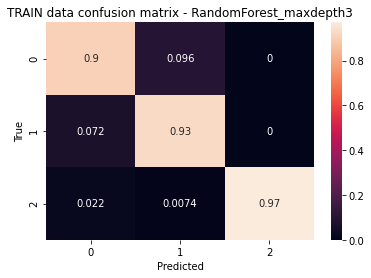

RandomForest_maxdepth3
for TESTING DATA
Accuracy Score: 0.7679738562091503


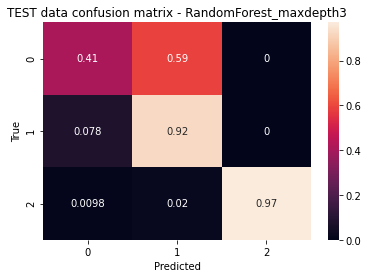

mean_power70.0HzCh1                                   0.019599
mean_amplitude44.0HzCh1                               0.019495
mean_amplitude46.0HzCh1                               0.018492
mean_power44.0HzCh1                                   0.018264
mean_power76.0HzCh1                                   0.016783
                                                        ...   
mean_phase40.0HzCh1                                   0.000000
var_amplitude10.0HzCh2                                0.000000
mean_phaseDifference_phase26.0HzCh0_phase26.0HzCh2    0.000000
var_phase66.0HzCh3                                    0.000000
mean_phaseDifference_phase30.0HzCh1_phase30.0HzCh3    0.000000
Length: 1482, dtype: float64
mean_power70.0HzCh1        0.019599
mean_amplitude44.0HzCh1    0.019495
mean_amplitude46.0HzCh1    0.018492
mean_power44.0HzCh1        0.018264
mean_power76.0HzCh1        0.016783
var_amplitude44.0HzCh1     0.014210
mean_amplitude10.0HzCh3    0.013405
mean_amplitude38.0HzCh1   

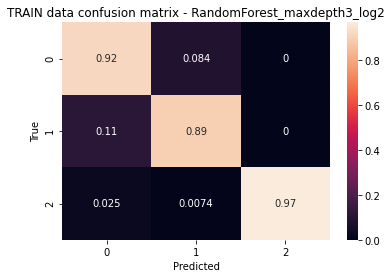

RandomForest_maxdepth3_log2
for TESTING DATA
Accuracy Score: 0.7973856209150326


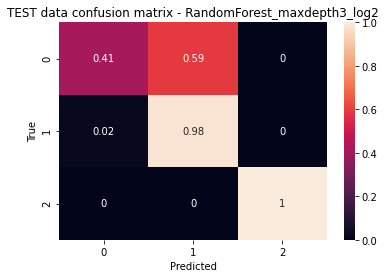

mean_power44.0HzCh1                                   0.010055
mean_power72.0HzCh1                                   0.008331
mean_amplitude44.0HzCh1                               0.008229
mean_power58.0HzCh1                                   0.007938
mean_amplitude38.0HzCh1                               0.007863
                                                        ...   
mean_phase10.0HzCh1                                   0.000000
mean_phaseDifference_phase28.0HzCh1_phase28.0HzCh3    0.000000
mean_phaseDifference_phase30.0HzCh0_phase30.0HzCh2    0.000000
mean_phaseDifference_phase30.0HzCh2_phase30.0HzCh3    0.000000
var_power78.0HzCh3                                    0.000000
Length: 1482, dtype: float64
mean_power44.0HzCh1        0.010055
mean_power72.0HzCh1        0.008331
mean_amplitude44.0HzCh1    0.008229
mean_power58.0HzCh1        0.007938
mean_amplitude38.0HzCh1    0.007863
mean_power10.0HzCh3        0.007693
mean_power76.0HzCh1        0.007676
mean_power74.0HzCh1       

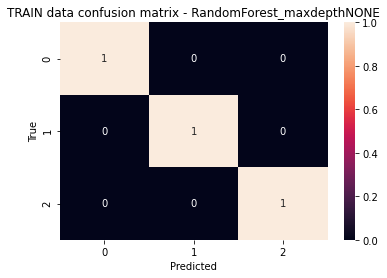

RandomForest_maxdepthNONE
for TESTING DATA
Accuracy Score: 0.7875816993464052


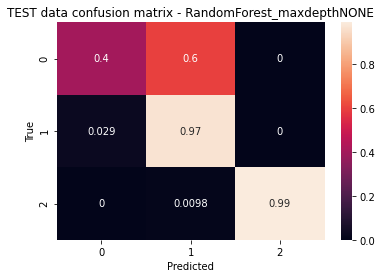

mean_power70.0HzCh1        0.014651
mean_amplitude44.0HzCh1    0.012489
mean_power44.0HzCh1        0.012428
mean_amplitude42.0HzCh1    0.011837
mean_power58.0HzCh1        0.011297
                             ...   
var_HSI_AF8                0.000000
mean_Battery               0.000000
mean_HSI_AF8               0.000000
mean_HeadBandOn            0.000000
var_Battery                0.000000
Length: 1482, dtype: float64
mean_power70.0HzCh1                                  0.014651
mean_amplitude44.0HzCh1                              0.012489
mean_power44.0HzCh1                                  0.012428
mean_amplitude42.0HzCh1                              0.011837
mean_power58.0HzCh1                                  0.011297
mean_Accelerometer_X                                 0.010790
mean_power72.0HzCh1                                  0.010262
mean_power76.0HzCh1                                  0.010106
mean_power80.0HzCh1                                  0.009973
mean_amplitude10.

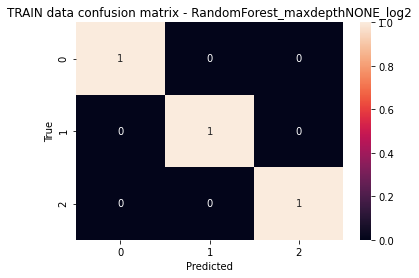

RandomForest_maxdepthNONE_log2
for TESTING DATA
Accuracy Score: 0.7973856209150326


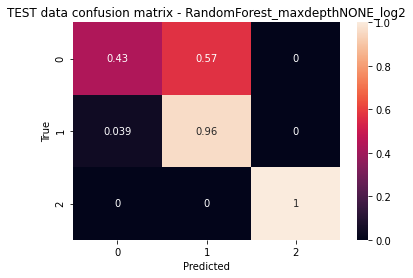

mean_power76.0HzCh1        0.005321
mean_amplitude58.0HzCh1    0.005066
mean_amplitude46.0HzCh1    0.004872
mean_amplitude44.0HzCh1    0.004731
mean_Gamma_AF7             0.004673
                             ...   
var_HSI_AF8                0.000000
mean_Battery               0.000000
mean_HSI_AF8               0.000000
mean_HeadBandOn            0.000000
var_HeadBandOn             0.000000
Length: 1482, dtype: float64
mean_power76.0HzCh1                                  0.005321
mean_amplitude58.0HzCh1                              0.005066
mean_amplitude46.0HzCh1                              0.004872
mean_amplitude44.0HzCh1                              0.004731
mean_Gamma_AF7                                       0.004673
mean_amplitude10.0HzCh3                              0.004633
mean_power60.0HzCh3                                  0.004585
mean_amplitude60.0HzCh3                              0.004568
mean_amplitude66.0HzCh1                              0.004546
mean_power44.0HzC

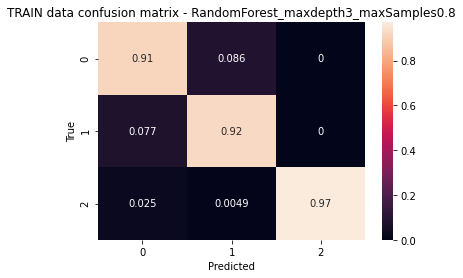

RandomForest_maxdepth3_maxSamples0.8
for TESTING DATA
Accuracy Score: 0.7941176470588235


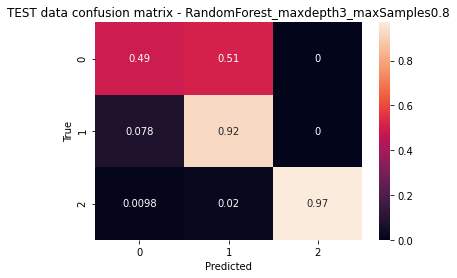

mean_power76.0HzCh1                                   0.021100
mean_power70.0HzCh1                                   0.019319
mean_amplitude42.0HzCh1                               0.018196
mean_power44.0HzCh1                                   0.017269
mean_amplitude46.0HzCh1                               0.015733
                                                        ...   
mean_phase44.0HzCh0                                   0.000000
mean_phaseDifference_phase32.0HzCh0_phase32.0HzCh1    0.000000
mean_phaseDifference_phase30.0HzCh2_phase30.0HzCh3    0.000000
mean_phaseDifference_phase28.0HzCh2_phase28.0HzCh3    0.000000
mean_phaseDifference_phase52.0HzCh1_phase52.0HzCh3    0.000000
Length: 1482, dtype: float64
mean_power76.0HzCh1        0.021100
mean_power70.0HzCh1        0.019319
mean_amplitude42.0HzCh1    0.018196
mean_power44.0HzCh1        0.017269
mean_amplitude46.0HzCh1    0.015733
mean_power72.0HzCh1        0.014893
mean_power68.0HzCh1        0.014478
mean_power80.0HzCh1       

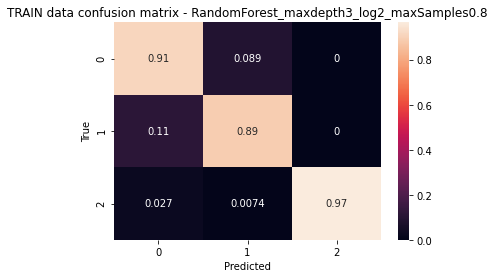

RandomForest_maxdepth3_log2_maxSamples0.8
for TESTING DATA
Accuracy Score: 0.8104575163398694


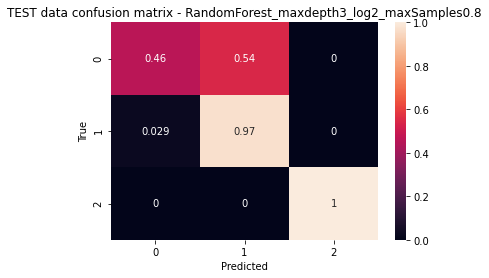

var_power44.0HzCh1                                    0.008802
mean_power10.0HzCh3                                   0.008727
mean_power58.0HzCh1                                   0.008053
mean_power70.0HzCh1                                   0.006940
mean_power76.0HzCh1                                   0.006863
                                                        ...   
mean_phase44.0HzCh3                                   0.000000
mean_phase50.0HzCh3                                   0.000000
mean_phase54.0HzCh3                                   0.000000
var_phaseDifference_phase36.0HzCh0_phase36.0HzCh3     0.000000
mean_phaseDifference_phase42.0HzCh1_phase42.0HzCh2    0.000000
Length: 1482, dtype: float64
var_power44.0HzCh1         0.008802
mean_power10.0HzCh3        0.008727
mean_power58.0HzCh1        0.008053
mean_power70.0HzCh1        0.006940
mean_power76.0HzCh1        0.006863
mean_amplitude58.0HzCh1    0.006852
var_power76.0HzCh1         0.006822
mean_amplitude44.0HzCh1   

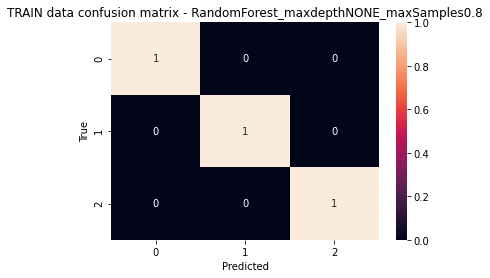

RandomForest_maxdepthNONE_maxSamples0.8
for TESTING DATA
Accuracy Score: 0.7908496732026143


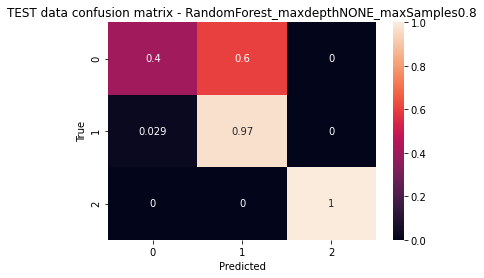

mean_power76.0HzCh1        0.013369
mean_power70.0HzCh1        0.012185
var_power44.0HzCh1         0.011194
mean_power44.0HzCh1        0.010884
mean_amplitude44.0HzCh1    0.010685
                             ...   
var_HeadBandOn             0.000000
mean_Battery               0.000000
mean_HSI_AF8               0.000000
mean_HeadBandOn            0.000000
var_Battery                0.000000
Length: 1482, dtype: float64
mean_power76.0HzCh1        0.013369
mean_power70.0HzCh1        0.012185
var_power44.0HzCh1         0.011194
mean_power44.0HzCh1        0.010884
mean_amplitude44.0HzCh1    0.010685
mean_power72.0HzCh1        0.010266
mean_amplitude38.0HzCh1    0.009711
mean_Accelerometer_X       0.009566
mean_amplitude46.0HzCh1    0.009006
mean_power74.0HzCh1        0.008896
mean_power10.0HzCh3        0.008814
mean_amplitude60.0HzCh3    0.008743
mean_power80.0HzCh1        0.008339
var_power60.0HzCh3         0.008335
mean_amplitude10.0HzCh3    0.008302
var_power76.0HzCh1         0.008296

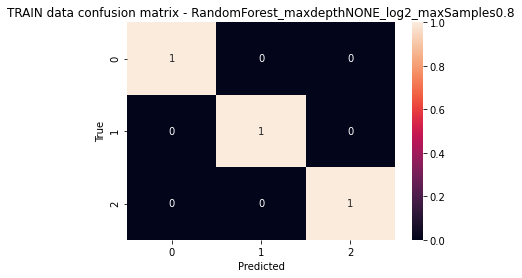

RandomForest_maxdepthNONE_log2_maxSamples0.8
for TESTING DATA
Accuracy Score: 0.8104575163398694


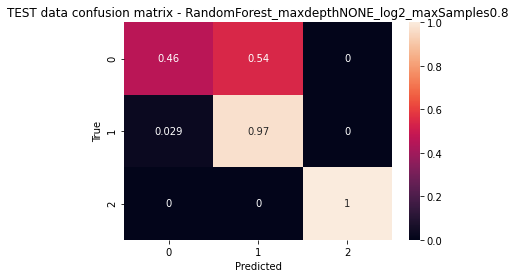

mean_power58.0HzCh1        0.005232
mean_amplitude44.0HzCh1    0.004833
mean_power10.0HzCh3        0.004807
mean_power76.0HzCh1        0.004802
mean_power78.0HzCh1        0.004670
                             ...   
mean_HeadBandOn            0.000000
var_HSI_AF8                0.000000
mean_HSI_AF7               0.000000
mean_HSI_AF8               0.000000
var_HSI_AF7                0.000000
Length: 1482, dtype: float64
mean_power58.0HzCh1        0.005232
mean_amplitude44.0HzCh1    0.004833
mean_power10.0HzCh3        0.004807
mean_power76.0HzCh1        0.004802
mean_power78.0HzCh1        0.004670
mean_amplitude38.0HzCh1    0.004621
var_amplitude44.0HzCh1     0.004509
var_power70.0HzCh1         0.004471
mean_amplitude60.0HzCh3    0.004464
mean_amplitude62.0HzCh1    0.004456
mean_power42.0HzCh1        0.004395
mean_power34.0HzCh1        0.004380
mean_power60.0HzCh3        0.004280
mean_amplitude22.0HzCh1    0.004226
var_phase60.0HzCh3         0.004190
mean_power44.0HzCh1        0.004188

pipeline_name  \
0                        RandomForest_maxdepth3   
1                   RandomForest_maxdepth3_log2   
2                     RandomForest_maxdepthNONE   
3                RandomForest_maxdepthNONE_log2   
4          RandomForest_maxdepth3_maxSamples0.8   
5     RandomForest_maxdepth3_log2_maxSamples0.8   
6       RandomForest_maxdepthNONE_maxSamples0.8   
7  RandomForest_maxdepthNONE_log2_maxSamples0.8   

                                         named_steps  train_acc_score  \
0  {'scaler': StandardScaler(), 'est': RandomFore...         0.934156   
1  {'scaler': StandardScaler(), 'est': RandomFore...         0.925926   
2  {'scaler': StandardScaler(), 'est': RandomFore...         1.000000   
3  {'scaler': StandardScaler(), 'est': RandomFore...         1.000000   
4  {'scaler': StandardScaler(), 'est': RandomFore...         0.935802   
5  {'scaler': StandardScaler(), 'est': RandomFore...         0.921811   
6  {'scaler': StandardScaler(), 'est': RandomFore...         1.000000   
7  {'scaler': StandardScaler(), 'est': RandomFore...         1.000000   

                              train_confusion_matrix  test_acc_score  \
0  [[0.9037037037037037, 0.0962962962962963, 0.0]...        0.767974   
1  [[0.9160493827160494, 0.08395061728395062, 0.0...        0.797386   
2  [[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, ...        0.787582   
3  [[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, ...        0.797386   
4  [[0.9135802469135802, 0.08641975308641975, 0.0...        0.794118   
5  [[0.9111111111111111, 0.08888888888888889, 0.0...        0.810458   
6  [[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, ...        0.790850   
7  [[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, ...        0.810458   

                               test_confusion_matrix  
0  [[0.4117647058823529, 0.5882352941176471, 0.0]...  
1  [[0.4117647058823529, 0.5882352941176471, 0.0]...  
2  [[0.4019607843137255, 0.5980392156862745, 0.0]...  
3  [[0.43137254901960786, 0.5686274509803921, 0.0...  
4  [[0.49019607843137253, 0.5098039215686274, 0.0...  
5  [[0.46078431372549017, 0.5392156862745098, 0.0...  
6  [[0.4019607843137255, 0.5980392156862745, 0.0]...  
7  [[0.46078431372549017, 0.5392156862745098, 0.0...

In [94]:
model_metrics = []

print("unique target values:",np.unique(y_train))

pipe_RF_steps_a = [
    ('scaler', StandardScaler()),
    ('est', RandomForestClassifier(n_estimators=2000, max_depth=3, max_features='sqrt'))
]

pipe_RF_steps_b = [
    ('scaler', StandardScaler()),
    ('est', RandomForestClassifier(n_estimators=2000, max_depth=3, max_features='log2'))
]

pipe_RF_steps_c = [
    ('scaler', StandardScaler()),
    ('est', RandomForestClassifier(n_estimators=2000, max_depth=None, max_features='sqrt'))
]

pipe_RF_steps_d = [
    ('scaler', StandardScaler()),
    ('est', RandomForestClassifier(n_estimators=2000, max_depth=None, max_features='log2'))
]

pipe_RF_steps_e = [
    ('scaler', StandardScaler()),
    ('est', RandomForestClassifier(n_estimators=2000, max_depth=3, max_features='sqrt', bootstrap=True, max_samples=0.8))
]

pipe_RF_steps_f = [
    ('scaler', StandardScaler()),
    ('est', RandomForestClassifier(n_estimators=2000, max_depth=3, max_features='log2', bootstrap=True, max_samples=0.8))
]

pipe_RF_steps_g = [
    ('scaler', StandardScaler()),
    ('est', RandomForestClassifier(n_estimators=2000, max_depth=None, max_features='sqrt', bootstrap=True, max_samples=0.8))
]

pipe_RF_steps_h = [
    ('scaler', StandardScaler()),
    ('est', RandomForestClassifier(n_estimators=2000, max_depth=None, max_features='log2', bootstrap=True, max_samples=0.8))
]

for pipe_steps, name in zip([pipe_RF_steps_a, pipe_RF_steps_b, pipe_RF_steps_c, pipe_RF_steps_d, 
                         pipe_RF_steps_e, pipe_RF_steps_f, pipe_RF_steps_g, pipe_RF_steps_h],
                         [
                          "RandomForest_maxdepth3","RandomForest_maxdepth3_log2",
                           "RandomForest_maxdepthNONE","RandomForest_maxdepthNONE_log2",
                           "RandomForest_maxdepth3_maxSamples0.8","RandomForest_maxdepth3_log2_maxSamples0.8",
                           "RandomForest_maxdepthNONE_maxSamples0.8","RandomForest_maxdepthNONE_log2_maxSamples0.8",
                         ]):
  
  pipe = Pipeline(pipe_steps)
  pipe.fit(X_train, y_train)
  train_predictions = pipe.predict(X_train)
  test_preds = pipe.predict(X_test)

  model_metrics_dict = {'pipeline_name': name, 'named_steps': str(pipe.named_steps)}

  print(name)
  print("for TRAINING DATA")

  model_metrics_dict['train_acc_score'] = balanced_accuracy_score(y_train, train_predictions)
  model_metrics_dict['train_confusion_matrix'] = confusion_matrix(y_train, train_predictions, normalize='true')

  print("Accuracy Score:", model_metrics_dict['train_acc_score'])
  sns.heatmap(model_metrics_dict['train_confusion_matrix'], annot=True)
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.title('TRAIN data confusion matrix - '+name)
  plt.show()

  print(name)
  print("for TESTING DATA")

  model_metrics_dict['test_acc_score'] = balanced_accuracy_score(y_test, test_preds)
  model_metrics_dict['test_confusion_matrix'] = confusion_matrix(y_test, test_preds, normalize='true')
  
  print("Accuracy Score:", model_metrics_dict['test_acc_score'])
  sns.heatmap(model_metrics_dict['test_confusion_matrix'], annot=True)
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.title('TEST data confusion matrix - '+name)
  plt.show()

  feat_import = pd.Series(pipe.named_steps.est.feature_importances_, index= dataset.drop(['TARGET','ORIGINAL_ROW_NUM','ORIGINAL_FILE_NUM'], axis=1).columns)
  print(feat_import.sort_values(ascending=False))
  print(feat_import.sort_values(ascending=False).iloc[:30])

  model_metrics.append(model_metrics_dict)


model_metrics_df = pd.DataFrame( {'pipeline_name': [metrics['pipeline_name'] for metrics in model_metrics],
                                  'named_steps': [metrics['named_steps'] for metrics in model_metrics],
                                  'train_acc_score': [metrics['train_acc_score'] for metrics in model_metrics],
                                  'train_confusion_matrix': [metrics['train_confusion_matrix'] for metrics in model_metrics],
                                  'test_acc_score': [metrics['test_acc_score'] for metrics in model_metrics],
                                  'test_confusion_matrix': [metrics['test_confusion_matrix'] for metrics in model_metrics]} )

display(model_metrics_df)

model_metrics_df.to_csv('model_metrics\\M1_M4_M5_experiment_agg_RF_optimized_169samplesPerSession.csv')

unique target values: [1 4 5]
GB_maxdepth3_sqrt
for TRAINING DATA
Accuracy Score: 1.0


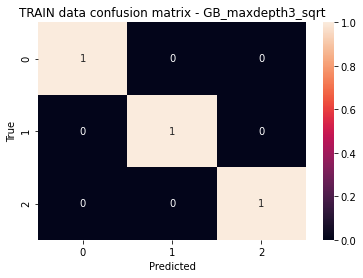

GB_maxdepth3_sqrt
for TESTING DATA
Accuracy Score: 0.7875816993464052


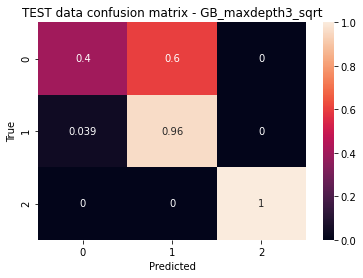

mean_power44.0HzCh1    0.083703
mean_power70.0HzCh1    0.079606
mean_power74.0HzCh1    0.045068
var_power76.0HzCh1     0.042249
var_power70.0HzCh1     0.032844
                         ...   
mean_phase28.0HzCh3    0.000000
mean_phase34.0HzCh3    0.000000
mean_phase36.0HzCh3    0.000000
mean_phase42.0HzCh3    0.000000
mean_phase76.0HzCh2    0.000000
Length: 1482, dtype: float64
mean_power44.0HzCh1                                   0.083703
mean_power70.0HzCh1                                   0.079606
mean_power74.0HzCh1                                   0.045068
var_power76.0HzCh1                                    0.042249
var_power70.0HzCh1                                    0.032844
mean_power76.0HzCh1                                   0.030179
var_amplitude76.0HzCh1                                0.024189
var_amplitude58.0HzCh3                                0.023169
mean_amplitude60.0HzCh3                               0.017117
mean_power60.0HzCh3                                 

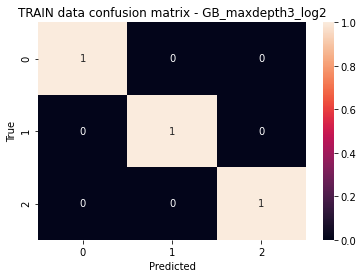

GB_maxdepth3_log2
for TESTING DATA
Accuracy Score: 0.7810457516339868


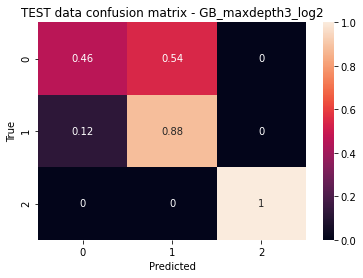

var_amplitude56.0HzCh1                                0.076757
var_amplitude62.0HzCh1                                0.043239
mean_amplitude70.0HzCh1                               0.038816
var_phaseDifference_phase80.0HzCh1_phase80.0HzCh2     0.028717
var_phase72.0HzCh1                                    0.028036
                                                        ...   
mean_phase56.0HzCh0                                   0.000000
mean_phase50.0HzCh0                                   0.000000
mean_phase48.0HzCh0                                   0.000000
var_HeadBandOn                                        0.000000
mean_phaseDifference_phase78.0HzCh0_phase78.0HzCh1    0.000000
Length: 1482, dtype: float64
var_amplitude56.0HzCh1                               0.076757
var_amplitude62.0HzCh1                               0.043239
mean_amplitude70.0HzCh1                              0.038816
var_phaseDifference_phase80.0HzCh1_phase80.0HzCh2    0.028717
var_phase72.0HzCh1            

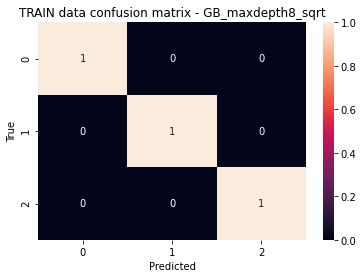

GB_maxdepth8_sqrt
for TESTING DATA
Accuracy Score: 0.8137254901960785


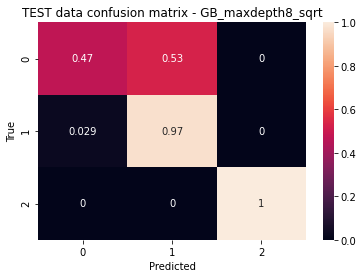

var_phaseDifference_phase66.0HzCh1_phase66.0HzCh3    0.055804
var_power44.0HzCh1                                   0.052487
var_power80.0HzCh1                                   0.043291
mean_power24.0HzCh1                                  0.034848
mean_Gamma_AF7                                       0.022997
                                                       ...   
mean_HSI_AF8                                         0.000000
var_Battery                                          0.000000
var_HSI_AF8                                          0.000000
mean_HeadBandOn                                      0.000000
mean_Battery                                         0.000000
Length: 1482, dtype: float64
var_phaseDifference_phase66.0HzCh1_phase66.0HzCh3    0.055804
var_power44.0HzCh1                                   0.052487
var_power80.0HzCh1                                   0.043291
mean_power24.0HzCh1                                  0.034848
mean_Gamma_AF7                           

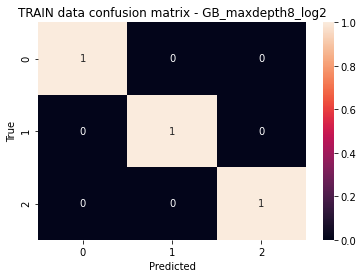

GB_maxdepth8_log2
for TESTING DATA
Accuracy Score: 0.8104575163398694


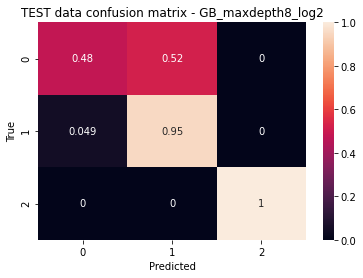

var_phaseDifference_phase46.0HzCh1_phase46.0HzCh3    0.056940
var_power50.0HzCh1                                   0.044142
mean_amplitude54.0HzCh1                              0.037415
var_amplitude38.0HzCh1                               0.030834
var_power42.0HzCh1                                   0.024594
                                                       ...   
var_Battery                                          0.000000
mean_Battery                                         0.000000
var_HSI_AF8                                          0.000000
mean_HSI_AF8                                         0.000000
mean_HeadBandOn                                      0.000000
Length: 1482, dtype: float64
var_phaseDifference_phase46.0HzCh1_phase46.0HzCh3    0.056940
var_power50.0HzCh1                                   0.044142
mean_amplitude54.0HzCh1                              0.037415
var_amplitude38.0HzCh1                               0.030834
var_power42.0HzCh1                       

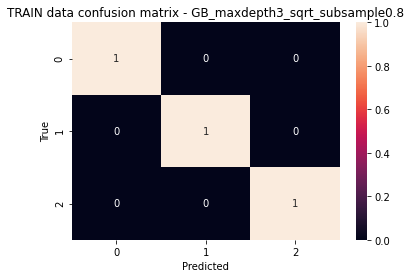

GB_maxdepth3_sqrt_subsample0.8
for TESTING DATA
Accuracy Score: 0.7843137254901961


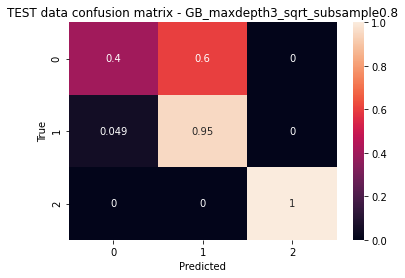

mean_power70.0HzCh1                                  0.077551
mean_power72.0HzCh1                                  0.050341
mean_power62.0HzCh1                                  0.050213
mean_power34.0HzCh1                                  0.031832
mean_power60.0HzCh3                                  0.030406
                                                       ...   
var_phaseDifference_phase30.0HzCh2_phase30.0HzCh3    0.000000
var_amplitude36.0HzCh1                               0.000000
mean_phaseDifference_phase4.0HzCh0_phase4.0HzCh3     0.000000
mean_phaseDifference_phase6.0HzCh0_phase6.0HzCh1     0.000000
mean_phase34.0HzCh3                                  0.000000
Length: 1482, dtype: float64
mean_power70.0HzCh1                                  0.077551
mean_power72.0HzCh1                                  0.050341
mean_power62.0HzCh1                                  0.050213
mean_power34.0HzCh1                                  0.031832
mean_power60.0HzCh3                      

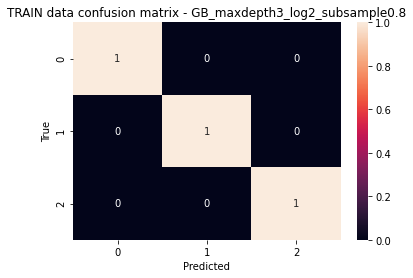

GB_maxdepth3_log2_subsample0.8
for TESTING DATA
Accuracy Score: 0.7843137254901961


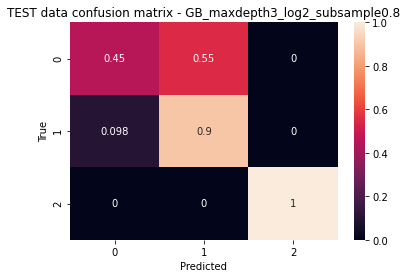

mean_amplitude74.0HzCh1                               0.053618
var_amplitude44.0HzCh1                                0.041572
mean_amplitude46.0HzCh1                               0.036178
var_power54.0HzCh1                                    0.025799
var_power76.0HzCh1                                    0.023506
                                                        ...   
mean_phaseDifference_phase52.0HzCh2_phase52.0HzCh3    0.000000
mean_phaseDifference_phase54.0HzCh0_phase54.0HzCh1    0.000000
mean_phase4.0HzCh3                                    0.000000
mean_phaseDifference_phase18.0HzCh1_phase18.0HzCh3    0.000000
var_phase64.0HzCh0                                    0.000000
Length: 1482, dtype: float64
mean_amplitude74.0HzCh1                               0.053618
var_amplitude44.0HzCh1                                0.041572
mean_amplitude46.0HzCh1                               0.036178
var_power54.0HzCh1                                    0.025799
var_power76.0HzCh1        

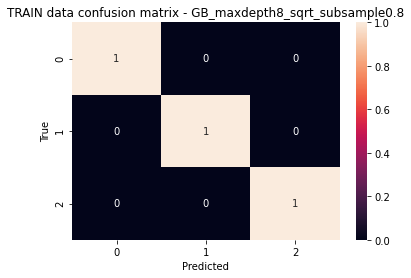

GB_maxdepth8_sqrt_subsample0.8
for TESTING DATA
Accuracy Score: 0.8137254901960785


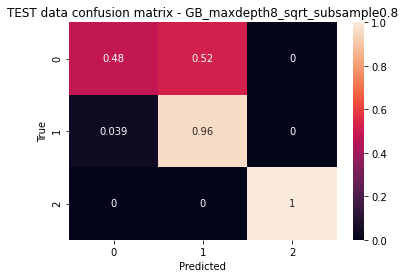

var_power44.0HzCh1         0.058717
mean_amplitude36.0HzCh1    0.049588
mean_power10.0HzCh3        0.039063
mean_power72.0HzCh1        0.031545
var_phase72.0HzCh1         0.022779
                             ...   
mean_HeadBandOn            0.000000
mean_Battery               0.000000
var_Battery                0.000000
var_HSI_AF8                0.000000
var_HeadBandOn             0.000000
Length: 1482, dtype: float64
var_power44.0HzCh1                                    0.058717
mean_amplitude36.0HzCh1                               0.049588
mean_power10.0HzCh3                                   0.039063
mean_power72.0HzCh1                                   0.031545
var_phase72.0HzCh1                                    0.022779
var_amplitude76.0HzCh1                                0.020301
var_phaseDifference_phase60.0HzCh1_phase60.0HzCh3     0.016660
var_amplitude56.0HzCh1                                0.016423
mean_power52.0HzCh1                                   0.014544
mean_Acc

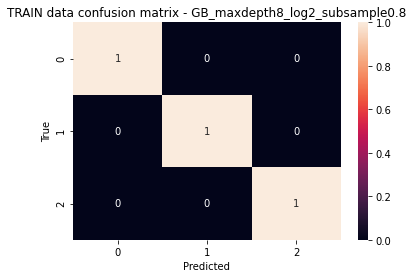

GB_maxdepth8_log2_subsample0.8
for TESTING DATA
Accuracy Score: 0.8169934640522877


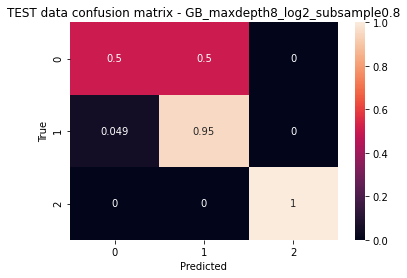

var_amplitude60.0HzCh1                               0.042951
var_amplitude36.0HzCh1                               0.027385
var_power68.0HzCh2                                   0.023625
var_phaseDifference_phase70.0HzCh1_phase70.0HzCh3    0.020817
var_phaseDifference_phase74.0HzCh0_phase74.0HzCh1    0.019792
                                                       ...   
var_HeadBandOn                                       0.000000
var_HSI_AF8                                          0.000000
mean_Battery                                         0.000000
mean_HSI_AF8                                         0.000000
var_Battery                                          0.000000
Length: 1482, dtype: float64
var_amplitude60.0HzCh1                               0.042951
var_amplitude36.0HzCh1                               0.027385
var_power68.0HzCh2                                   0.023625
var_phaseDifference_phase70.0HzCh1_phase70.0HzCh3    0.020817
var_phaseDifference_phase74.0HzCh0_phase7

pipeline_name  \
0               GB_maxdepth3_sqrt   
1               GB_maxdepth3_log2   
2               GB_maxdepth8_sqrt   
3               GB_maxdepth8_log2   
4  GB_maxdepth3_sqrt_subsample0.8   
5  GB_maxdepth3_log2_subsample0.8   
6  GB_maxdepth8_sqrt_subsample0.8   
7  GB_maxdepth8_log2_subsample0.8   

                                         named_steps  train_acc_score  \
0  {'scaler': StandardScaler(), 'est': GradientBo...              1.0   
1  {'scaler': StandardScaler(), 'est': GradientBo...              1.0   
2  {'scaler': StandardScaler(), 'est': GradientBo...              1.0   
3  {'scaler': StandardScaler(), 'est': GradientBo...              1.0   
4  {'scaler': StandardScaler(), 'est': GradientBo...              1.0   
5  {'scaler': StandardScaler(), 'est': GradientBo...              1.0   
6  {'scaler': StandardScaler(), 'est': GradientBo...              1.0   
7  {'scaler': StandardScaler(), 'est': GradientBo...              1.0   

                              train_confusion_matrix  test_acc_score  \
0  [[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, ...        0.787582   
1  [[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, ...        0.781046   
2  [[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, ...        0.813725   
3  [[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, ...        0.810458   
4  [[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, ...        0.784314   
5  [[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, ...        0.784314   
6  [[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, ...        0.813725   
7  [[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, ...        0.816993   

                               test_confusion_matrix  
0  [[0.4019607843137255, 0.5980392156862745, 0.0]...  
1  [[0.46078431372549017, 0.5392156862745098, 0.0...  
2  [[0.47058823529411764, 0.5294117647058824, 0.0...  
3  [[0.4803921568627451, 0.5196078431372549, 0.0]...  
4  [[0.4019607843137255, 0.5980392156862745, 0.0]...  
5  [[0.45098039215686275, 0.5490196078431373, 0.0...  
6  [[0.4803921568627451, 0.5196078431372549, 0.0]...  
7  [[0.5, 0.5, 0.0], [0.049019607843137254, 0.950...

In [96]:
model_metrics = []

print("unique target values:",np.unique(y_train))

pipe_GB_steps_a = [
    ('scaler', StandardScaler()),
    ('est', GradientBoostingClassifier(n_estimators=300, max_features='sqrt'))
]

pipe_GB_steps_b = [
    ('scaler', StandardScaler()),
    ('est', GradientBoostingClassifier(n_estimators=300, max_features='log2'))
]

pipe_GB_steps_c = [
    ('scaler', StandardScaler()),
    ('est', GradientBoostingClassifier(n_estimators=300, max_depth=8, max_features='sqrt'))
]

pipe_GB_steps_d = [
    ('scaler', StandardScaler()),
    ('est', GradientBoostingClassifier(n_estimators=300, max_depth=8, max_features='log2'))
]

pipe_GB_steps_e = [
    ('scaler', StandardScaler()),
    ('est', GradientBoostingClassifier(n_estimators=300, max_features='sqrt', subsample=0.8))
]

pipe_GB_steps_f = [
    ('scaler', StandardScaler()),
    ('est', GradientBoostingClassifier(n_estimators=300, max_features='log2', subsample=0.8))
]

pipe_GB_steps_g = [
    ('scaler', StandardScaler()),
    ('est', GradientBoostingClassifier(n_estimators=300, max_depth=8, max_features='sqrt', subsample=0.8))
]

pipe_GB_steps_h = [
    ('scaler', StandardScaler()),
    ('est', GradientBoostingClassifier(n_estimators=300, max_depth=8, max_features='log2', subsample=0.8))
]

for pipe_steps, name in zip([pipe_GB_steps_a, pipe_GB_steps_b, pipe_GB_steps_c, pipe_GB_steps_d, 
                         pipe_GB_steps_e, pipe_GB_steps_f, pipe_GB_steps_g, pipe_GB_steps_h],
                         [
                          "GB_maxdepth3_sqrt","GB_maxdepth3_log2",
                           "GB_maxdepth8_sqrt","GB_maxdepth8_log2",
                           "GB_maxdepth3_sqrt_subsample0.8","GB_maxdepth3_log2_subsample0.8",
                           "GB_maxdepth8_sqrt_subsample0.8","GB_maxdepth8_log2_subsample0.8",
                         ]):
  
  pipe = Pipeline(pipe_steps)
  pipe.fit(X_train, y_train)
  train_predictions = pipe.predict(X_train)
  test_preds = pipe.predict(X_test)

  model_metrics_dict = {'pipeline_name': name, 'named_steps': str(pipe.named_steps)}

  print(name)
  print("for TRAINING DATA")

  model_metrics_dict['train_acc_score'] = balanced_accuracy_score(y_train, train_predictions)
  model_metrics_dict['train_confusion_matrix'] = confusion_matrix(y_train, train_predictions, normalize='true')

  print("Accuracy Score:", model_metrics_dict['train_acc_score'])
  sns.heatmap(model_metrics_dict['train_confusion_matrix'], annot=True)
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.title('TRAIN data confusion matrix - '+name)
  plt.show()

  print(name)
  print("for TESTING DATA")

  model_metrics_dict['test_acc_score'] = balanced_accuracy_score(y_test, test_preds)
  model_metrics_dict['test_confusion_matrix'] = confusion_matrix(y_test, test_preds, normalize='true')
  
  print("Accuracy Score:", model_metrics_dict['test_acc_score'])
  sns.heatmap(model_metrics_dict['test_confusion_matrix'], annot=True)
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.title('TEST data confusion matrix - '+name)
  plt.show()

  feat_import = pd.Series(pipe.named_steps.est.feature_importances_, index= dataset.drop(['TARGET','ORIGINAL_ROW_NUM','ORIGINAL_FILE_NUM'], axis=1).columns)
  print(feat_import.sort_values(ascending=False))
  print(feat_import.sort_values(ascending=False).iloc[:30])

  model_metrics.append(model_metrics_dict)


model_metrics_df = pd.DataFrame( {'pipeline_name': [metrics['pipeline_name'] for metrics in model_metrics],
                                  'named_steps': [metrics['named_steps'] for metrics in model_metrics],
                                  'train_acc_score': [metrics['train_acc_score'] for metrics in model_metrics],
                                  'train_confusion_matrix': [metrics['train_confusion_matrix'] for metrics in model_metrics],
                                  'test_acc_score': [metrics['test_acc_score'] for metrics in model_metrics],
                                  'test_confusion_matrix': [metrics['test_confusion_matrix'] for metrics in model_metrics]} )

display(model_metrics_df)

model_metrics_df.to_csv('model_metrics\\M1_M4_M5_experiment_agg_GB_optimized_169samplesPerSession.csv')

In [97]:
outer1, outer2, outer3, outer4 = [],[],[],[]

for dataset in [M1_session0.iloc[:100], M1_session1.iloc[:100], M1_session2.iloc[:100], 
                M4_session0.iloc[:100], M4_session1.iloc[:100], M4_session2.iloc[:100], 
                M5_session0.iloc[:100], M5_session1.iloc[:100], M5_session2.iloc[:100]]:
  y = np.array(dataset['TARGET']).reshape(-1, 1)
  X = np.array(dataset.drop(['TARGET','ORIGINAL_ROW_NUM','ORIGINAL_FILE_NUM'], axis=1))

  print('y.shape',y.shape)

  X_train_subset, X_test_subset, y_train_subset, y_test_subset = train_test_split(X, y, test_size=0.2, shuffle=False)

  outer1.append(X_train_subset)
  outer2.append(X_test_subset)
  outer3.append(y_train_subset)
  outer4.append(y_test_subset)

X_train = np.vstack(outer1)
X_test = np.vstack(outer2)
y_train = np.vstack(outer3).ravel()
y_test = np.vstack(outer4).ravel()

print('X_train.shape', X_train.shape)
print('X_test.shape', X_test.shape)
print('y_train.shape',y_train.shape)
print('y_test.shape',y_test.shape)

y.shape (100, 1)
y.shape (100, 1)
y.shape (100, 1)
y.shape (100, 1)
y.shape (100, 1)
y.shape (100, 1)
y.shape (100, 1)
y.shape (100, 1)
y.shape (100, 1)
X_train.shape (720, 1482)
X_test.shape (180, 1482)
y_train.shape (720,)
y_test.shape (180,)


unique target values: [1 4 5]
RandomForest_maxdepth3
for TRAINING DATA
Accuracy Score: 0.9874999999999999


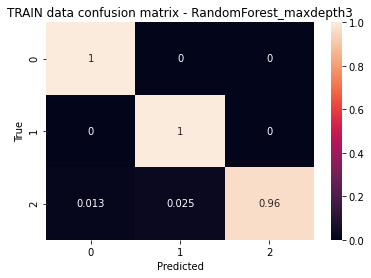

RandomForest_maxdepth3
for TESTING DATA
Accuracy Score: 0.8833333333333333


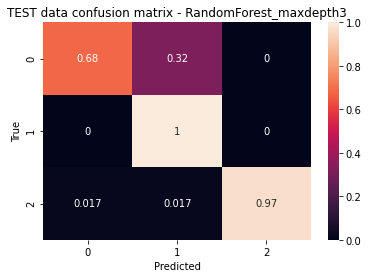

mean_power46.0HzCh1                                   0.017053
mean_amplitude10.0HzCh3                               0.016313
mean_amplitude42.0HzCh1                               0.016295
mean_power70.0HzCh1                                   0.016242
mean_power62.0HzCh1                                   0.015457
                                                        ...   
var_phase30.0HzCh2                                    0.000000
mean_phaseDifference_phase48.0HzCh2_phase48.0HzCh3    0.000000
mean_phaseDifference_phase50.0HzCh0_phase50.0HzCh2    0.000000
mean_phaseDifference_phase50.0HzCh2_phase50.0HzCh3    0.000000
mean_phaseDifference_phase74.0HzCh1_phase74.0HzCh3    0.000000
Length: 1482, dtype: float64
mean_power46.0HzCh1                                   0.017053
mean_amplitude10.0HzCh3                               0.016313
mean_amplitude42.0HzCh1                               0.016295
mean_power70.0HzCh1                                   0.016242
mean_power62.0HzCh1       

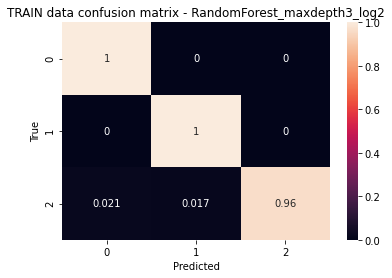

RandomForest_maxdepth3_log2
for TESTING DATA
Accuracy Score: 0.9166666666666666


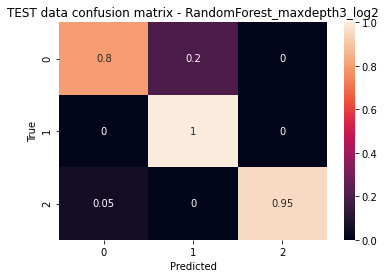

var_amplitude44.0HzCh1                                0.008340
mean_power72.0HzCh1                                   0.008019
mean_power70.0HzCh1                                   0.008005
mean_power58.0HzCh1                                   0.007944
mean_amplitude42.0HzCh1                               0.007534
                                                        ...   
var_power38.0HzCh3                                    0.000000
mean_phaseDifference_phase30.0HzCh0_phase30.0HzCh2    0.000000
mean_phaseDifference_phase28.0HzCh0_phase28.0HzCh3    0.000000
mean_phaseDifference_phase26.0HzCh0_phase26.0HzCh3    0.000000
mean_phaseDifference_phase6.0HzCh2_phase6.0HzCh3      0.000000
Length: 1482, dtype: float64
var_amplitude44.0HzCh1     0.008340
mean_power72.0HzCh1        0.008019
mean_power70.0HzCh1        0.008005
mean_power58.0HzCh1        0.007944
mean_amplitude42.0HzCh1    0.007534
mean_amplitude62.0HzCh1    0.007413
var_phase46.0HzCh1         0.007116
mean_power46.0HzCh1       

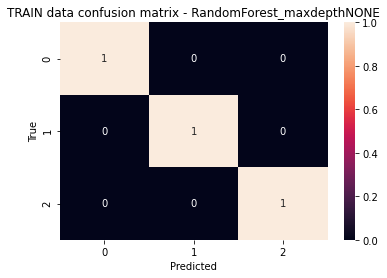

RandomForest_maxdepthNONE
for TESTING DATA
Accuracy Score: 0.9166666666666666


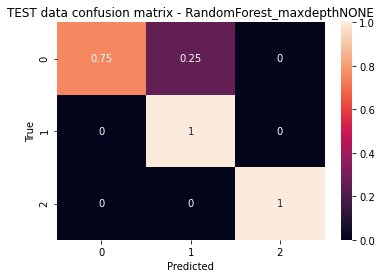

mean_power70.0HzCh1        0.013973
mean_amplitude46.0HzCh1    0.011432
mean_amplitude10.0HzCh3    0.011283
mean_amplitude44.0HzCh1    0.011005
mean_Accelerometer_X       0.010440
                             ...   
mean_HeadBandOn            0.000000
var_HSI_AF8                0.000000
var_HeadBandOn             0.000000
var_HSI_AF7                0.000000
var_Battery                0.000000
Length: 1482, dtype: float64
mean_power70.0HzCh1                                   0.013973
mean_amplitude46.0HzCh1                               0.011432
mean_amplitude10.0HzCh3                               0.011283
mean_amplitude44.0HzCh1                               0.011005
mean_Accelerometer_X                                  0.010440
mean_power58.0HzCh1                                   0.010194
mean_power60.0HzCh3                                   0.010097
mean_power44.0HzCh1                                   0.010064
mean_phaseDifference_phase58.0HzCh0_phase58.0HzCh3    0.009788
mean_pow

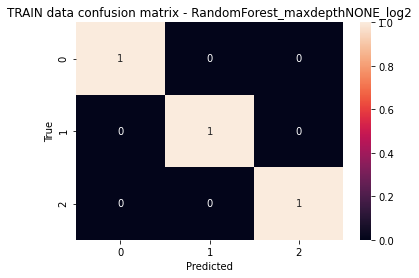

RandomForest_maxdepthNONE_log2
for TESTING DATA
Accuracy Score: 0.9222222222222222


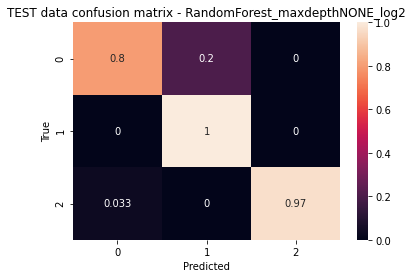

mean_amplitude42.0HzCh1    0.005956
mean_amplitude58.0HzCh1    0.005078
mean_power58.0HzCh1        0.005025
var_power60.0HzCh3         0.005013
mean_amplitude60.0HzCh3    0.005004
                             ...   
mean_Battery               0.000000
mean_HeadBandOn            0.000000
var_HSI_AF7                0.000000
var_Battery                0.000000
var_HeadBandOn             0.000000
Length: 1482, dtype: float64
mean_amplitude42.0HzCh1                              0.005956
mean_amplitude58.0HzCh1                              0.005078
mean_power58.0HzCh1                                  0.005025
var_power60.0HzCh3                                   0.005013
mean_amplitude60.0HzCh3                              0.005004
mean_amplitude10.0HzCh3                              0.004773
mean_power60.0HzCh3                                  0.004737
var_phase60.0HzCh3                                   0.004689
mean_power58.0HzCh0                                  0.004578
mean_power46.0HzC

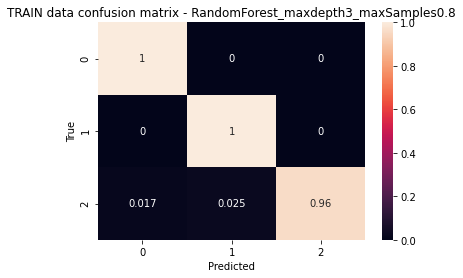

RandomForest_maxdepth3_maxSamples0.8
for TESTING DATA
Accuracy Score: 0.8888888888888888


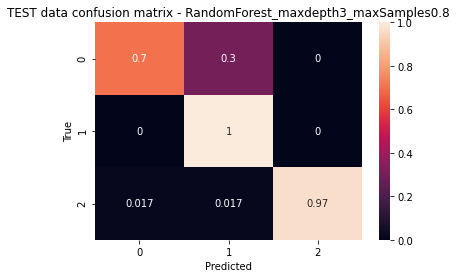

mean_power70.0HzCh1        0.017151
mean_amplitude46.0HzCh1    0.016756
mean_power58.0HzCh1        0.015797
mean_amplitude44.0HzCh1    0.014744
var_power44.0HzCh1         0.014662
                             ...   
mean_amplitude28.0HzCh0    0.000000
mean_phase6.0HzCh2         0.000000
mean_phase78.0HzCh1        0.000000
var_power4.0HzCh2          0.000000
var_power46.0HzCh0         0.000000
Length: 1482, dtype: float64
mean_power70.0HzCh1                                   0.017151
mean_amplitude46.0HzCh1                               0.016756
mean_power58.0HzCh1                                   0.015797
mean_amplitude44.0HzCh1                               0.014744
var_power44.0HzCh1                                    0.014662
mean_amplitude58.0HzCh1                               0.014519
mean_amplitude42.0HzCh1                               0.013784
mean_power76.0HzCh1                                   0.013464
mean_amplitude10.0HzCh3                               0.013248
mean_pow

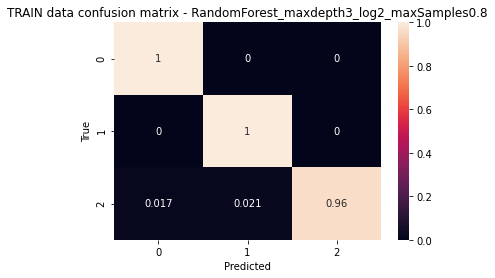

RandomForest_maxdepth3_log2_maxSamples0.8
for TESTING DATA
Accuracy Score: 0.8833333333333333


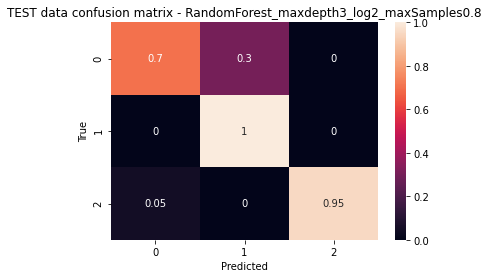

mean_power10.0HzCh3                                  0.008471
mean_power70.0HzCh1                                  0.008289
mean_power44.0HzCh1                                  0.008230
mean_amplitude44.0HzCh1                              0.008027
mean_power62.0HzCh1                                  0.007789
                                                       ...   
var_phaseDifference_phase48.0HzCh0_phase48.0HzCh3    0.000000
mean_phase80.0HzCh3                                  0.000000
mean_phaseDifference_phase4.0HzCh0_phase4.0HzCh1     0.000000
mean_phaseDifference_phase4.0HzCh2_phase4.0HzCh3     0.000000
var_Delta_TP9                                        0.000000
Length: 1482, dtype: float64
mean_power10.0HzCh3                                  0.008471
mean_power70.0HzCh1                                  0.008289
mean_power44.0HzCh1                                  0.008230
mean_amplitude44.0HzCh1                              0.008027
mean_power62.0HzCh1                      

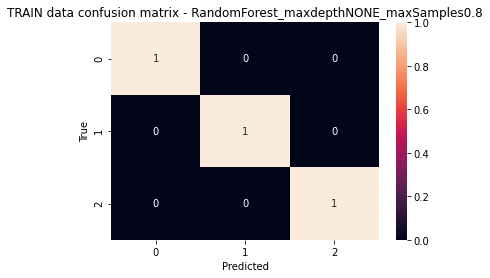

RandomForest_maxdepthNONE_maxSamples0.8
for TESTING DATA
Accuracy Score: 0.9222222222222222


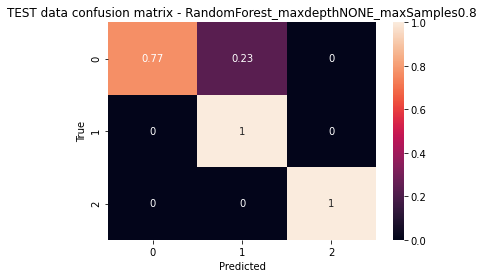

mean_power70.0HzCh1        0.014123
mean_power46.0HzCh1        0.011997
mean_amplitude44.0HzCh1    0.011769
mean_power58.0HzCh1        0.011349
mean_amplitude58.0HzCh1    0.010855
                             ...   
mean_HSI_AF7               0.000000
mean_HeadBandOn            0.000000
var_HeadBandOn             0.000000
var_Battery                0.000000
var_HSI_AF7                0.000000
Length: 1482, dtype: float64
mean_power70.0HzCh1                                   0.014123
mean_power46.0HzCh1                                   0.011997
mean_amplitude44.0HzCh1                               0.011769
mean_power58.0HzCh1                                   0.011349
mean_amplitude58.0HzCh1                               0.010855
mean_Accelerometer_Z                                  0.010097
mean_Accelerometer_X                                  0.010078
mean_amplitude46.0HzCh1                               0.009891
mean_power76.0HzCh1                                   0.009821
mean_pow

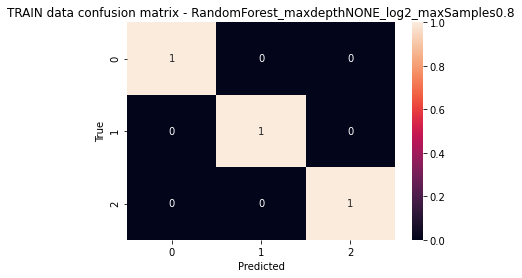

RandomForest_maxdepthNONE_log2_maxSamples0.8
for TESTING DATA
Accuracy Score: 0.9277777777777777


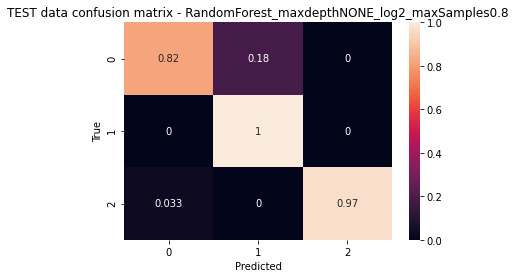

mean_amplitude44.0HzCh1    0.005346
mean_power70.0HzCh1        0.005292
mean_power60.0HzCh3        0.005239
var_power60.0HzCh3         0.005211
mean_amplitude60.0HzCh3    0.005178
                             ...   
mean_HSI_AF8               0.000000
mean_HSI_AF7               0.000000
mean_HeadBandOn            0.000000
var_Battery                0.000000
var_HSI_AF8                0.000000
Length: 1482, dtype: float64
mean_amplitude44.0HzCh1                               0.005346
mean_power70.0HzCh1                                   0.005292
mean_power60.0HzCh3                                   0.005239
var_power60.0HzCh3                                    0.005211
mean_amplitude60.0HzCh3                               0.005178
var_phase58.0HzCh0                                    0.005043
mean_Accelerometer_X                                  0.004993
mean_amplitude10.0HzCh3                               0.004886
var_amplitude44.0HzCh1                                0.004867
mean_amp

pipeline_name  \
0                        RandomForest_maxdepth3   
1                   RandomForest_maxdepth3_log2   
2                     RandomForest_maxdepthNONE   
3                RandomForest_maxdepthNONE_log2   
4          RandomForest_maxdepth3_maxSamples0.8   
5     RandomForest_maxdepth3_log2_maxSamples0.8   
6       RandomForest_maxdepthNONE_maxSamples0.8   
7  RandomForest_maxdepthNONE_log2_maxSamples0.8   

                                         named_steps  train_acc_score  \
0  {'scaler': StandardScaler(), 'est': RandomFore...         0.987500   
1  {'scaler': StandardScaler(), 'est': RandomFore...         0.987500   
2  {'scaler': StandardScaler(), 'est': RandomFore...         1.000000   
3  {'scaler': StandardScaler(), 'est': RandomFore...         1.000000   
4  {'scaler': StandardScaler(), 'est': RandomFore...         0.986111   
5  {'scaler': StandardScaler(), 'est': RandomFore...         0.987500   
6  {'scaler': StandardScaler(), 'est': RandomFore...         1.000000   
7  {'scaler': StandardScaler(), 'est': RandomFore...         1.000000   

                              train_confusion_matrix  test_acc_score  \
0  [[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0125, 0....        0.883333   
1  [[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.02083333...        0.916667   
2  [[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, ...        0.916667   
3  [[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, ...        0.922222   
4  [[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.01666666...        0.888889   
5  [[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.01666666...        0.883333   
6  [[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, ...        0.922222   
7  [[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, ...        0.927778   

                               test_confusion_matrix  
0  [[0.6833333333333333, 0.31666666666666665, 0.0...  
1  [[0.8, 0.2, 0.0], [0.0, 1.0, 0.0], [0.05, 0.0,...  
2  [[0.75, 0.25, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0...  
3  [[0.8, 0.2, 0.0], [0.0, 1.0, 0.0], [0.03333333...  
4  [[0.7, 0.3, 0.0], [0.0, 1.0, 0.0], [0.01666666...  
5  [[0.7, 0.3, 0.0], [0.0, 1.0, 0.0], [0.05, 0.0,...  
6  [[0.7666666666666667, 0.23333333333333334, 0.0...  
7  [[0.8166666666666667, 0.18333333333333332, 0.0...

In [98]:
model_metrics = []

print("unique target values:",np.unique(y_train))

pipe_RF_steps_a = [
    ('scaler', StandardScaler()),
    ('est', RandomForestClassifier(n_estimators=2000, max_depth=3, max_features='sqrt'))
]

pipe_RF_steps_b = [
    ('scaler', StandardScaler()),
    ('est', RandomForestClassifier(n_estimators=2000, max_depth=3, max_features='log2'))
]

pipe_RF_steps_c = [
    ('scaler', StandardScaler()),
    ('est', RandomForestClassifier(n_estimators=2000, max_depth=None, max_features='sqrt'))
]

pipe_RF_steps_d = [
    ('scaler', StandardScaler()),
    ('est', RandomForestClassifier(n_estimators=2000, max_depth=None, max_features='log2'))
]

pipe_RF_steps_e = [
    ('scaler', StandardScaler()),
    ('est', RandomForestClassifier(n_estimators=2000, max_depth=3, max_features='sqrt', bootstrap=True, max_samples=0.8))
]

pipe_RF_steps_f = [
    ('scaler', StandardScaler()),
    ('est', RandomForestClassifier(n_estimators=2000, max_depth=3, max_features='log2', bootstrap=True, max_samples=0.8))
]

pipe_RF_steps_g = [
    ('scaler', StandardScaler()),
    ('est', RandomForestClassifier(n_estimators=2000, max_depth=None, max_features='sqrt', bootstrap=True, max_samples=0.8))
]

pipe_RF_steps_h = [
    ('scaler', StandardScaler()),
    ('est', RandomForestClassifier(n_estimators=2000, max_depth=None, max_features='log2', bootstrap=True, max_samples=0.8))
]

for pipe_steps, name in zip([pipe_RF_steps_a, pipe_RF_steps_b, pipe_RF_steps_c, pipe_RF_steps_d, 
                         pipe_RF_steps_e, pipe_RF_steps_f, pipe_RF_steps_g, pipe_RF_steps_h],
                         [
                          "RandomForest_maxdepth3","RandomForest_maxdepth3_log2",
                           "RandomForest_maxdepthNONE","RandomForest_maxdepthNONE_log2",
                           "RandomForest_maxdepth3_maxSamples0.8","RandomForest_maxdepth3_log2_maxSamples0.8",
                           "RandomForest_maxdepthNONE_maxSamples0.8","RandomForest_maxdepthNONE_log2_maxSamples0.8",
                         ]):
  
  pipe = Pipeline(pipe_steps)
  pipe.fit(X_train, y_train)
  train_predictions = pipe.predict(X_train)
  test_preds = pipe.predict(X_test)

  model_metrics_dict = {'pipeline_name': name, 'named_steps': str(pipe.named_steps)}

  print(name)
  print("for TRAINING DATA")

  model_metrics_dict['train_acc_score'] = balanced_accuracy_score(y_train, train_predictions)
  model_metrics_dict['train_confusion_matrix'] = confusion_matrix(y_train, train_predictions, normalize='true')

  print("Accuracy Score:", model_metrics_dict['train_acc_score'])
  sns.heatmap(model_metrics_dict['train_confusion_matrix'], annot=True)
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.title('TRAIN data confusion matrix - '+name)
  plt.show()

  print(name)
  print("for TESTING DATA")

  model_metrics_dict['test_acc_score'] = balanced_accuracy_score(y_test, test_preds)
  model_metrics_dict['test_confusion_matrix'] = confusion_matrix(y_test, test_preds, normalize='true')
  
  print("Accuracy Score:", model_metrics_dict['test_acc_score'])
  sns.heatmap(model_metrics_dict['test_confusion_matrix'], annot=True)
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.title('TEST data confusion matrix - '+name)
  plt.show()

  feat_import = pd.Series(pipe.named_steps.est.feature_importances_, index= dataset.drop(['TARGET','ORIGINAL_ROW_NUM','ORIGINAL_FILE_NUM'], axis=1).columns)
  print(feat_import.sort_values(ascending=False))
  print(feat_import.sort_values(ascending=False).iloc[:30])

  model_metrics.append(model_metrics_dict)


model_metrics_df = pd.DataFrame( {'pipeline_name': [metrics['pipeline_name'] for metrics in model_metrics],
                                  'named_steps': [metrics['named_steps'] for metrics in model_metrics],
                                  'train_acc_score': [metrics['train_acc_score'] for metrics in model_metrics],
                                  'train_confusion_matrix': [metrics['train_confusion_matrix'] for metrics in model_metrics],
                                  'test_acc_score': [metrics['test_acc_score'] for metrics in model_metrics],
                                  'test_confusion_matrix': [metrics['test_confusion_matrix'] for metrics in model_metrics]} )

display(model_metrics_df)

model_metrics_df.to_csv('model_metrics\\M1_M4_M5_experiment_agg_RF_optimized_100samplesPerSession.csv')

unique target values: [1 4 5]
GB_maxdepth3_sqrt
for TRAINING DATA
Accuracy Score: 1.0


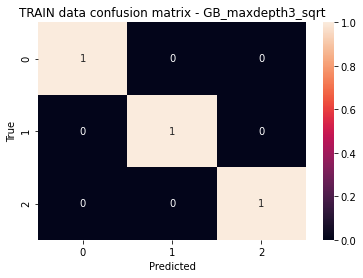

GB_maxdepth3_sqrt
for TESTING DATA
Accuracy Score: 0.9277777777777777


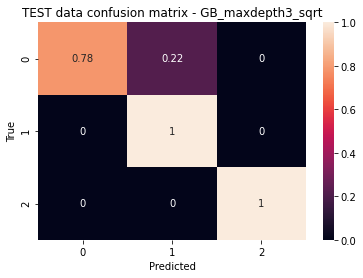

mean_power58.0HzCh1                                   0.064120
mean_power72.0HzCh1                                   0.049333
mean_power74.0HzCh1                                   0.039829
mean_amplitude54.0HzCh1                               0.036439
var_phaseDifference_phase62.0HzCh0_phase62.0HzCh3     0.026222
                                                        ...   
var_Theta_TP10                                        0.000000
var_Alpha_AF7                                         0.000000
var_Gamma_TP9                                         0.000000
mean_phaseDifference_phase24.0HzCh0_phase24.0HzCh1    0.000000
var_phaseDifference_phase18.0HzCh2_phase18.0HzCh3     0.000000
Length: 1482, dtype: float64
mean_power58.0HzCh1                                   0.064120
mean_power72.0HzCh1                                   0.049333
mean_power74.0HzCh1                                   0.039829
mean_amplitude54.0HzCh1                               0.036439
var_phaseDifference_phase6

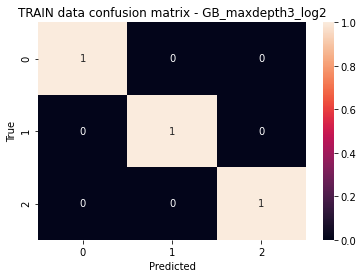

GB_maxdepth3_log2
for TESTING DATA
Accuracy Score: 0.9611111111111111


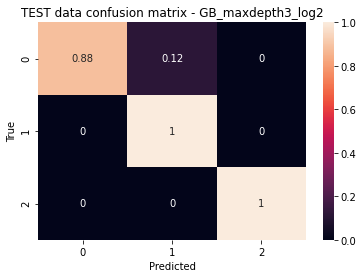

mean_amplitude46.0HzCh1                               0.066416
var_power36.0HzCh1                                    0.036009
var_power66.0HzCh1                                    0.030429
mean_power44.0HzCh2                                   0.024595
mean_power40.0HzCh1                                   0.024051
                                                        ...   
mean_phaseDifference_phase68.0HzCh2_phase68.0HzCh3    0.000000
mean_phase48.0HzCh2                                   0.000000
mean_phase44.0HzCh2                                   0.000000
mean_phaseDifference_phase70.0HzCh0_phase70.0HzCh2    0.000000
mean_phaseDifference_phase24.0HzCh0_phase24.0HzCh2    0.000000
Length: 1482, dtype: float64
mean_amplitude46.0HzCh1                               0.066416
var_power36.0HzCh1                                    0.036009
var_power66.0HzCh1                                    0.030429
mean_power44.0HzCh2                                   0.024595
mean_power40.0HzCh1       

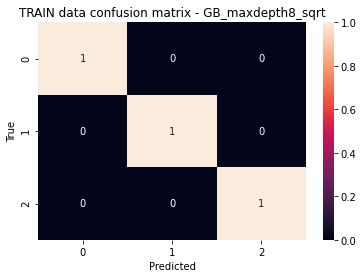

GB_maxdepth8_sqrt
for TESTING DATA
Accuracy Score: 0.9166666666666666


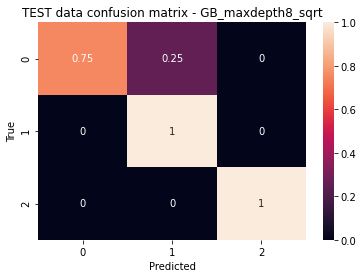

mean_power42.0HzCh1    0.060856
mean_power44.0HzCh1    0.052174
mean_power70.0HzCh1    0.051786
mean_power76.0HzCh1    0.030216
var_power58.0HzCh0     0.027644
                         ...   
var_Battery            0.000000
mean_Battery           0.000000
mean_HSI_AF8           0.000000
mean_HSI_AF7           0.000000
var_HSI_AF7            0.000000
Length: 1482, dtype: float64
mean_power42.0HzCh1                                   0.060856
mean_power44.0HzCh1                                   0.052174
mean_power70.0HzCh1                                   0.051786
mean_power76.0HzCh1                                   0.030216
var_power58.0HzCh0                                    0.027644
var_phase58.0HzCh1                                    0.022807
mean_amplitude58.0HzCh1                               0.020708
var_power60.0HzCh0                                    0.020144
mean_power46.0HzCh1                                   0.019397
mean_power60.0HzCh3                                 

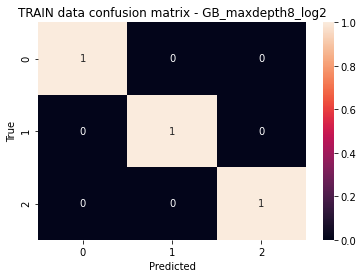

GB_maxdepth8_log2
for TESTING DATA
Accuracy Score: 0.9166666666666666


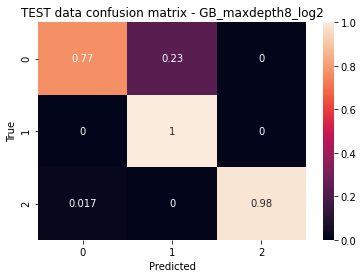

var_power70.0HzCh1         0.056463
mean_amplitude70.0HzCh1    0.028192
var_power72.0HzCh1         0.027806
mean_power42.0HzCh1        0.023937
var_power20.0HzCh2         0.022728
                             ...   
var_HSI_AF8                0.000000
var_HSI_AF7                0.000000
mean_HSI_AF7               0.000000
mean_HeadBandOn            0.000000
mean_HSI_AF8               0.000000
Length: 1482, dtype: float64
var_power70.0HzCh1                                    0.056463
mean_amplitude70.0HzCh1                               0.028192
var_power72.0HzCh1                                    0.027806
mean_power42.0HzCh1                                   0.023937
var_power20.0HzCh2                                    0.022728
mean_phaseDifference_phase62.0HzCh0_phase62.0HzCh3    0.020660
mean_power66.0HzCh1                                   0.020495
mean_power10.0HzCh3                                   0.020448
var_amplitude44.0HzCh1                                0.019134
mean_pow

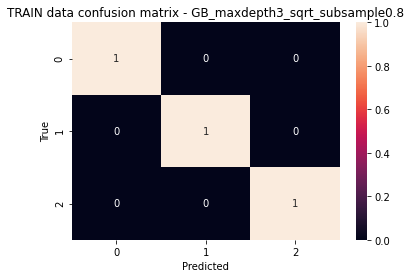

GB_maxdepth3_sqrt_subsample0.8
for TESTING DATA
Accuracy Score: 0.9166666666666666


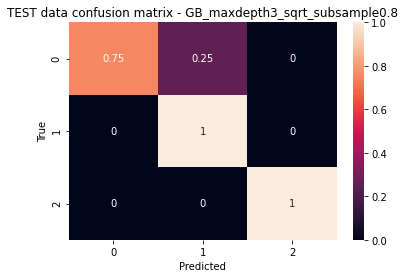

mean_power72.0HzCh1                                   0.061740
var_power46.0HzCh1                                    0.046195
mean_amplitude60.0HzCh3                               0.033715
var_phaseDifference_phase40.0HzCh0_phase40.0HzCh1     0.032513
var_amplitude38.0HzCh1                                0.030597
                                                        ...   
mean_phaseDifference_phase34.0HzCh2_phase34.0HzCh3    0.000000
mean_phaseDifference_phase34.0HzCh0_phase34.0HzCh3    0.000000
mean_phaseDifference_phase34.0HzCh0_phase34.0HzCh2    0.000000
var_phaseDifference_phase30.0HzCh0_phase30.0HzCh2     0.000000
var_Delta_TP9                                         0.000000
Length: 1482, dtype: float64
mean_power72.0HzCh1                                  0.061740
var_power46.0HzCh1                                   0.046195
mean_amplitude60.0HzCh3                              0.033715
var_phaseDifference_phase40.0HzCh0_phase40.0HzCh1    0.032513
var_amplitude38.0HzCh1        

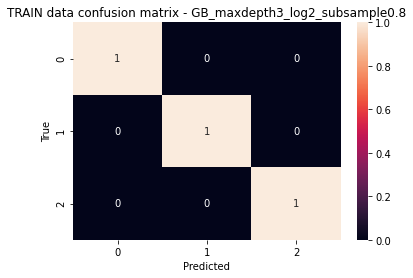

GB_maxdepth3_log2_subsample0.8
for TESTING DATA
Accuracy Score: 0.9333333333333332


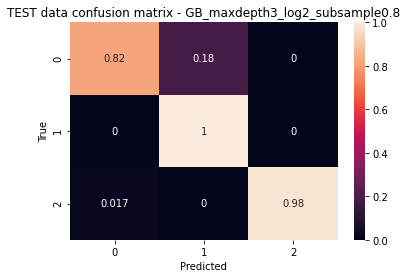

var_power54.0HzCh1                                    0.050180
var_phaseDifference_phase42.0HzCh1_phase42.0HzCh3     0.046163
var_power68.0HzCh1                                    0.037966
mean_amplitude58.0HzCh1                               0.034759
mean_amplitude36.0HzCh1                               0.023926
                                                        ...   
var_phaseDifference_phase48.0HzCh0_phase48.0HzCh2     0.000000
mean_amplitude8.0HzCh3                                0.000000
mean_phaseDifference_phase70.0HzCh0_phase70.0HzCh1    0.000000
mean_phaseDifference_phase40.0HzCh0_phase40.0HzCh3    0.000000
mean_phaseDifference_phase6.0HzCh0_phase6.0HzCh2      0.000000
Length: 1482, dtype: float64
var_power54.0HzCh1                                    0.050180
var_phaseDifference_phase42.0HzCh1_phase42.0HzCh3     0.046163
var_power68.0HzCh1                                    0.037966
mean_amplitude58.0HzCh1                               0.034759
mean_amplitude36.0HzCh1   

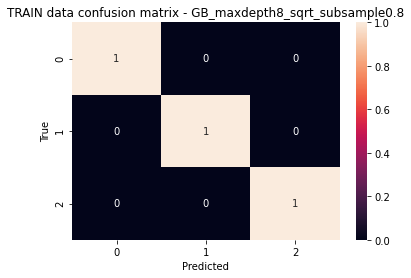

GB_maxdepth8_sqrt_subsample0.8
for TESTING DATA
Accuracy Score: 0.9277777777777777


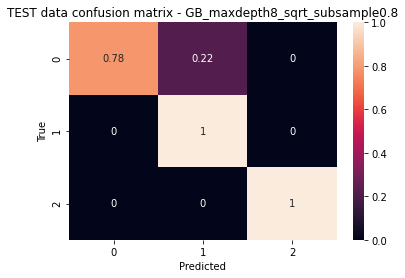

var_phase10.0HzCh3         0.062186
mean_power24.0HzCh1        0.049959
var_power58.0HzCh1         0.048943
mean_amplitude58.0HzCh1    0.027363
mean_power34.0HzCh1        0.021046
                             ...   
mean_HSI_AF7               0.000000
mean_HSI_AF8               0.000000
mean_Battery               0.000000
var_HeadBandOn             0.000000
var_HSI_AF8                0.000000
Length: 1482, dtype: float64
var_phase10.0HzCh3                                    0.062186
mean_power24.0HzCh1                                   0.049959
var_power58.0HzCh1                                    0.048943
mean_amplitude58.0HzCh1                               0.027363
mean_power34.0HzCh1                                   0.021046
mean_power76.0HzCh1                                   0.020131
mean_amplitude50.0HzCh1                               0.019871
mean_amplitude60.0HzCh3                               0.018870
mean_power44.0HzCh1                                   0.018029
mean_pow

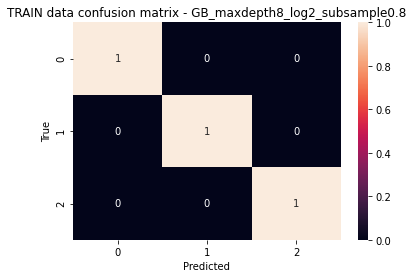

GB_maxdepth8_log2_subsample0.8
for TESTING DATA
Accuracy Score: 0.9444444444444445


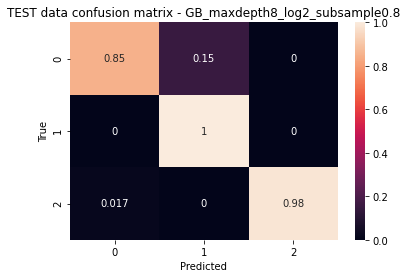

mean_power76.0HzCh1                                  0.056390
var_phaseDifference_phase68.0HzCh1_phase68.0HzCh3    0.030972
var_amplitude42.0HzCh1                               0.027879
var_phaseDifference_phase64.0HzCh0_phase64.0HzCh1    0.024915
mean_power42.0HzCh1                                  0.019358
                                                       ...   
var_HeadBandOn                                       0.000000
var_HSI_AF8                                          0.000000
mean_HeadBandOn                                      0.000000
var_HSI_AF7                                          0.000000
mean_HSI_AF7                                         0.000000
Length: 1482, dtype: float64
mean_power76.0HzCh1                                  0.056390
var_phaseDifference_phase68.0HzCh1_phase68.0HzCh3    0.030972
var_amplitude42.0HzCh1                               0.027879
var_phaseDifference_phase64.0HzCh0_phase64.0HzCh1    0.024915
mean_power42.0HzCh1                      

pipeline_name  \
0               GB_maxdepth3_sqrt   
1               GB_maxdepth3_log2   
2               GB_maxdepth8_sqrt   
3               GB_maxdepth8_log2   
4  GB_maxdepth3_sqrt_subsample0.8   
5  GB_maxdepth3_log2_subsample0.8   
6  GB_maxdepth8_sqrt_subsample0.8   
7  GB_maxdepth8_log2_subsample0.8   

                                         named_steps  train_acc_score  \
0  {'scaler': StandardScaler(), 'est': GradientBo...              1.0   
1  {'scaler': StandardScaler(), 'est': GradientBo...              1.0   
2  {'scaler': StandardScaler(), 'est': GradientBo...              1.0   
3  {'scaler': StandardScaler(), 'est': GradientBo...              1.0   
4  {'scaler': StandardScaler(), 'est': GradientBo...              1.0   
5  {'scaler': StandardScaler(), 'est': GradientBo...              1.0   
6  {'scaler': StandardScaler(), 'est': GradientBo...              1.0   
7  {'scaler': StandardScaler(), 'est': GradientBo...              1.0   

                              train_confusion_matrix  test_acc_score  \
0  [[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, ...        0.927778   
1  [[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, ...        0.961111   
2  [[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, ...        0.916667   
3  [[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, ...        0.916667   
4  [[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, ...        0.916667   
5  [[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, ...        0.933333   
6  [[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, ...        0.927778   
7  [[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, ...        0.944444   

                               test_confusion_matrix  
0  [[0.7833333333333333, 0.21666666666666667, 0.0...  
1  [[0.8833333333333333, 0.11666666666666667, 0.0...  
2  [[0.75, 0.25, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0...  
3  [[0.7666666666666667, 0.23333333333333334, 0.0...  
4  [[0.75, 0.25, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0...  
5  [[0.8166666666666667, 0.18333333333333332, 0.0...  
6  [[0.7833333333333333, 0.21666666666666667, 0.0...  
7  [[0.85, 0.15, 0.0], [0.0, 1.0, 0.0], [0.016666...

In [99]:
model_metrics = []

print("unique target values:",np.unique(y_train))

pipe_GB_steps_a = [
    ('scaler', StandardScaler()),
    ('est', GradientBoostingClassifier(n_estimators=300, max_features='sqrt'))
]

pipe_GB_steps_b = [
    ('scaler', StandardScaler()),
    ('est', GradientBoostingClassifier(n_estimators=300, max_features='log2'))
]

pipe_GB_steps_c = [
    ('scaler', StandardScaler()),
    ('est', GradientBoostingClassifier(n_estimators=300, max_depth=8, max_features='sqrt'))
]

pipe_GB_steps_d = [
    ('scaler', StandardScaler()),
    ('est', GradientBoostingClassifier(n_estimators=300, max_depth=8, max_features='log2'))
]

pipe_GB_steps_e = [
    ('scaler', StandardScaler()),
    ('est', GradientBoostingClassifier(n_estimators=300, max_features='sqrt', subsample=0.8))
]

pipe_GB_steps_f = [
    ('scaler', StandardScaler()),
    ('est', GradientBoostingClassifier(n_estimators=300, max_features='log2', subsample=0.8))
]

pipe_GB_steps_g = [
    ('scaler', StandardScaler()),
    ('est', GradientBoostingClassifier(n_estimators=300, max_depth=8, max_features='sqrt', subsample=0.8))
]

pipe_GB_steps_h = [
    ('scaler', StandardScaler()),
    ('est', GradientBoostingClassifier(n_estimators=300, max_depth=8, max_features='log2', subsample=0.8))
]

for pipe_steps, name in zip([pipe_GB_steps_a, pipe_GB_steps_b, pipe_GB_steps_c, pipe_GB_steps_d, 
                         pipe_GB_steps_e, pipe_GB_steps_f, pipe_GB_steps_g, pipe_GB_steps_h],
                         [
                          "GB_maxdepth3_sqrt","GB_maxdepth3_log2",
                           "GB_maxdepth8_sqrt","GB_maxdepth8_log2",
                           "GB_maxdepth3_sqrt_subsample0.8","GB_maxdepth3_log2_subsample0.8",
                           "GB_maxdepth8_sqrt_subsample0.8","GB_maxdepth8_log2_subsample0.8",
                         ]):
  
  pipe = Pipeline(pipe_steps)
  pipe.fit(X_train, y_train)
  train_predictions = pipe.predict(X_train)
  test_preds = pipe.predict(X_test)

  model_metrics_dict = {'pipeline_name': name, 'named_steps': str(pipe.named_steps)}

  print(name)
  print("for TRAINING DATA")

  model_metrics_dict['train_acc_score'] = balanced_accuracy_score(y_train, train_predictions)
  model_metrics_dict['train_confusion_matrix'] = confusion_matrix(y_train, train_predictions, normalize='true')

  print("Accuracy Score:", model_metrics_dict['train_acc_score'])
  sns.heatmap(model_metrics_dict['train_confusion_matrix'], annot=True)
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.title('TRAIN data confusion matrix - '+name)
  plt.show()

  print(name)
  print("for TESTING DATA")

  model_metrics_dict['test_acc_score'] = balanced_accuracy_score(y_test, test_preds)
  model_metrics_dict['test_confusion_matrix'] = confusion_matrix(y_test, test_preds, normalize='true')
  
  print("Accuracy Score:", model_metrics_dict['test_acc_score'])
  sns.heatmap(model_metrics_dict['test_confusion_matrix'], annot=True)
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.title('TEST data confusion matrix - '+name)
  plt.show()

  feat_import = pd.Series(pipe.named_steps.est.feature_importances_, index= dataset.drop(['TARGET','ORIGINAL_ROW_NUM','ORIGINAL_FILE_NUM'], axis=1).columns)
  print(feat_import.sort_values(ascending=False))
  print(feat_import.sort_values(ascending=False).iloc[:30])

  model_metrics.append(model_metrics_dict)


model_metrics_df = pd.DataFrame( {'pipeline_name': [metrics['pipeline_name'] for metrics in model_metrics],
                                  'named_steps': [metrics['named_steps'] for metrics in model_metrics],
                                  'train_acc_score': [metrics['train_acc_score'] for metrics in model_metrics],
                                  'train_confusion_matrix': [metrics['train_confusion_matrix'] for metrics in model_metrics],
                                  'test_acc_score': [metrics['test_acc_score'] for metrics in model_metrics],
                                  'test_confusion_matrix': [metrics['test_confusion_matrix'] for metrics in model_metrics]} )

display(model_metrics_df)

model_metrics_df.to_csv('model_metrics\\M1_M4_M5_experiment_agg_GB_optimized_169samplesPerSession.csv')